In [1]:
import time
import copy
import warnings
from os.path import join

import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from astropy.io import fits
from marvin.tools import Maps

warnings.filterwarnings('ignore')    # 不显示warning信息
vac = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy.copy(vac[1].data)    # galaxy基本信息
path_marvin_data = '/root/bash_file/marvin_vor10_fits'
#######################################
# 两个方案
# 1. 只使用星系形成区域【结果不正确，有可能是此条件太松，也有可能是由于判断spaxel是否为sfr时的条件有误】
# 2. 使用星系形成区域，并且去除bad data
#######################################
# 第二个方案，考虑bad data等   
plfu_sfr = np.zeros([basic['plate'].size,4])    # 存储 plate,ifu,spaxel,数组编号四个量
plfu_sfr[:,0] = basic['plate']   
plfu_sfr[:,1] = basic['ifudsgn']   
plfu_sfr = plfu_sfr.astype(np.int64)    # 数据转化为整型

lalala_start = time.time()    # 开始计时
#for i in range(0,10):
for i in range(0,basic['plate'].size):
    start_for = time.time()    # 获取初始时间
    
    plate = plfu_sfr[i,0]    # 获取plate
    ifu = plfu_sfr[i,1]    # 获取ifu
    
    filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
    new_maps = Maps(filename=filename)
    ha = new_maps.emline_gflux_ha_6564    # 获取Hα
    hb = new_maps.emline_gflux_hb_4862    # 获取Hb_4862
    nii = new_maps.emline_gflux_nii_6585    # 获取Nii
    oii7 = new_maps.emline_gflux_oii_3727    # 获取Oii_3727
    oii9 = new_maps.emline_gflux_oii_3729    # 获取Oii_3729
    oiii = new_maps.emline_gflux_oiii_5008    # 获取Oii_3729

    # 计算金属丰度
    RR = (oii7+oii9) / nii    # Oii/Nii
    # 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
    logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
    
    
    # 计算mask
    masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
    #masks_bpt['sf']['global']
    #RR.pixmask.schema    # 查看mask的种类列表
    mask_non_sf = ~masks_bpt['sf']['global'] * RR.pixmask.labels_to_value('DONOTUSE')
    mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 10.    #Select spaxels with signal-to-noise ratios (SNRs) > 3
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
    mask_hb_low_snr = (np.abs(hb.value * np.sqrt(hb.ivar)) < min_snr)
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_oii7_low_snr = (np.abs(oii7.value * np.sqrt(oii7.ivar)) < min_snr)
    mask_oii9_low_snr = (np.abs(oii9.value * np.sqrt(oii9.ivar)) < min_snr)
    mask_oiii_low_snr = (np.abs(oiii.value * np.sqrt(oiii.ivar)) < min_snr)
    
    new_mask = mask_non_sf | mask_bad_data | mask_ha_low_snr | mask_hb_low_snr | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr| mask_oiii_low_snr     # 得到最后的mask
    
    #lala1_sfr = masks_bpt['sf']['global']
    lala1_sfr = new_mask
    #print("mask数组形状为 ",new_mask.shape," 总个数为",int(new_mask.shape[0]*new_mask.shape[0]))

    #num_sfr = np.shape(np.where(lala1_sfr == True))[1]    
    # star forming spaxel 个数
    num_sfr = np.argwhere(lala1_sfr==0).size/2
    #print("star forming spaxel 个数为 ",int(num_sfr))
    plfu_sfr[i,2] = num_sfr
    plfu_sfr[i,3] = i    # 存取manga数组编号
    end_for = time.time()
    print('用时: ',end_for-start_for,"  已经计算到第 ",i+1," 个星系   ","剩余 ",basic['plate'].size-i-1,' 个星系')
    
lalala_end = time.time()    # 计时结束
print('\n\n\n总用时： ',str(lalala_end-lalala_start))

# save data to export a file
np.savetxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel_v2.0.dat", plfu_sfr)

INFO: No release version set. Setting default to DR15
用时:  2.788700580596924   已经计算到第  1  个星系    剩余  4674  个星系
用时:  2.266779899597168   已经计算到第  2  个星系    剩余  4673  个星系
用时:  2.1897599697113037   已经计算到第  3  个星系    剩余  4672  个星系
用时:  2.0012013912200928   已经计算到第  4  个星系    剩余  4671  个星系
用时:  2.2689549922943115   已经计算到第  5  个星系    剩余  4670  个星系
用时:  2.1931421756744385   已经计算到第  6  个星系    剩余  4669  个星系
用时:  2.1334733963012695   已经计算到第  7  个星系    剩余  4668  个星系
用时:  2.337352991104126   已经计算到第  8  个星系    剩余  4667  个星系
用时:  2.30885910987854   已经计算到第  9  个星系    剩余  4666  个星系
用时:  2.6988589763641357   已经计算到第  10  个星系    剩余  4665  个星系
用时:  2.315516471862793   已经计算到第  11  个星系    剩余  4664  个星系
用时:  1.9926156997680664   已经计算到第  12  个星系    剩余  4663  个星系
用时:  2.0116629600524902   已经计算到第  13  个星系    剩余  4662  个星系
用时:  2.371373176574707   已经计算到第  14  个星系    剩余  4661  个星系
用时:  2.179560661315918   已经计算到第  15  个星系    剩余  4660  个星系
用时:  2.325678586959839   已经计算到第  16  个星系    剩余  4659  个星系
用时:  2.3412761688232

用时:  2.18575119972229   已经计算到第  140  个星系    剩余  4535  个星系
用时:  2.185908079147339   已经计算到第  141  个星系    剩余  4534  个星系
用时:  2.213017463684082   已经计算到第  142  个星系    剩余  4533  个星系
用时:  2.261833429336548   已经计算到第  143  个星系    剩余  4532  个星系
用时:  1.9664416313171387   已经计算到第  144  个星系    剩余  4531  个星系
用时:  2.0538556575775146   已经计算到第  145  个星系    剩余  4530  个星系
用时:  2.4044525623321533   已经计算到第  146  个星系    剩余  4529  个星系
用时:  2.1140973567962646   已经计算到第  147  个星系    剩余  4528  个星系
用时:  2.4577136039733887   已经计算到第  148  个星系    剩余  4527  个星系
用时:  2.435450792312622   已经计算到第  149  个星系    剩余  4526  个星系
用时:  1.921013593673706   已经计算到第  150  个星系    剩余  4525  个星系
用时:  2.566399574279785   已经计算到第  151  个星系    剩余  4524  个星系
用时:  1.8974847793579102   已经计算到第  152  个星系    剩余  4523  个星系
用时:  2.377626657485962   已经计算到第  153  个星系    剩余  4522  个星系
用时:  2.40889310836792   已经计算到第  154  个星系    剩余  4521  个星系
用时:  2.160952091217041   已经计算到第  155  个星系    剩余  4520  个星系
用时:  2.2648861408233643   已经计算到第  156  个星系    剩余  45

用时:  2.5203659534454346   已经计算到第  278  个星系    剩余  4397  个星系
用时:  2.1210737228393555   已经计算到第  279  个星系    剩余  4396  个星系
用时:  2.0885095596313477   已经计算到第  280  个星系    剩余  4395  个星系
用时:  2.418130397796631   已经计算到第  281  个星系    剩余  4394  个星系
用时:  2.2681899070739746   已经计算到第  282  个星系    剩余  4393  个星系
用时:  2.2544987201690674   已经计算到第  283  个星系    剩余  4392  个星系
用时:  2.064748764038086   已经计算到第  284  个星系    剩余  4391  个星系
用时:  2.0165350437164307   已经计算到第  285  个星系    剩余  4390  个星系
用时:  2.2276971340179443   已经计算到第  286  个星系    剩余  4389  个星系
用时:  1.982421875   已经计算到第  287  个星系    剩余  4388  个星系
用时:  2.4417221546173096   已经计算到第  288  个星系    剩余  4387  个星系
用时:  2.184734344482422   已经计算到第  289  个星系    剩余  4386  个星系
用时:  2.035308361053467   已经计算到第  290  个星系    剩余  4385  个星系
用时:  2.2209649085998535   已经计算到第  291  个星系    剩余  4384  个星系
用时:  2.3928866386413574   已经计算到第  292  个星系    剩余  4383  个星系
用时:  1.970956563949585   已经计算到第  293  个星系    剩余  4382  个星系
用时:  2.1425411701202393   已经计算到第  294  个星系    剩余  43

用时:  2.491926908493042   已经计算到第  416  个星系    剩余  4259  个星系
用时:  2.141216278076172   已经计算到第  417  个星系    剩余  4258  个星系
用时:  2.164191961288452   已经计算到第  418  个星系    剩余  4257  个星系
用时:  2.276766538619995   已经计算到第  419  个星系    剩余  4256  个星系
用时:  2.154731035232544   已经计算到第  420  个星系    剩余  4255  个星系
用时:  2.336839437484741   已经计算到第  421  个星系    剩余  4254  个星系
用时:  2.0961124897003174   已经计算到第  422  个星系    剩余  4253  个星系
用时:  2.099606513977051   已经计算到第  423  个星系    剩余  4252  个星系
用时:  2.3938300609588623   已经计算到第  424  个星系    剩余  4251  个星系
用时:  2.161073923110962   已经计算到第  425  个星系    剩余  4250  个星系
用时:  2.549956798553467   已经计算到第  426  个星系    剩余  4249  个星系
用时:  2.1180169582366943   已经计算到第  427  个星系    剩余  4248  个星系
用时:  2.0180907249450684   已经计算到第  428  个星系    剩余  4247  个星系
用时:  3.022494077682495   已经计算到第  429  个星系    剩余  4246  个星系
用时:  1.990224838256836   已经计算到第  430  个星系    剩余  4245  个星系
用时:  2.1183547973632812   已经计算到第  431  个星系    剩余  4244  个星系
用时:  2.2934162616729736   已经计算到第  432  个星系    剩余  4

用时:  2.3007988929748535   已经计算到第  554  个星系    剩余  4121  个星系
用时:  2.065121650695801   已经计算到第  555  个星系    剩余  4120  个星系
用时:  2.3241119384765625   已经计算到第  556  个星系    剩余  4119  个星系
用时:  2.3758976459503174   已经计算到第  557  个星系    剩余  4118  个星系
用时:  2.217958688735962   已经计算到第  558  个星系    剩余  4117  个星系
用时:  2.1281795501708984   已经计算到第  559  个星系    剩余  4116  个星系
用时:  2.1078853607177734   已经计算到第  560  个星系    剩余  4115  个星系
用时:  2.229302406311035   已经计算到第  561  个星系    剩余  4114  个星系
用时:  1.9451920986175537   已经计算到第  562  个星系    剩余  4113  个星系
用时:  2.3477981090545654   已经计算到第  563  个星系    剩余  4112  个星系
用时:  2.239241123199463   已经计算到第  564  个星系    剩余  4111  个星系
用时:  2.274010419845581   已经计算到第  565  个星系    剩余  4110  个星系
用时:  2.0882413387298584   已经计算到第  566  个星系    剩余  4109  个星系
用时:  2.5191047191619873   已经计算到第  567  个星系    剩余  4108  个星系
用时:  2.031158685684204   已经计算到第  568  个星系    剩余  4107  个星系
用时:  2.353822708129883   已经计算到第  569  个星系    剩余  4106  个星系
用时:  2.3024556636810303   已经计算到第  570  个星系    剩

用时:  1.8551743030548096   已经计算到第  692  个星系    剩余  3983  个星系
用时:  2.1735968589782715   已经计算到第  693  个星系    剩余  3982  个星系
用时:  2.050654172897339   已经计算到第  694  个星系    剩余  3981  个星系
用时:  2.1576619148254395   已经计算到第  695  个星系    剩余  3980  个星系
用时:  2.408877372741699   已经计算到第  696  个星系    剩余  3979  个星系
用时:  1.9800596237182617   已经计算到第  697  个星系    剩余  3978  个星系
用时:  1.9563889503479004   已经计算到第  698  个星系    剩余  3977  个星系
用时:  2.4189624786376953   已经计算到第  699  个星系    剩余  3976  个星系
用时:  2.2660021781921387   已经计算到第  700  个星系    剩余  3975  个星系
用时:  2.4200727939605713   已经计算到第  701  个星系    剩余  3974  个星系
用时:  2.369767189025879   已经计算到第  702  个星系    剩余  3973  个星系
用时:  2.060168743133545   已经计算到第  703  个星系    剩余  3972  个星系
用时:  2.484217643737793   已经计算到第  704  个星系    剩余  3971  个星系
用时:  2.018897533416748   已经计算到第  705  个星系    剩余  3970  个星系
用时:  2.0831568241119385   已经计算到第  706  个星系    剩余  3969  个星系
用时:  2.2594480514526367   已经计算到第  707  个星系    剩余  3968  个星系
用时:  1.9727880954742432   已经计算到第  708  个星系    

用时:  2.555171251296997   已经计算到第  830  个星系    剩余  3845  个星系
用时:  2.6319589614868164   已经计算到第  831  个星系    剩余  3844  个星系
用时:  2.354477643966675   已经计算到第  832  个星系    剩余  3843  个星系
用时:  2.581587553024292   已经计算到第  833  个星系    剩余  3842  个星系
用时:  2.2177023887634277   已经计算到第  834  个星系    剩余  3841  个星系
用时:  1.931189775466919   已经计算到第  835  个星系    剩余  3840  个星系
用时:  2.4714515209198   已经计算到第  836  个星系    剩余  3839  个星系
用时:  2.1429851055145264   已经计算到第  837  个星系    剩余  3838  个星系
用时:  2.3491432666778564   已经计算到第  838  个星系    剩余  3837  个星系
用时:  2.418550491333008   已经计算到第  839  个星系    剩余  3836  个星系
用时:  2.032862663269043   已经计算到第  840  个星系    剩余  3835  个星系
用时:  2.0210862159729004   已经计算到第  841  个星系    剩余  3834  个星系
用时:  2.5865478515625   已经计算到第  842  个星系    剩余  3833  个星系
用时:  2.275141477584839   已经计算到第  843  个星系    剩余  3832  个星系
用时:  2.2489752769470215   已经计算到第  844  个星系    剩余  3831  个星系
用时:  2.336268186569214   已经计算到第  845  个星系    剩余  3830  个星系
用时:  2.1973493099212646   已经计算到第  846  个星系    剩余  3829

用时:  2.196007251739502   已经计算到第  968  个星系    剩余  3707  个星系
用时:  1.9675800800323486   已经计算到第  969  个星系    剩余  3706  个星系
用时:  2.025360584259033   已经计算到第  970  个星系    剩余  3705  个星系
用时:  2.3542332649230957   已经计算到第  971  个星系    剩余  3704  个星系
用时:  2.0311036109924316   已经计算到第  972  个星系    剩余  3703  个星系
用时:  1.964860200881958   已经计算到第  973  个星系    剩余  3702  个星系
用时:  2.9180595874786377   已经计算到第  974  个星系    剩余  3701  个星系
用时:  2.375899076461792   已经计算到第  975  个星系    剩余  3700  个星系
用时:  2.604605197906494   已经计算到第  976  个星系    剩余  3699  个星系
用时:  2.1739723682403564   已经计算到第  977  个星系    剩余  3698  个星系
用时:  2.0805864334106445   已经计算到第  978  个星系    剩余  3697  个星系
用时:  2.2642056941986084   已经计算到第  979  个星系    剩余  3696  个星系
用时:  2.109893560409546   已经计算到第  980  个星系    剩余  3695  个星系
用时:  2.1644070148468018   已经计算到第  981  个星系    剩余  3694  个星系
用时:  2.308195114135742   已经计算到第  982  个星系    剩余  3693  个星系
用时:  1.813964605331421   已经计算到第  983  个星系    剩余  3692  个星系
用时:  1.948167324066162   已经计算到第  984  个星系    剩余 

用时:  2.015580892562866   已经计算到第  1104  个星系    剩余  3571  个星系
用时:  2.042613983154297   已经计算到第  1105  个星系    剩余  3570  个星系
用时:  2.143587589263916   已经计算到第  1106  个星系    剩余  3569  个星系
用时:  1.9526410102844238   已经计算到第  1107  个星系    剩余  3568  个星系
用时:  2.439911365509033   已经计算到第  1108  个星系    剩余  3567  个星系
用时:  2.379960775375366   已经计算到第  1109  个星系    剩余  3566  个星系
用时:  2.097079038619995   已经计算到第  1110  个星系    剩余  3565  个星系
用时:  2.256366729736328   已经计算到第  1111  个星系    剩余  3564  个星系
用时:  1.8434007167816162   已经计算到第  1112  个星系    剩余  3563  个星系
用时:  1.9127898216247559   已经计算到第  1113  个星系    剩余  3562  个星系
用时:  2.4796805381774902   已经计算到第  1114  个星系    剩余  3561  个星系
用时:  1.9584455490112305   已经计算到第  1115  个星系    剩余  3560  个星系
用时:  2.1646668910980225   已经计算到第  1116  个星系    剩余  3559  个星系
用时:  2.2769381999969482   已经计算到第  1117  个星系    剩余  3558  个星系
用时:  2.036792755126953   已经计算到第  1118  个星系    剩余  3557  个星系
用时:  2.1224961280822754   已经计算到第  1119  个星系    剩余  3556  个星系
用时:  2.063340425491333   已经计算到第 

用时:  2.1455533504486084   已经计算到第  1240  个星系    剩余  3435  个星系
用时:  1.8848249912261963   已经计算到第  1241  个星系    剩余  3434  个星系
用时:  1.9052424430847168   已经计算到第  1242  个星系    剩余  3433  个星系
用时:  2.31593656539917   已经计算到第  1243  个星系    剩余  3432  个星系
用时:  2.052217721939087   已经计算到第  1244  个星系    剩余  3431  个星系
用时:  2.0863664150238037   已经计算到第  1245  个星系    剩余  3430  个星系
用时:  2.209610939025879   已经计算到第  1246  个星系    剩余  3429  个星系
用时:  2.2915666103363037   已经计算到第  1247  个星系    剩余  3428  个星系
用时:  2.2903003692626953   已经计算到第  1248  个星系    剩余  3427  个星系
用时:  2.4581525325775146   已经计算到第  1249  个星系    剩余  3426  个星系
用时:  2.1840689182281494   已经计算到第  1250  个星系    剩余  3425  个星系
用时:  2.5936381816864014   已经计算到第  1251  个星系    剩余  3424  个星系
用时:  2.186901807785034   已经计算到第  1252  个星系    剩余  3423  个星系
用时:  2.1067264080047607   已经计算到第  1253  个星系    剩余  3422  个星系
用时:  2.209794521331787   已经计算到第  1254  个星系    剩余  3421  个星系
用时:  2.2290561199188232   已经计算到第  1255  个星系    剩余  3420  个星系
用时:  1.9954907894134521   已经计算

用时:  2.064852714538574   已经计算到第  1376  个星系    剩余  3299  个星系
用时:  2.309568405151367   已经计算到第  1377  个星系    剩余  3298  个星系
用时:  2.315135955810547   已经计算到第  1378  个星系    剩余  3297  个星系
用时:  2.2354111671447754   已经计算到第  1379  个星系    剩余  3296  个星系
用时:  2.2486371994018555   已经计算到第  1380  个星系    剩余  3295  个星系
用时:  2.3681604862213135   已经计算到第  1381  个星系    剩余  3294  个星系
用时:  2.0937271118164062   已经计算到第  1382  个星系    剩余  3293  个星系
用时:  2.355339765548706   已经计算到第  1383  个星系    剩余  3292  个星系
用时:  1.9589810371398926   已经计算到第  1384  个星系    剩余  3291  个星系
用时:  2.198002338409424   已经计算到第  1385  个星系    剩余  3290  个星系
用时:  2.626497983932495   已经计算到第  1386  个星系    剩余  3289  个星系
用时:  2.2343547344207764   已经计算到第  1387  个星系    剩余  3288  个星系
用时:  2.1189777851104736   已经计算到第  1388  个星系    剩余  3287  个星系
用时:  2.501063823699951   已经计算到第  1389  个星系    剩余  3286  个星系
用时:  2.1078622341156006   已经计算到第  1390  个星系    剩余  3285  个星系
用时:  2.0073492527008057   已经计算到第  1391  个星系    剩余  3284  个星系
用时:  2.3090882301330566   已经计算到

用时:  2.0565731525421143   已经计算到第  1512  个星系    剩余  3163  个星系
用时:  1.9573047161102295   已经计算到第  1513  个星系    剩余  3162  个星系
用时:  2.1523468494415283   已经计算到第  1514  个星系    剩余  3161  个星系
用时:  2.163604736328125   已经计算到第  1515  个星系    剩余  3160  个星系
用时:  2.0454254150390625   已经计算到第  1516  个星系    剩余  3159  个星系
用时:  2.048210620880127   已经计算到第  1517  个星系    剩余  3158  个星系
用时:  2.4099113941192627   已经计算到第  1518  个星系    剩余  3157  个星系
用时:  1.9876277446746826   已经计算到第  1519  个星系    剩余  3156  个星系
用时:  1.9919567108154297   已经计算到第  1520  个星系    剩余  3155  个星系
用时:  2.248539447784424   已经计算到第  1521  个星系    剩余  3154  个星系
用时:  2.0081124305725098   已经计算到第  1522  个星系    剩余  3153  个星系
用时:  2.018948554992676   已经计算到第  1523  个星系    剩余  3152  个星系
用时:  2.0935795307159424   已经计算到第  1524  个星系    剩余  3151  个星系
用时:  2.286158800125122   已经计算到第  1525  个星系    剩余  3150  个星系
用时:  2.6252710819244385   已经计算到第  1526  个星系    剩余  3149  个星系
用时:  2.0934057235717773   已经计算到第  1527  个星系    剩余  3148  个星系
用时:  1.9741826057434082   已经计

用时:  2.0774707794189453   已经计算到第  1648  个星系    剩余  3027  个星系
用时:  2.4121029376983643   已经计算到第  1649  个星系    剩余  3026  个星系
用时:  2.143291473388672   已经计算到第  1650  个星系    剩余  3025  个星系
用时:  2.262187957763672   已经计算到第  1651  个星系    剩余  3024  个星系
用时:  2.062795877456665   已经计算到第  1652  个星系    剩余  3023  个星系
用时:  2.1310267448425293   已经计算到第  1653  个星系    剩余  3022  个星系
用时:  1.820263385772705   已经计算到第  1654  个星系    剩余  3021  个星系
用时:  1.969008445739746   已经计算到第  1655  个星系    剩余  3020  个星系
用时:  2.4614100456237793   已经计算到第  1656  个星系    剩余  3019  个星系
用时:  2.0887293815612793   已经计算到第  1657  个星系    剩余  3018  个星系
用时:  2.279758930206299   已经计算到第  1658  个星系    剩余  3017  个星系
用时:  2.091872453689575   已经计算到第  1659  个星系    剩余  3016  个星系
用时:  2.1537864208221436   已经计算到第  1660  个星系    剩余  3015  个星系
用时:  2.123257875442505   已经计算到第  1661  个星系    剩余  3014  个星系
用时:  2.4024133682250977   已经计算到第  1662  个星系    剩余  3013  个星系
用时:  2.3021509647369385   已经计算到第  1663  个星系    剩余  3012  个星系
用时:  2.2386817932128906   已经计算到第

用时:  2.2841334342956543   已经计算到第  1784  个星系    剩余  2891  个星系
用时:  2.386409044265747   已经计算到第  1785  个星系    剩余  2890  个星系
用时:  2.02121901512146   已经计算到第  1786  个星系    剩余  2889  个星系
用时:  2.07327938079834   已经计算到第  1787  个星系    剩余  2888  个星系
用时:  2.3464887142181396   已经计算到第  1788  个星系    剩余  2887  个星系
用时:  2.065011739730835   已经计算到第  1789  个星系    剩余  2886  个星系
用时:  2.1446025371551514   已经计算到第  1790  个星系    剩余  2885  个星系
用时:  1.9543373584747314   已经计算到第  1791  个星系    剩余  2884  个星系
用时:  1.8346097469329834   已经计算到第  1792  个星系    剩余  2883  个星系
用时:  2.478304386138916   已经计算到第  1793  个星系    剩余  2882  个星系
用时:  2.275815725326538   已经计算到第  1794  个星系    剩余  2881  个星系
用时:  2.289193868637085   已经计算到第  1795  个星系    剩余  2880  个星系
用时:  2.4744324684143066   已经计算到第  1796  个星系    剩余  2879  个星系
用时:  2.120479106903076   已经计算到第  1797  个星系    剩余  2878  个星系
用时:  1.885631799697876   已经计算到第  1798  个星系    剩余  2877  个星系
用时:  2.520843982696533   已经计算到第  1799  个星系    剩余  2876  个星系
用时:  2.0025312900543213   已经计算到第  18

用时:  2.5841288566589355   已经计算到第  1920  个星系    剩余  2755  个星系
用时:  2.122316360473633   已经计算到第  1921  个星系    剩余  2754  个星系
用时:  2.2502503395080566   已经计算到第  1922  个星系    剩余  2753  个星系
用时:  2.2822725772857666   已经计算到第  1923  个星系    剩余  2752  个星系
用时:  2.600789785385132   已经计算到第  1924  个星系    剩余  2751  个星系
用时:  2.746804714202881   已经计算到第  1925  个星系    剩余  2750  个星系
用时:  2.2580881118774414   已经计算到第  1926  个星系    剩余  2749  个星系
用时:  2.1473379135131836   已经计算到第  1927  个星系    剩余  2748  个星系
用时:  2.325899839401245   已经计算到第  1928  个星系    剩余  2747  个星系
用时:  2.291064739227295   已经计算到第  1929  个星系    剩余  2746  个星系
用时:  2.1140692234039307   已经计算到第  1930  个星系    剩余  2745  个星系
用时:  2.297313690185547   已经计算到第  1931  个星系    剩余  2744  个星系
用时:  2.074551582336426   已经计算到第  1932  个星系    剩余  2743  个星系
用时:  2.6889824867248535   已经计算到第  1933  个星系    剩余  2742  个星系
用时:  2.1581485271453857   已经计算到第  1934  个星系    剩余  2741  个星系
用时:  2.391772747039795   已经计算到第  1935  个星系    剩余  2740  个星系
用时:  2.577026844024658   已经计算到第 

用时:  2.02677321434021   已经计算到第  2056  个星系    剩余  2619  个星系
用时:  2.120364189147949   已经计算到第  2057  个星系    剩余  2618  个星系
用时:  2.1110379695892334   已经计算到第  2058  个星系    剩余  2617  个星系
用时:  2.1641299724578857   已经计算到第  2059  个星系    剩余  2616  个星系
用时:  2.4185950756073   已经计算到第  2060  个星系    剩余  2615  个星系
用时:  2.096949815750122   已经计算到第  2061  个星系    剩余  2614  个星系
用时:  1.952030897140503   已经计算到第  2062  个星系    剩余  2613  个星系
用时:  2.2057301998138428   已经计算到第  2063  个星系    剩余  2612  个星系
用时:  2.1398420333862305   已经计算到第  2064  个星系    剩余  2611  个星系
用时:  2.6246001720428467   已经计算到第  2065  个星系    剩余  2610  个星系
用时:  2.1311588287353516   已经计算到第  2066  个星系    剩余  2609  个星系
用时:  1.8956468105316162   已经计算到第  2067  个星系    剩余  2608  个星系
用时:  2.1348187923431396   已经计算到第  2068  个星系    剩余  2607  个星系
用时:  1.9230806827545166   已经计算到第  2069  个星系    剩余  2606  个星系
用时:  1.8906891345977783   已经计算到第  2070  个星系    剩余  2605  个星系
用时:  2.063542366027832   已经计算到第  2071  个星系    剩余  2604  个星系
用时:  2.0667717456817627   已经计算到第 

用时:  2.3623318672180176   已经计算到第  2192  个星系    剩余  2483  个星系
用时:  2.21368408203125   已经计算到第  2193  个星系    剩余  2482  个星系
用时:  1.984192132949829   已经计算到第  2194  个星系    剩余  2481  个星系
用时:  2.418377637863159   已经计算到第  2195  个星系    剩余  2480  个星系
用时:  2.026287317276001   已经计算到第  2196  个星系    剩余  2479  个星系
用时:  2.3572423458099365   已经计算到第  2197  个星系    剩余  2478  个星系
用时:  2.149190902709961   已经计算到第  2198  个星系    剩余  2477  个星系
用时:  2.183166027069092   已经计算到第  2199  个星系    剩余  2476  个星系
用时:  2.2780442237854004   已经计算到第  2200  个星系    剩余  2475  个星系
用时:  1.8917431831359863   已经计算到第  2201  个星系    剩余  2474  个星系
用时:  2.1603798866271973   已经计算到第  2202  个星系    剩余  2473  个星系
用时:  2.1661412715911865   已经计算到第  2203  个星系    剩余  2472  个星系
用时:  1.974719524383545   已经计算到第  2204  个星系    剩余  2471  个星系
用时:  2.3230702877044678   已经计算到第  2205  个星系    剩余  2470  个星系
用时:  2.3942859172821045   已经计算到第  2206  个星系    剩余  2469  个星系
用时:  2.1166512966156006   已经计算到第  2207  个星系    剩余  2468  个星系
用时:  2.4373908042907715   已经计算到第

用时:  1.9071681499481201   已经计算到第  2328  个星系    剩余  2347  个星系
用时:  2.3469302654266357   已经计算到第  2329  个星系    剩余  2346  个星系
用时:  2.3108839988708496   已经计算到第  2330  个星系    剩余  2345  个星系
用时:  2.0406863689422607   已经计算到第  2331  个星系    剩余  2344  个星系
用时:  2.2785613536834717   已经计算到第  2332  个星系    剩余  2343  个星系
用时:  2.030437469482422   已经计算到第  2333  个星系    剩余  2342  个星系
用时:  2.091167688369751   已经计算到第  2334  个星系    剩余  2341  个星系
用时:  2.1374611854553223   已经计算到第  2335  个星系    剩余  2340  个星系
用时:  2.048872709274292   已经计算到第  2336  个星系    剩余  2339  个星系
用时:  1.9909977912902832   已经计算到第  2337  个星系    剩余  2338  个星系
用时:  2.0297505855560303   已经计算到第  2338  个星系    剩余  2337  个星系
用时:  2.096440076828003   已经计算到第  2339  个星系    剩余  2336  个星系
用时:  2.3797857761383057   已经计算到第  2340  个星系    剩余  2335  个星系
用时:  2.1954312324523926   已经计算到第  2341  个星系    剩余  2334  个星系
用时:  2.0514416694641113   已经计算到第  2342  个星系    剩余  2333  个星系
用时:  2.0982141494750977   已经计算到第  2343  个星系    剩余  2332  个星系
用时:  1.92952299118042   已经计算

用时:  2.3446877002716064   已经计算到第  2464  个星系    剩余  2211  个星系
用时:  2.288386344909668   已经计算到第  2465  个星系    剩余  2210  个星系
用时:  2.013129472732544   已经计算到第  2466  个星系    剩余  2209  个星系
用时:  2.2129149436950684   已经计算到第  2467  个星系    剩余  2208  个星系
用时:  2.022103786468506   已经计算到第  2468  个星系    剩余  2207  个星系
用时:  2.1108717918395996   已经计算到第  2469  个星系    剩余  2206  个星系
用时:  2.3070504665374756   已经计算到第  2470  个星系    剩余  2205  个星系
用时:  2.2824692726135254   已经计算到第  2471  个星系    剩余  2204  个星系
用时:  2.2233998775482178   已经计算到第  2472  个星系    剩余  2203  个星系
用时:  2.104641914367676   已经计算到第  2473  个星系    剩余  2202  个星系
用时:  2.2245066165924072   已经计算到第  2474  个星系    剩余  2201  个星系
用时:  2.287233352661133   已经计算到第  2475  个星系    剩余  2200  个星系
用时:  2.0985264778137207   已经计算到第  2476  个星系    剩余  2199  个星系
用时:  2.697561502456665   已经计算到第  2477  个星系    剩余  2198  个星系
用时:  2.1637840270996094   已经计算到第  2478  个星系    剩余  2197  个星系
用时:  2.0128555297851562   已经计算到第  2479  个星系    剩余  2196  个星系
用时:  1.96781587600708   已经计算到第

用时:  2.135666847229004   已经计算到第  2600  个星系    剩余  2075  个星系
用时:  2.1406595706939697   已经计算到第  2601  个星系    剩余  2074  个星系
用时:  2.284869909286499   已经计算到第  2602  个星系    剩余  2073  个星系
用时:  1.9947693347930908   已经计算到第  2603  个星系    剩余  2072  个星系
用时:  2.985982894897461   已经计算到第  2604  个星系    剩余  2071  个星系
用时:  2.168348550796509   已经计算到第  2605  个星系    剩余  2070  个星系
用时:  1.953249454498291   已经计算到第  2606  个星系    剩余  2069  个星系
用时:  2.245496988296509   已经计算到第  2607  个星系    剩余  2068  个星系
用时:  2.179332971572876   已经计算到第  2608  个星系    剩余  2067  个星系
用时:  2.2330753803253174   已经计算到第  2609  个星系    剩余  2066  个星系
用时:  2.131249189376831   已经计算到第  2610  个星系    剩余  2065  个星系
用时:  2.052183151245117   已经计算到第  2611  个星系    剩余  2064  个星系
用时:  2.762613296508789   已经计算到第  2612  个星系    剩余  2063  个星系
用时:  2.231349468231201   已经计算到第  2613  个星系    剩余  2062  个星系
用时:  2.208601951599121   已经计算到第  2614  个星系    剩余  2061  个星系
用时:  2.099139928817749   已经计算到第  2615  个星系    剩余  2060  个星系
用时:  1.9887244701385498   已经计算到第  261

用时:  2.2419838905334473   已经计算到第  2736  个星系    剩余  1939  个星系
用时:  2.265644073486328   已经计算到第  2737  个星系    剩余  1938  个星系
用时:  2.2327563762664795   已经计算到第  2738  个星系    剩余  1937  个星系
用时:  2.467491865158081   已经计算到第  2739  个星系    剩余  1936  个星系
用时:  2.0118181705474854   已经计算到第  2740  个星系    剩余  1935  个星系
用时:  2.607267379760742   已经计算到第  2741  个星系    剩余  1934  个星系
用时:  2.494213342666626   已经计算到第  2742  个星系    剩余  1933  个星系
用时:  2.033108949661255   已经计算到第  2743  个星系    剩余  1932  个星系
用时:  2.224670171737671   已经计算到第  2744  个星系    剩余  1931  个星系
用时:  2.53643536567688   已经计算到第  2745  个星系    剩余  1930  个星系
用时:  1.9691014289855957   已经计算到第  2746  个星系    剩余  1929  个星系
用时:  2.8454697132110596   已经计算到第  2747  个星系    剩余  1928  个星系
用时:  2.174211025238037   已经计算到第  2748  个星系    剩余  1927  个星系
用时:  2.0852549076080322   已经计算到第  2749  个星系    剩余  1926  个星系
用时:  2.1359164714813232   已经计算到第  2750  个星系    剩余  1925  个星系
用时:  2.098451852798462   已经计算到第  2751  个星系    剩余  1924  个星系
用时:  2.1353166103363037   已经计算到第  

用时:  1.9733078479766846   已经计算到第  2872  个星系    剩余  1803  个星系
用时:  1.985163927078247   已经计算到第  2873  个星系    剩余  1802  个星系
用时:  2.123413324356079   已经计算到第  2874  个星系    剩余  1801  个星系
用时:  2.035154104232788   已经计算到第  2875  个星系    剩余  1800  个星系
用时:  2.171215772628784   已经计算到第  2876  个星系    剩余  1799  个星系
用时:  2.1611127853393555   已经计算到第  2877  个星系    剩余  1798  个星系
用时:  2.053642988204956   已经计算到第  2878  个星系    剩余  1797  个星系
用时:  2.048532247543335   已经计算到第  2879  个星系    剩余  1796  个星系
用时:  1.9979526996612549   已经计算到第  2880  个星系    剩余  1795  个星系
用时:  2.0239298343658447   已经计算到第  2881  个星系    剩余  1794  个星系
用时:  2.301544666290283   已经计算到第  2882  个星系    剩余  1793  个星系
用时:  2.166226387023926   已经计算到第  2883  个星系    剩余  1792  个星系
用时:  2.0302069187164307   已经计算到第  2884  个星系    剩余  1791  个星系
用时:  2.246790647506714   已经计算到第  2885  个星系    剩余  1790  个星系
用时:  2.0540692806243896   已经计算到第  2886  个星系    剩余  1789  个星系
用时:  1.9397311210632324   已经计算到第  2887  个星系    剩余  1788  个星系
用时:  2.10115122795105   已经计算到第  2

用时:  2.049644947052002   已经计算到第  3008  个星系    剩余  1667  个星系
用时:  2.4607648849487305   已经计算到第  3009  个星系    剩余  1666  个星系
用时:  1.9230647087097168   已经计算到第  3010  个星系    剩余  1665  个星系
用时:  2.2175328731536865   已经计算到第  3011  个星系    剩余  1664  个星系
用时:  2.0043182373046875   已经计算到第  3012  个星系    剩余  1663  个星系
用时:  2.5892577171325684   已经计算到第  3013  个星系    剩余  1662  个星系
用时:  2.3988819122314453   已经计算到第  3014  个星系    剩余  1661  个星系
用时:  2.095231294631958   已经计算到第  3015  个星系    剩余  1660  个星系
用时:  2.1294362545013428   已经计算到第  3016  个星系    剩余  1659  个星系
用时:  2.966076612472534   已经计算到第  3017  个星系    剩余  1658  个星系
用时:  2.4113245010375977   已经计算到第  3018  个星系    剩余  1657  个星系
用时:  2.216020107269287   已经计算到第  3019  个星系    剩余  1656  个星系
用时:  2.6604971885681152   已经计算到第  3020  个星系    剩余  1655  个星系
用时:  2.3016507625579834   已经计算到第  3021  个星系    剩余  1654  个星系
用时:  2.5402896404266357   已经计算到第  3022  个星系    剩余  1653  个星系
用时:  2.297114133834839   已经计算到第  3023  个星系    剩余  1652  个星系
用时:  2.2668535709381104   已经计

用时:  2.079188585281372   已经计算到第  3144  个星系    剩余  1531  个星系
用时:  1.9935708045959473   已经计算到第  3145  个星系    剩余  1530  个星系
用时:  2.2949647903442383   已经计算到第  3146  个星系    剩余  1529  个星系
用时:  1.9687983989715576   已经计算到第  3147  个星系    剩余  1528  个星系
用时:  2.1779661178588867   已经计算到第  3148  个星系    剩余  1527  个星系
用时:  2.7926571369171143   已经计算到第  3149  个星系    剩余  1526  个星系
用时:  2.140216827392578   已经计算到第  3150  个星系    剩余  1525  个星系
用时:  1.9720501899719238   已经计算到第  3151  个星系    剩余  1524  个星系
用时:  2.2721688747406006   已经计算到第  3152  个星系    剩余  1523  个星系
用时:  1.923541784286499   已经计算到第  3153  个星系    剩余  1522  个星系
用时:  2.3612685203552246   已经计算到第  3154  个星系    剩余  1521  个星系
用时:  1.925767421722412   已经计算到第  3155  个星系    剩余  1520  个星系
用时:  1.9303219318389893   已经计算到第  3156  个星系    剩余  1519  个星系
用时:  2.3367362022399902   已经计算到第  3157  个星系    剩余  1518  个星系
用时:  2.1301705837249756   已经计算到第  3158  个星系    剩余  1517  个星系
用时:  2.0572571754455566   已经计算到第  3159  个星系    剩余  1516  个星系
用时:  2.2631683349609375   已经

用时:  2.2111189365386963   已经计算到第  3280  个星系    剩余  1395  个星系
用时:  2.052273750305176   已经计算到第  3281  个星系    剩余  1394  个星系
用时:  2.0476467609405518   已经计算到第  3282  个星系    剩余  1393  个星系
用时:  2.124753475189209   已经计算到第  3283  个星系    剩余  1392  个星系
用时:  2.213883399963379   已经计算到第  3284  个星系    剩余  1391  个星系
用时:  2.2021665573120117   已经计算到第  3285  个星系    剩余  1390  个星系
用时:  2.2724804878234863   已经计算到第  3286  个星系    剩余  1389  个星系
用时:  2.02097749710083   已经计算到第  3287  个星系    剩余  1388  个星系
用时:  2.022501230239868   已经计算到第  3288  个星系    剩余  1387  个星系
用时:  2.111135244369507   已经计算到第  3289  个星系    剩余  1386  个星系
用时:  1.9829821586608887   已经计算到第  3290  个星系    剩余  1385  个星系
用时:  1.9491209983825684   已经计算到第  3291  个星系    剩余  1384  个星系
用时:  2.151451587677002   已经计算到第  3292  个星系    剩余  1383  个星系
用时:  2.0158843994140625   已经计算到第  3293  个星系    剩余  1382  个星系
用时:  1.8744938373565674   已经计算到第  3294  个星系    剩余  1381  个星系
用时:  2.0009191036224365   已经计算到第  3295  个星系    剩余  1380  个星系
用时:  2.076228141784668   已经计算到第 

用时:  2.253783941268921   已经计算到第  3416  个星系    剩余  1259  个星系
用时:  1.9962666034698486   已经计算到第  3417  个星系    剩余  1258  个星系
用时:  2.2673251628875732   已经计算到第  3418  个星系    剩余  1257  个星系
用时:  2.007019519805908   已经计算到第  3419  个星系    剩余  1256  个星系
用时:  1.9981105327606201   已经计算到第  3420  个星系    剩余  1255  个星系
用时:  2.065354108810425   已经计算到第  3421  个星系    剩余  1254  个星系
用时:  1.9391958713531494   已经计算到第  3422  个星系    剩余  1253  个星系
用时:  2.1155388355255127   已经计算到第  3423  个星系    剩余  1252  个星系
用时:  2.07875657081604   已经计算到第  3424  个星系    剩余  1251  个星系
用时:  1.9814555644989014   已经计算到第  3425  个星系    剩余  1250  个星系
用时:  1.8418846130371094   已经计算到第  3426  个星系    剩余  1249  个星系
用时:  2.1332805156707764   已经计算到第  3427  个星系    剩余  1248  个星系
用时:  1.8177692890167236   已经计算到第  3428  个星系    剩余  1247  个星系
用时:  2.2205405235290527   已经计算到第  3429  个星系    剩余  1246  个星系
用时:  1.921858549118042   已经计算到第  3430  个星系    剩余  1245  个星系
用时:  1.8846659660339355   已经计算到第  3431  个星系    剩余  1244  个星系
用时:  2.2038636207580566   已经计算

用时:  1.9659152030944824   已经计算到第  3552  个星系    剩余  1123  个星系
用时:  2.3945400714874268   已经计算到第  3553  个星系    剩余  1122  个星系
用时:  2.140270471572876   已经计算到第  3554  个星系    剩余  1121  个星系
用时:  1.9220216274261475   已经计算到第  3555  个星系    剩余  1120  个星系
用时:  2.113055467605591   已经计算到第  3556  个星系    剩余  1119  个星系
用时:  1.973402976989746   已经计算到第  3557  个星系    剩余  1118  个星系
用时:  1.9186944961547852   已经计算到第  3558  个星系    剩余  1117  个星系
用时:  2.3868649005889893   已经计算到第  3559  个星系    剩余  1116  个星系
用时:  2.1404974460601807   已经计算到第  3560  个星系    剩余  1115  个星系
用时:  2.179638147354126   已经计算到第  3561  个星系    剩余  1114  个星系
用时:  2.055738687515259   已经计算到第  3562  个星系    剩余  1113  个星系
用时:  2.0512020587921143   已经计算到第  3563  个星系    剩余  1112  个星系
用时:  2.608848810195923   已经计算到第  3564  个星系    剩余  1111  个星系
用时:  2.190601348876953   已经计算到第  3565  个星系    剩余  1110  个星系
用时:  1.9613862037658691   已经计算到第  3566  个星系    剩余  1109  个星系
用时:  2.367764711380005   已经计算到第  3567  个星系    剩余  1108  个星系
用时:  1.9735922813415527   已经计算到第

用时:  2.216111183166504   已经计算到第  3688  个星系    剩余  987  个星系
用时:  2.0513644218444824   已经计算到第  3689  个星系    剩余  986  个星系
用时:  1.9367237091064453   已经计算到第  3690  个星系    剩余  985  个星系
用时:  2.354653835296631   已经计算到第  3691  个星系    剩余  984  个星系
用时:  2.0158193111419678   已经计算到第  3692  个星系    剩余  983  个星系
用时:  2.1661062240600586   已经计算到第  3693  个星系    剩余  982  个星系
用时:  2.0442559719085693   已经计算到第  3694  个星系    剩余  981  个星系
用时:  2.2753403186798096   已经计算到第  3695  个星系    剩余  980  个星系
用时:  2.2225255966186523   已经计算到第  3696  个星系    剩余  979  个星系
用时:  1.9657316207885742   已经计算到第  3697  个星系    剩余  978  个星系
用时:  2.0774409770965576   已经计算到第  3698  个星系    剩余  977  个星系
用时:  2.2019989490509033   已经计算到第  3699  个星系    剩余  976  个星系
用时:  1.9532265663146973   已经计算到第  3700  个星系    剩余  975  个星系
用时:  2.121507406234741   已经计算到第  3701  个星系    剩余  974  个星系
用时:  2.2762904167175293   已经计算到第  3702  个星系    剩余  973  个星系
用时:  2.098525047302246   已经计算到第  3703  个星系    剩余  972  个星系
用时:  2.3166697025299072   已经计算到第  3704  个星系 

用时:  1.9269335269927979   已经计算到第  3826  个星系    剩余  849  个星系
用时:  2.095221757888794   已经计算到第  3827  个星系    剩余  848  个星系
用时:  2.4754111766815186   已经计算到第  3828  个星系    剩余  847  个星系
用时:  1.9755582809448242   已经计算到第  3829  个星系    剩余  846  个星系
用时:  2.20893931388855   已经计算到第  3830  个星系    剩余  845  个星系
用时:  2.352893352508545   已经计算到第  3831  个星系    剩余  844  个星系
用时:  2.4126429557800293   已经计算到第  3832  个星系    剩余  843  个星系
用时:  2.156874179840088   已经计算到第  3833  个星系    剩余  842  个星系
用时:  2.2236459255218506   已经计算到第  3834  个星系    剩余  841  个星系
用时:  1.979541301727295   已经计算到第  3835  个星系    剩余  840  个星系
用时:  2.052617311477661   已经计算到第  3836  个星系    剩余  839  个星系
用时:  1.9324219226837158   已经计算到第  3837  个星系    剩余  838  个星系
用时:  1.9961082935333252   已经计算到第  3838  个星系    剩余  837  个星系
用时:  2.3623459339141846   已经计算到第  3839  个星系    剩余  836  个星系
用时:  1.9330248832702637   已经计算到第  3840  个星系    剩余  835  个星系
用时:  2.0463266372680664   已经计算到第  3841  个星系    剩余  834  个星系
用时:  2.3543481826782227   已经计算到第  3842  个星系    

用时:  1.9634013175964355   已经计算到第  3964  个星系    剩余  711  个星系
用时:  1.9126417636871338   已经计算到第  3965  个星系    剩余  710  个星系
用时:  2.2482645511627197   已经计算到第  3966  个星系    剩余  709  个星系
用时:  2.0211856365203857   已经计算到第  3967  个星系    剩余  708  个星系
用时:  2.2751517295837402   已经计算到第  3968  个星系    剩余  707  个星系
用时:  2.2045557498931885   已经计算到第  3969  个星系    剩余  706  个星系
用时:  1.989079236984253   已经计算到第  3970  个星系    剩余  705  个星系
用时:  2.350562572479248   已经计算到第  3971  个星系    剩余  704  个星系
用时:  1.939255714416504   已经计算到第  3972  个星系    剩余  703  个星系
用时:  1.9032330513000488   已经计算到第  3973  个星系    剩余  702  个星系
用时:  2.3090708255767822   已经计算到第  3974  个星系    剩余  701  个星系
用时:  2.1040725708007812   已经计算到第  3975  个星系    剩余  700  个星系
用时:  2.004544734954834   已经计算到第  3976  个星系    剩余  699  个星系
用时:  2.0979220867156982   已经计算到第  3977  个星系    剩余  698  个星系
用时:  2.0450522899627686   已经计算到第  3978  个星系    剩余  697  个星系
用时:  2.125091552734375   已经计算到第  3979  个星系    剩余  696  个星系
用时:  2.0141282081604004   已经计算到第  3980  个星系  

用时:  2.075078010559082   已经计算到第  4102  个星系    剩余  573  个星系
用时:  2.274888277053833   已经计算到第  4103  个星系    剩余  572  个星系
用时:  2.2279813289642334   已经计算到第  4104  个星系    剩余  571  个星系
用时:  2.3213961124420166   已经计算到第  4105  个星系    剩余  570  个星系
用时:  2.185026168823242   已经计算到第  4106  个星系    剩余  569  个星系
用时:  1.9797823429107666   已经计算到第  4107  个星系    剩余  568  个星系
用时:  2.1355249881744385   已经计算到第  4108  个星系    剩余  567  个星系
用时:  2.329308271408081   已经计算到第  4109  个星系    剩余  566  个星系
用时:  1.9282727241516113   已经计算到第  4110  个星系    剩余  565  个星系
用时:  2.1053731441497803   已经计算到第  4111  个星系    剩余  564  个星系
用时:  2.2456917762756348   已经计算到第  4112  个星系    剩余  563  个星系
用时:  2.321756601333618   已经计算到第  4113  个星系    剩余  562  个星系
用时:  2.183529853820801   已经计算到第  4114  个星系    剩余  561  个星系
用时:  2.298130512237549   已经计算到第  4115  个星系    剩余  560  个星系
用时:  1.9862189292907715   已经计算到第  4116  个星系    剩余  559  个星系
用时:  2.097590923309326   已经计算到第  4117  个星系    剩余  558  个星系
用时:  2.112126588821411   已经计算到第  4118  个星系    剩余

用时:  2.0058181285858154   已经计算到第  4240  个星系    剩余  435  个星系
用时:  2.177013397216797   已经计算到第  4241  个星系    剩余  434  个星系
用时:  2.1521992683410645   已经计算到第  4242  个星系    剩余  433  个星系
用时:  2.3765974044799805   已经计算到第  4243  个星系    剩余  432  个星系
用时:  2.1610286235809326   已经计算到第  4244  个星系    剩余  431  个星系
用时:  2.07293701171875   已经计算到第  4245  个星系    剩余  430  个星系
用时:  2.213040351867676   已经计算到第  4246  个星系    剩余  429  个星系
用时:  2.1521506309509277   已经计算到第  4247  个星系    剩余  428  个星系
用时:  1.9352200031280518   已经计算到第  4248  个星系    剩余  427  个星系
用时:  2.3983330726623535   已经计算到第  4249  个星系    剩余  426  个星系
用时:  2.0325167179107666   已经计算到第  4250  个星系    剩余  425  个星系
用时:  2.1354541778564453   已经计算到第  4251  个星系    剩余  424  个星系
用时:  2.459415912628174   已经计算到第  4252  个星系    剩余  423  个星系
用时:  2.1338164806365967   已经计算到第  4253  个星系    剩余  422  个星系
用时:  2.0152511596679688   已经计算到第  4254  个星系    剩余  421  个星系
用时:  1.9220099449157715   已经计算到第  4255  个星系    剩余  420  个星系
用时:  2.033510446548462   已经计算到第  4256  个星系   

用时:  2.4754223823547363   已经计算到第  4378  个星系    剩余  297  个星系
用时:  1.9945502281188965   已经计算到第  4379  个星系    剩余  296  个星系
用时:  2.097987651824951   已经计算到第  4380  个星系    剩余  295  个星系
用时:  2.3575377464294434   已经计算到第  4381  个星系    剩余  294  个星系
用时:  2.103213310241699   已经计算到第  4382  个星系    剩余  293  个星系
用时:  2.0846917629241943   已经计算到第  4383  个星系    剩余  292  个星系
用时:  2.269171953201294   已经计算到第  4384  个星系    剩余  291  个星系
用时:  2.0820200443267822   已经计算到第  4385  个星系    剩余  290  个星系
用时:  2.186232328414917   已经计算到第  4386  个星系    剩余  289  个星系
用时:  1.9147729873657227   已经计算到第  4387  个星系    剩余  288  个星系
用时:  2.0167016983032227   已经计算到第  4388  个星系    剩余  287  个星系
用时:  2.234696626663208   已经计算到第  4389  个星系    剩余  286  个星系
用时:  2.1531951427459717   已经计算到第  4390  个星系    剩余  285  个星系
用时:  1.9545118808746338   已经计算到第  4391  个星系    剩余  284  个星系
用时:  2.263314723968506   已经计算到第  4392  个星系    剩余  283  个星系
用时:  2.1063287258148193   已经计算到第  4393  个星系    剩余  282  个星系
用时:  1.966487169265747   已经计算到第  4394  个星系    

用时:  2.580249547958374   已经计算到第  4516  个星系    剩余  159  个星系
用时:  2.014472484588623   已经计算到第  4517  个星系    剩余  158  个星系
用时:  2.2194535732269287   已经计算到第  4518  个星系    剩余  157  个星系
用时:  2.2704813480377197   已经计算到第  4519  个星系    剩余  156  个星系
用时:  2.2882518768310547   已经计算到第  4520  个星系    剩余  155  个星系
用时:  2.375864267349243   已经计算到第  4521  个星系    剩余  154  个星系
用时:  2.214181900024414   已经计算到第  4522  个星系    剩余  153  个星系
用时:  2.1610679626464844   已经计算到第  4523  个星系    剩余  152  个星系
用时:  2.3799948692321777   已经计算到第  4524  个星系    剩余  151  个星系
用时:  2.2687652111053467   已经计算到第  4525  个星系    剩余  150  个星系
用时:  2.011253595352173   已经计算到第  4526  个星系    剩余  149  个星系
用时:  2.4984920024871826   已经计算到第  4527  个星系    剩余  148  个星系
用时:  2.100417375564575   已经计算到第  4528  个星系    剩余  147  个星系
用时:  2.161491870880127   已经计算到第  4529  个星系    剩余  146  个星系
用时:  2.102092742919922   已经计算到第  4530  个星系    剩余  145  个星系
用时:  2.0612785816192627   已经计算到第  4531  个星系    剩余  144  个星系
用时:  2.1548664569854736   已经计算到第  4532  个星系    剩

用时:  1.9819622039794922   已经计算到第  4655  个星系    剩余  20  个星系
用时:  2.5849268436431885   已经计算到第  4656  个星系    剩余  19  个星系
用时:  2.0015289783477783   已经计算到第  4657  个星系    剩余  18  个星系
用时:  2.0769617557525635   已经计算到第  4658  个星系    剩余  17  个星系
用时:  2.303530216217041   已经计算到第  4659  个星系    剩余  16  个星系
用时:  2.1561636924743652   已经计算到第  4660  个星系    剩余  15  个星系
用时:  2.0260276794433594   已经计算到第  4661  个星系    剩余  14  个星系
用时:  1.9370508193969727   已经计算到第  4662  个星系    剩余  13  个星系
用时:  2.0440196990966797   已经计算到第  4663  个星系    剩余  12  个星系
用时:  2.1464476585388184   已经计算到第  4664  个星系    剩余  11  个星系
用时:  2.08876371383667   已经计算到第  4665  个星系    剩余  10  个星系
用时:  2.040931463241577   已经计算到第  4666  个星系    剩余  9  个星系
用时:  2.270531177520752   已经计算到第  4667  个星系    剩余  8  个星系
用时:  1.9004898071289062   已经计算到第  4668  个星系    剩余  7  个星系
用时:  2.032733917236328   已经计算到第  4669  个星系    剩余  6  个星系
用时:  2.3349740505218506   已经计算到第  4670  个星系    剩余  5  个星系
用时:  2.0631484985351562   已经计算到第  4671  个星系    剩余  4  个星系
用时:  2.12

In [4]:
a = plfu_sfr
print(a[15:25,2])
print(np.max(a))
print(np.min(a))
print(np.mean(a))

[   0  451    0    0 1113  839  238    0    0    0]
12705
0
4656.683368983957


In [10]:
#for i in range(0,basic['plate'].size):
for i in range(0,10):
    
    start_for = time.time()    # 获取初始时间
    
    plate = plfu_sfr[i,0]    # 获取plate
    ifu = plfu_sfr[i,1]    # 获取ifu
    
    filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
    new_maps = Maps(filename=filename)
    ha = new_maps.emline_gflux_ha_6564    # 获取Hα
    nii = new_maps.emline_gflux_nii_6585    # 获取Nii
    oii7 = new_maps.emline_gflux_oii_3727    # 获取O
    oii9 = new_maps.emline_gflux_oii_3729    # 获取O

    # 计算金属丰度
    RR = (oii7+oii9) / nii    # Oii/Nii
    # 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
    logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
    oh =  logRR + 8.93    # 计算得到的金属丰度
    
    # 计算mask
    masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
    #masks_bpt['sf']['global']
    #RR.pixmask.schema    # 查看mask的种类列表
    mask_non_sf = ~masks_bpt['sf']['global'] * RR.pixmask.labels_to_value('DONOTUSE')
    mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.    #Select spaxels with signal-to-noise ratios (SNRs) > 3 on both [NII] 6585 and Halpha.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_oii7_low_snr = (np.abs(ha.value * np.sqrt(oii7.ivar)) < min_snr)
    mask_oii9_low_snr = (np.abs(ha.value * np.sqrt(oii9.ivar)) < min_snr)
    new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr    # 得到最后的mask
    
    #lala1_sfr = masks_bpt['sf']['global']
    lala1_sfr = new_mask
    #print("mask数组形状为 ",new_mask.shape," 总个数为",int(new_mask.shape[0]*new_mask.shape[0]))

    #num_sfr = np.shape(np.where(lala1_sfr == True))[1]    
    # star forming spaxel 个数
    num_sfr = np.argwhere(lala1_sfr==0).size/2
    #print("star forming spaxel 个数为 ",int(num_sfr))
    plfu_sfr[i,2] = num_sfr
    plfu_sfr[i,3] = i    # 存取manga数组编号
    end_for = time.time()
    print('用时: ',end_for-start_for,"  已经计算到第 ",i+1," 个星系   ","剩余 ",basic['plate'].size-i-1,' 个星系')
    
lalala_end = time.time()
print('\n\n\n总用时： ',str(lalala_end-lalala_start))

用时:  3.890834331512451   已经计算到第  1  个星系    剩余  4674  个星系
用时:  3.4680538177490234   已经计算到第  2  个星系    剩余  4673  个星系
用时:  2.078207492828369   已经计算到第  3  个星系    剩余  4672  个星系
用时:  2.3893940448760986   已经计算到第  4  个星系    剩余  4671  个星系
用时:  2.699337959289551   已经计算到第  5  个星系    剩余  4670  个星系
用时:  2.4890456199645996   已经计算到第  6  个星系    剩余  4669  个星系
用时:  2.055283784866333   已经计算到第  7  个星系    剩余  4668  个星系
用时:  3.508354902267456   已经计算到第  8  个星系    剩余  4667  个星系
用时:  2.177762031555176   已经计算到第  9  个星系    剩余  4666  个星系
用时:  2.088650703430176   已经计算到第  10  个星系    剩余  4665  个星系



总用时：  376.8636655807495


In [7]:
plfu_sfr[0:40,2]

array([ 709, 1046,    0,    0,  948,  294,    0,  822,    0,    0,  318,
          0,   16,    0,  243,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [ ]:
# save data to export a file
np.savetxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel.dat", plfu_sfr)

(1, 2531)
(1, 2531)
1186385.0
1185755.0
253.772192513369
253.6374331550802


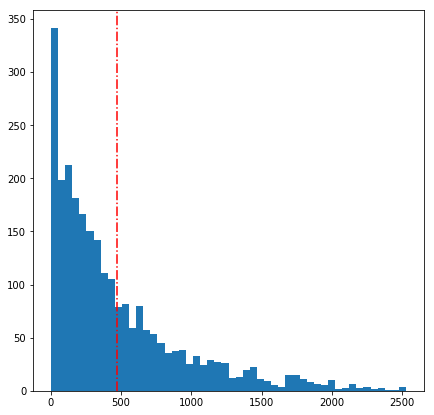

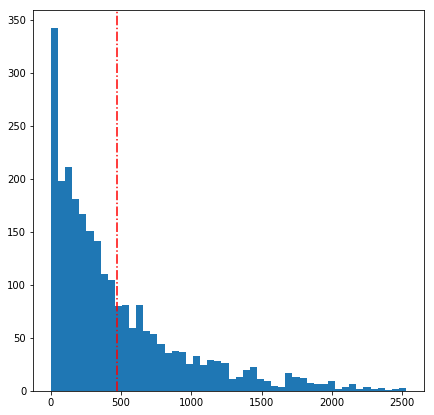

In [8]:

plfu_sfr0 = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/plfu_sfr_spaxel.dat")
plfu_sfr1 = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel.dat")

sfr_num0 = plfu_sfr0[:,2]
sfr_num0 = sfr_num0[np.where(sfr_num0!=0)]
sfr_num1 = plfu_sfr1[:,2]
sfr_num1 = sfr_num1[np.where(sfr_num1!=0)]

plt.figure(figsize=(7,7))
plt.hist(sfr_num0,bins=50);
plt.axvline(np.mean(sfr_num0),color='r',linestyle='-.');
#sfr_id = np.where(plfu_sfr[:,2]>=20)
print(np.shape(np.where(sfr_num0!=0)))

plt.figure(figsize=(7,7))
plt.hist(sfr_num1,bins=50);
plt.axvline(np.mean(sfr_num1),color='r',linestyle='-.');
#sfr_id = np.where(plfu_sfr[:,2]>=20)
print(np.shape(np.where(sfr_num1!=0)))

print(np.sum(plfu_sfr0[:,2]))
print(np.sum(plfu_sfr1[:,2]))
print(np.mean(plfu_sfr0[:,2]))
print(np.mean(plfu_sfr1[:,2]))

### 根据`pyqz`的横纵坐标，得到全部的spaxel的分布图
### 纵坐标y轴 = `log([O iii]5007/[O ii]3726+3729)`
### 横坐标x轴 = `log([N ii]6584/[O ii]3726+3729)`
---
#### 最终结果数组
>`galid_den_NO(4675*2800,10)`   
>>0: spaxel所在的星系的数组位置   
>>1: spaxel在星系中的位置，y坐标   
>>2: spaxel在星系中的位置，x坐标    
>>3: spaxel的surface mass density(直接从manga_firefly.fits中获取，若按照论文则需要自己计算)   
>>4: Nii_6584_flux   
>>5: Oiii_5007_flux   
>>6: Oii_3729_flux   
>>7: Oii_3726_flux   
>>8: log(Oiii/(Oii6+Oii9))   
>>9: log(Nii/(Oii6+Oii9))   
>>`无效数据=-9999`   

In [59]:
import time
import copy
import warnings
from os.path import join

import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from astropy.io import fits
from marvin.tools import Maps

warnings.filterwarnings('ignore')    # 不显示warning信息
vac = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy.copy(vac[1].data)    # galaxy基本信息
# 下载的离线Marvin数据路径
path_marvin_data = '/root/bash_file/marvin_vor10_fits'
# 存储 数组位置, Nii6584,Oiii5007,Oii3729,Oii3726,Oiii/Oii,Nii/Oii 10个量
galid_den_NO = np.zeros([basic['plate'].size*2800,10],dtype='float32')-9999
# surface mass density
sur_density_all = copy.copy(vac['SURFACE_MASS_DENSITY_VORONOI'].data[:,:,0])

bin1d = vac[4].data    # 获取bin_id数组，为了匹配xy坐标位置
bin_2d = vac[5].data    # 获取bin_id数组，为了匹配xy坐标位置

# 获取plate-ifu，为了配合Marvin的包
plate_np = basic['plate']
ifu_np = basic['ifudsgn']
plate_np = plate_np.astype(np.int64)    # 数据转化为整型
#ifu_np = ifu_np.astype(np.int64)    # 数据转化为整型

lalala_start = time.time()    # 开始计时
# for i in range(0,basic['plate'].size):
i = 0    # 星系的数组位置: i
j = 0    # 4675*2800的数组位置: j
#for j in range(0,1):    # 4675*2800的数组位置: j
#while j<4675*2800:
#while j<10:
#while j<basic['plate'].size*sur_density_all[0].size:
# lala=0
# 控制循环最大值
j_end = basic['plate'].size*sur_density_all[0].size
while j<j_end:
    start_for = time.time()    #获取此次循环开始时间
    
    
    
    # 每个星系取值
    plate = plate_np[i]    # 获取plate
    ifu = ifu_np[i]    # 获取ifu
    galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系位置数组，使用plate&ifu进行定位，得到True False数组
    bin_1d = bin1d[galid,:,0][0]    # 获取一维的bin数据
    sur_density = sur_density_all[galid][0]
    
    filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
    new_maps = Maps(filename=filename)
    nii = new_maps.emline_gflux_nii_6585    # 获取Nii_6584
    oii7 = new_maps.emline_gflux_oii_3727    # 获取Oii_3726
    oii9 = new_maps.emline_gflux_oii_3729    # 获取Oii_3729
    oiii = new_maps.emline_gflux_oiii_5008    # 获取Oiii_5007
    
    lg_oiii_oii = np.log10(oiii/(oii7+oii9))
    lg_nii_oii = np.log10(nii/(oii7+oii9))
    
    
        
    # 每个spaxel取值
    image_sz = np.shape(nii)[0]    # 图像边长
    # 临时测试，画图数组
    #maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
    for y in range(0,image_sz):
        for x in range(0,image_sz):
            id_bin = (bin_1d==bin_2d[galid,y,x])    # 搜索二维bin的值在一维bin数组中的 位置
            
            if len(bin_1d[id_bin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                # spaxel所在的星系的数组位置
                galid_den_NO[j,0] = i
                # 星系中的y位置
                galid_den_NO[j,1] = y
                # 星系中的x位置
                galid_den_NO[j,2] = x
                # spaxel's surface mass density
                galid_den_NO[j,3] = sur_density[id_bin]
                # nii 6584
                galid_den_NO[j,4] = nii.value[y,x]
                # oiii 5007
                galid_den_NO[j,5] = oiii.value[y,x]
                # oii 3729
                galid_den_NO[j,6] = oii9.value[y,x]
                # oii 3726
                galid_den_NO[j,7] = oii7.value[y,x]
                # log(Oiii/Oii)
                galid_den_NO[j,8] = lg_oiii_oii.value[y,x]
                # log(nii/Oii)
                galid_den_NO[j,9] = lg_nii_oii.value[y,x]
                #lala = x
                #lala2 = y
                j+=1
                #print("数组位置j已到：",j)
                #maps[y,x] = oii7.value[y,x]    # 临时测试，画图数组
    
    
    end_for = time.time()    # 获取此次循环结束时间
    print('用时: ',end_for-start_for,"  已经计算到第 ",i+1," 个星系   ","剩余 ",4675-i-1,' 个星系')
    
    # 跳过无效数据，直接进入下一个星系
    i += 1
    j = i*2800-1
    
    # 临时测试
    #print("j = ",j)
    #print("j与上一次的差值 = ",j-lala)
    #lala =j
    
    # 限制循环次数，防止超过数组实际大小
    if j>=j_end-1:
        break
    
    
lalala_end = time.time()
print('\n\n\n总用时： ',str(lalala_end-lalala_start))

# 将得到的结果进行保存 (4675*2800,10)
# 无效数据为-9999
np.savetxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/galid_ij_den_NO_logOiiioii_logniioii.dat", galid_den_NO)               

# 简单画图测试
# fig, ax = plt.subplots()
# p = ax.imshow(maps , origin='lower',vmin=0,vmax=1)

                

用时:  1.0621964931488037   已经计算到第  1  个星系    剩余  4674  个星系
用时:  0.9154362678527832   已经计算到第  2  个星系    剩余  4673  个星系
用时:  0.7586846351623535   已经计算到第  3  个星系    剩余  4672  个星系
用时:  0.656977653503418   已经计算到第  4  个星系    剩余  4671  个星系
用时:  0.7995190620422363   已经计算到第  5  个星系    剩余  4670  个星系
用时:  0.7120764255523682   已经计算到第  6  个星系    剩余  4669  个星系
用时:  0.807976484298706   已经计算到第  7  个星系    剩余  4668  个星系
用时:  1.020972490310669   已经计算到第  8  个星系    剩余  4667  个星系
用时:  0.662207841873169   已经计算到第  9  个星系    剩余  4666  个星系
用时:  1.1661455631256104   已经计算到第  10  个星系    剩余  4665  个星系
用时:  0.7389161586761475   已经计算到第  11  个星系    剩余  4664  个星系
用时:  0.6466519832611084   已经计算到第  12  个星系    剩余  4663  个星系
用时:  0.8911480903625488   已经计算到第  13  个星系    剩余  4662  个星系
用时:  0.9808511734008789   已经计算到第  14  个星系    剩余  4661  个星系
用时:  0.7964379787445068   已经计算到第  15  个星系    剩余  4660  个星系
用时:  1.0545804500579834   已经计算到第  16  个星系    剩余  4659  个星系
用时:  1.1075894832611084   已经计算到第  17  个星系    剩余  4658  个星系
用时:  0.940

用时:  0.6216847896575928   已经计算到第  140  个星系    剩余  4535  个星系
用时:  0.6563084125518799   已经计算到第  141  个星系    剩余  4534  个星系
用时:  0.6350147724151611   已经计算到第  142  个星系    剩余  4533  个星系
用时:  0.5745668411254883   已经计算到第  143  个星系    剩余  4532  个星系
用时:  0.6937916278839111   已经计算到第  144  个星系    剩余  4531  个星系
用时:  0.7366809844970703   已经计算到第  145  个星系    剩余  4530  个星系
用时:  0.8159093856811523   已经计算到第  146  个星系    剩余  4529  个星系
用时:  0.8865799903869629   已经计算到第  147  个星系    剩余  4528  个星系
用时:  0.9594902992248535   已经计算到第  148  个星系    剩余  4527  个星系
用时:  0.7815461158752441   已经计算到第  149  个星系    剩余  4526  个星系
用时:  0.9284827709197998   已经计算到第  150  个星系    剩余  4525  个星系
用时:  0.8842127323150635   已经计算到第  151  个星系    剩余  4524  个星系
用时:  0.8607082366943359   已经计算到第  152  个星系    剩余  4523  个星系
用时:  1.069206953048706   已经计算到第  153  个星系    剩余  4522  个星系
用时:  0.8310763835906982   已经计算到第  154  个星系    剩余  4521  个星系
用时:  0.9616720676422119   已经计算到第  155  个星系    剩余  4520  个星系
用时:  0.9618780612945557   已经计算到第  156  个星

用时:  0.8743648529052734   已经计算到第  278  个星系    剩余  4397  个星系
用时:  0.761847734451294   已经计算到第  279  个星系    剩余  4396  个星系
用时:  0.9227101802825928   已经计算到第  280  个星系    剩余  4395  个星系
用时:  0.7086837291717529   已经计算到第  281  个星系    剩余  4394  个星系
用时:  0.7415745258331299   已经计算到第  282  个星系    剩余  4393  个星系
用时:  1.509941816329956   已经计算到第  283  个星系    剩余  4392  个星系
用时:  0.6010854244232178   已经计算到第  284  个星系    剩余  4391  个星系
用时:  0.7368946075439453   已经计算到第  285  个星系    剩余  4390  个星系
用时:  0.6025350093841553   已经计算到第  286  个星系    剩余  4389  个星系
用时:  0.7169249057769775   已经计算到第  287  个星系    剩余  4388  个星系
用时:  0.8855295181274414   已经计算到第  288  个星系    剩余  4387  个星系
用时:  0.6457173824310303   已经计算到第  289  个星系    剩余  4386  个星系
用时:  0.9246854782104492   已经计算到第  290  个星系    剩余  4385  个星系
用时:  0.5858361721038818   已经计算到第  291  个星系    剩余  4384  个星系
用时:  0.6130692958831787   已经计算到第  292  个星系    剩余  4383  个星系
用时:  0.6978819370269775   已经计算到第  293  个星系    剩余  4382  个星系
用时:  0.7590687274932861   已经计算到第  294  个星系

用时:  0.6543149948120117   已经计算到第  415  个星系    剩余  4260  个星系
用时:  0.9480836391448975   已经计算到第  416  个星系    剩余  4259  个星系
用时:  0.868398904800415   已经计算到第  417  个星系    剩余  4258  个星系
用时:  0.8429386615753174   已经计算到第  418  个星系    剩余  4257  个星系
用时:  0.6952764987945557   已经计算到第  419  个星系    剩余  4256  个星系
用时:  0.7157924175262451   已经计算到第  420  个星系    剩余  4255  个星系
用时:  0.9144361019134521   已经计算到第  421  个星系    剩余  4254  个星系
用时:  0.8186755180358887   已经计算到第  422  个星系    剩余  4253  个星系
用时:  0.7822432518005371   已经计算到第  423  个星系    剩余  4252  个星系
用时:  0.9341447353363037   已经计算到第  424  个星系    剩余  4251  个星系
用时:  0.727259635925293   已经计算到第  425  个星系    剩余  4250  个星系
用时:  0.8899729251861572   已经计算到第  426  个星系    剩余  4249  个星系
用时:  0.6633200645446777   已经计算到第  427  个星系    剩余  4248  个星系
用时:  0.6677067279815674   已经计算到第  428  个星系    剩余  4247  个星系
用时:  0.806307315826416   已经计算到第  429  个星系    剩余  4246  个星系
用时:  0.6870710849761963   已经计算到第  430  个星系    剩余  4245  个星系
用时:  0.7594685554504395   已经计算到第  431  个星系 

用时:  1.0972955226898193   已经计算到第  552  个星系    剩余  4123  个星系
用时:  0.7696917057037354   已经计算到第  553  个星系    剩余  4122  个星系
用时:  0.7487642765045166   已经计算到第  554  个星系    剩余  4121  个星系
用时:  0.9939820766448975   已经计算到第  555  个星系    剩余  4120  个星系
用时:  0.6636614799499512   已经计算到第  556  个星系    剩余  4119  个星系
用时:  0.7110202312469482   已经计算到第  557  个星系    剩余  4118  个星系
用时:  0.7045795917510986   已经计算到第  558  个星系    剩余  4117  个星系
用时:  0.9963150024414062   已经计算到第  559  个星系    剩余  4116  个星系
用时:  0.75411057472229   已经计算到第  560  个星系    剩余  4115  个星系
用时:  0.7413153648376465   已经计算到第  561  个星系    剩余  4114  个星系
用时:  0.7162384986877441   已经计算到第  562  个星系    剩余  4113  个星系
用时:  0.7638149261474609   已经计算到第  563  个星系    剩余  4112  个星系
用时:  0.9921293258666992   已经计算到第  564  个星系    剩余  4111  个星系
用时:  0.9365077018737793   已经计算到第  565  个星系    剩余  4110  个星系
用时:  1.035940170288086   已经计算到第  566  个星系    剩余  4109  个星系
用时:  0.9291636943817139   已经计算到第  567  个星系    剩余  4108  个星系
用时:  0.6153278350830078   已经计算到第  568  个星系 

用时:  0.906468391418457   已经计算到第  689  个星系    剩余  3986  个星系
用时:  1.020193099975586   已经计算到第  690  个星系    剩余  3985  个星系
用时:  1.0432348251342773   已经计算到第  691  个星系    剩余  3984  个星系
用时:  0.7172534465789795   已经计算到第  692  个星系    剩余  3983  个星系
用时:  0.6563527584075928   已经计算到第  693  个星系    剩余  3982  个星系
用时:  0.6006224155426025   已经计算到第  694  个星系    剩余  3981  个星系
用时:  1.071340560913086   已经计算到第  695  个星系    剩余  3980  个星系
用时:  0.9667158126831055   已经计算到第  696  个星系    剩余  3979  个星系
用时:  0.9832577705383301   已经计算到第  697  个星系    剩余  3978  个星系
用时:  0.8872897624969482   已经计算到第  698  个星系    剩余  3977  个星系
用时:  0.7224173545837402   已经计算到第  699  个星系    剩余  3976  个星系
用时:  0.8715970516204834   已经计算到第  700  个星系    剩余  3975  个星系
用时:  0.7708902359008789   已经计算到第  701  个星系    剩余  3974  个星系
用时:  0.9359128475189209   已经计算到第  702  个星系    剩余  3973  个星系
用时:  0.669658899307251   已经计算到第  703  个星系    剩余  3972  个星系
用时:  0.9797682762145996   已经计算到第  704  个星系    剩余  3971  个星系
用时:  1.0437393188476562   已经计算到第  705  个星系  

用时:  1.0969722270965576   已经计算到第  826  个星系    剩余  3849  个星系
用时:  0.7162482738494873   已经计算到第  827  个星系    剩余  3848  个星系
用时:  1.0302836894989014   已经计算到第  828  个星系    剩余  3847  个星系
用时:  0.8439979553222656   已经计算到第  829  个星系    剩余  3846  个星系
用时:  0.9849228858947754   已经计算到第  830  个星系    剩余  3845  个星系
用时:  0.8645775318145752   已经计算到第  831  个星系    剩余  3844  个星系
用时:  0.9638481140136719   已经计算到第  832  个星系    剩余  3843  个星系
用时:  1.0735008716583252   已经计算到第  833  个星系    剩余  3842  个星系
用时:  0.6696205139160156   已经计算到第  834  个星系    剩余  3841  个星系
用时:  0.6997194290161133   已经计算到第  835  个星系    剩余  3840  个星系
用时:  0.72334885597229   已经计算到第  836  个星系    剩余  3839  个星系
用时:  1.0307562351226807   已经计算到第  837  个星系    剩余  3838  个星系
用时:  0.6161489486694336   已经计算到第  838  个星系    剩余  3837  个星系
用时:  0.8030779361724854   已经计算到第  839  个星系    剩余  3836  个星系
用时:  0.7286489009857178   已经计算到第  840  个星系    剩余  3835  个星系
用时:  0.6701812744140625   已经计算到第  841  个星系    剩余  3834  个星系
用时:  0.9129753112792969   已经计算到第  842  个星系

用时:  0.9035069942474365   已经计算到第  963  个星系    剩余  3712  个星系
用时:  0.8285179138183594   已经计算到第  964  个星系    剩余  3711  个星系
用时:  1.2558116912841797   已经计算到第  965  个星系    剩余  3710  个星系
用时:  0.930145263671875   已经计算到第  966  个星系    剩余  3709  个星系
用时:  0.8686578273773193   已经计算到第  967  个星系    剩余  3708  个星系
用时:  0.8404541015625   已经计算到第  968  个星系    剩余  3707  个星系
用时:  0.7265775203704834   已经计算到第  969  个星系    剩余  3706  个星系
用时:  0.8919675350189209   已经计算到第  970  个星系    剩余  3705  个星系
用时:  0.7067070007324219   已经计算到第  971  个星系    剩余  3704  个星系
用时:  0.8841063976287842   已经计算到第  972  个星系    剩余  3703  个星系
用时:  1.0955827236175537   已经计算到第  973  个星系    剩余  3702  个星系
用时:  0.8307468891143799   已经计算到第  974  个星系    剩余  3701  个星系
用时:  0.850989580154419   已经计算到第  975  个星系    剩余  3700  个星系
用时:  0.6929051876068115   已经计算到第  976  个星系    剩余  3699  个星系
用时:  0.6051008701324463   已经计算到第  977  个星系    剩余  3698  个星系
用时:  1.0519428253173828   已经计算到第  978  个星系    剩余  3697  个星系
用时:  0.9436228275299072   已经计算到第  979  个星系   

用时:  0.6273388862609863   已经计算到第  1099  个星系    剩余  3576  个星系
用时:  0.7443149089813232   已经计算到第  1100  个星系    剩余  3575  个星系
用时:  0.7959907054901123   已经计算到第  1101  个星系    剩余  3574  个星系
用时:  0.886876106262207   已经计算到第  1102  个星系    剩余  3573  个星系
用时:  0.8592250347137451   已经计算到第  1103  个星系    剩余  3572  个星系
用时:  0.6788926124572754   已经计算到第  1104  个星系    剩余  3571  个星系
用时:  0.9459011554718018   已经计算到第  1105  个星系    剩余  3570  个星系
用时:  0.8576905727386475   已经计算到第  1106  个星系    剩余  3569  个星系
用时:  0.6050024032592773   已经计算到第  1107  个星系    剩余  3568  个星系
用时:  1.1009221076965332   已经计算到第  1108  个星系    剩余  3567  个星系
用时:  0.8115947246551514   已经计算到第  1109  个星系    剩余  3566  个星系
用时:  0.6737041473388672   已经计算到第  1110  个星系    剩余  3565  个星系
用时:  0.5646669864654541   已经计算到第  1111  个星系    剩余  3564  个星系
用时:  0.6178789138793945   已经计算到第  1112  个星系    剩余  3563  个星系
用时:  0.6900866031646729   已经计算到第  1113  个星系    剩余  3562  个星系
用时:  0.9805500507354736   已经计算到第  1114  个星系    剩余  3561  个星系
用时:  1.0907843112945557  

用时:  0.642742395401001   已经计算到第  1234  个星系    剩余  3441  个星系
用时:  0.7082698345184326   已经计算到第  1235  个星系    剩余  3440  个星系
用时:  0.8430478572845459   已经计算到第  1236  个星系    剩余  3439  个星系
用时:  0.6200120449066162   已经计算到第  1237  个星系    剩余  3438  个星系
用时:  0.7361626625061035   已经计算到第  1238  个星系    剩余  3437  个星系
用时:  0.8270869255065918   已经计算到第  1239  个星系    剩余  3436  个星系
用时:  0.7727615833282471   已经计算到第  1240  个星系    剩余  3435  个星系
用时:  0.726285457611084   已经计算到第  1241  个星系    剩余  3434  个星系
用时:  0.7544474601745605   已经计算到第  1242  个星系    剩余  3433  个星系
用时:  0.9259719848632812   已经计算到第  1243  个星系    剩余  3432  个星系
用时:  0.6343460083007812   已经计算到第  1244  个星系    剩余  3431  个星系
用时:  0.7244739532470703   已经计算到第  1245  个星系    剩余  3430  个星系
用时:  0.8797879219055176   已经计算到第  1246  个星系    剩余  3429  个星系
用时:  0.8158533573150635   已经计算到第  1247  个星系    剩余  3428  个星系
用时:  1.2607784271240234   已经计算到第  1248  个星系    剩余  3427  个星系
用时:  0.6788761615753174   已经计算到第  1249  个星系    剩余  3426  个星系
用时:  0.8529868125915527   

用时:  0.6169910430908203   已经计算到第  1369  个星系    剩余  3306  个星系
用时:  0.7100958824157715   已经计算到第  1370  个星系    剩余  3305  个星系
用时:  0.8951940536499023   已经计算到第  1371  个星系    剩余  3304  个星系
用时:  0.7646017074584961   已经计算到第  1372  个星系    剩余  3303  个星系
用时:  1.1230251789093018   已经计算到第  1373  个星系    剩余  3302  个星系
用时:  0.8994016647338867   已经计算到第  1374  个星系    剩余  3301  个星系
用时:  0.6796979904174805   已经计算到第  1375  个星系    剩余  3300  个星系
用时:  0.6568524837493896   已经计算到第  1376  个星系    剩余  3299  个星系
用时:  0.6536319255828857   已经计算到第  1377  个星系    剩余  3298  个星系
用时:  0.588409423828125   已经计算到第  1378  个星系    剩余  3297  个星系
用时:  0.8528642654418945   已经计算到第  1379  个星系    剩余  3296  个星系
用时:  0.9791779518127441   已经计算到第  1380  个星系    剩余  3295  个星系
用时:  0.9903175830841064   已经计算到第  1381  个星系    剩余  3294  个星系
用时:  0.7918238639831543   已经计算到第  1382  个星系    剩余  3293  个星系
用时:  0.9752802848815918   已经计算到第  1383  个星系    剩余  3292  个星系
用时:  1.0706491470336914   已经计算到第  1384  个星系    剩余  3291  个星系
用时:  0.7160344123840332  

用时:  0.6938462257385254   已经计算到第  1504  个星系    剩余  3171  个星系
用时:  0.9487419128417969   已经计算到第  1505  个星系    剩余  3170  个星系
用时:  0.9519150257110596   已经计算到第  1506  个星系    剩余  3169  个星系
用时:  1.068986415863037   已经计算到第  1507  个星系    剩余  3168  个星系
用时:  0.9518411159515381   已经计算到第  1508  个星系    剩余  3167  个星系
用时:  0.7722327709197998   已经计算到第  1509  个星系    剩余  3166  个星系
用时:  0.670886754989624   已经计算到第  1510  个星系    剩余  3165  个星系
用时:  0.9082581996917725   已经计算到第  1511  个星系    剩余  3164  个星系
用时:  0.7291507720947266   已经计算到第  1512  个星系    剩余  3163  个星系
用时:  0.6031410694122314   已经计算到第  1513  个星系    剩余  3162  个星系
用时:  1.2615430355072021   已经计算到第  1514  个星系    剩余  3161  个星系
用时:  1.004915714263916   已经计算到第  1515  个星系    剩余  3160  个星系
用时:  0.890636682510376   已经计算到第  1516  个星系    剩余  3159  个星系
用时:  0.8262507915496826   已经计算到第  1517  个星系    剩余  3158  个星系
用时:  0.9155087471008301   已经计算到第  1518  个星系    剩余  3157  个星系
用时:  1.0841221809387207   已经计算到第  1519  个星系    剩余  3156  个星系
用时:  0.6780178546905518   已经

用时:  0.6751346588134766   已经计算到第  1639  个星系    剩余  3036  个星系
用时:  0.8428137302398682   已经计算到第  1640  个星系    剩余  3035  个星系
用时:  0.8513009548187256   已经计算到第  1641  个星系    剩余  3034  个星系
用时:  0.9145965576171875   已经计算到第  1642  个星系    剩余  3033  个星系
用时:  0.616530179977417   已经计算到第  1643  个星系    剩余  3032  个星系
用时:  0.6779317855834961   已经计算到第  1644  个星系    剩余  3031  个星系
用时:  0.7068548202514648   已经计算到第  1645  个星系    剩余  3030  个星系
用时:  1.020240306854248   已经计算到第  1646  个星系    剩余  3029  个星系
用时:  0.9989659786224365   已经计算到第  1647  个星系    剩余  3028  个星系
用时:  0.6368803977966309   已经计算到第  1648  个星系    剩余  3027  个星系
用时:  0.6830501556396484   已经计算到第  1649  个星系    剩余  3026  个星系
用时:  0.8108973503112793   已经计算到第  1650  个星系    剩余  3025  个星系
用时:  0.7980203628540039   已经计算到第  1651  个星系    剩余  3024  个星系
用时:  0.7100071907043457   已经计算到第  1652  个星系    剩余  3023  个星系
用时:  0.8252027034759521   已经计算到第  1653  个星系    剩余  3022  个星系
用时:  0.7185297012329102   已经计算到第  1654  个星系    剩余  3021  个星系
用时:  0.9263064861297607   

用时:  0.872638463973999   已经计算到第  1774  个星系    剩余  2901  个星系
用时:  0.6661031246185303   已经计算到第  1775  个星系    剩余  2900  个星系
用时:  0.9234879016876221   已经计算到第  1776  个星系    剩余  2899  个星系
用时:  0.7278881072998047   已经计算到第  1777  个星系    剩余  2898  个星系
用时:  0.9025297164916992   已经计算到第  1778  个星系    剩余  2897  个星系
用时:  1.0935609340667725   已经计算到第  1779  个星系    剩余  2896  个星系
用时:  0.9166843891143799   已经计算到第  1780  个星系    剩余  2895  个星系
用时:  0.6205627918243408   已经计算到第  1781  个星系    剩余  2894  个星系
用时:  0.9146707057952881   已经计算到第  1782  个星系    剩余  2893  个星系
用时:  0.6568887233734131   已经计算到第  1783  个星系    剩余  2892  个星系
用时:  0.9814276695251465   已经计算到第  1784  个星系    剩余  2891  个星系
用时:  0.7052924633026123   已经计算到第  1785  个星系    剩余  2890  个星系
用时:  0.6386632919311523   已经计算到第  1786  个星系    剩余  2889  个星系
用时:  0.6779534816741943   已经计算到第  1787  个星系    剩余  2888  个星系
用时:  0.6666226387023926   已经计算到第  1788  个星系    剩余  2887  个星系
用时:  0.7389216423034668   已经计算到第  1789  个星系    剩余  2886  个星系
用时:  0.7807333469390869  

用时:  0.7271099090576172   已经计算到第  1909  个星系    剩余  2766  个星系
用时:  0.737560510635376   已经计算到第  1910  个星系    剩余  2765  个星系
用时:  0.6821644306182861   已经计算到第  1911  个星系    剩余  2764  个星系
用时:  0.8982183933258057   已经计算到第  1912  个星系    剩余  2763  个星系
用时:  0.8859865665435791   已经计算到第  1913  个星系    剩余  2762  个星系
用时:  0.7014672756195068   已经计算到第  1914  个星系    剩余  2761  个星系
用时:  0.7304172515869141   已经计算到第  1915  个星系    剩余  2760  个星系
用时:  0.9392645359039307   已经计算到第  1916  个星系    剩余  2759  个星系
用时:  0.8302404880523682   已经计算到第  1917  个星系    剩余  2758  个星系
用时:  0.9252352714538574   已经计算到第  1918  个星系    剩余  2757  个星系
用时:  0.706341028213501   已经计算到第  1919  个星系    剩余  2756  个星系
用时:  0.7352588176727295   已经计算到第  1920  个星系    剩余  2755  个星系
用时:  0.9214699268341064   已经计算到第  1921  个星系    剩余  2754  个星系
用时:  0.5941104888916016   已经计算到第  1922  个星系    剩余  2753  个星系
用时:  0.8780584335327148   已经计算到第  1923  个星系    剩余  2752  个星系
用时:  0.7727727890014648   已经计算到第  1924  个星系    剩余  2751  个星系
用时:  0.9328649044036865   

用时:  0.7006814479827881   已经计算到第  2044  个星系    剩余  2631  个星系
用时:  0.7023212909698486   已经计算到第  2045  个星系    剩余  2630  个星系
用时:  1.0678584575653076   已经计算到第  2046  个星系    剩余  2629  个星系
用时:  0.7918832302093506   已经计算到第  2047  个星系    剩余  2628  个星系
用时:  0.5805232524871826   已经计算到第  2048  个星系    剩余  2627  个星系
用时:  0.6658041477203369   已经计算到第  2049  个星系    剩余  2626  个星系
用时:  0.774587869644165   已经计算到第  2050  个星系    剩余  2625  个星系
用时:  0.88169264793396   已经计算到第  2051  个星系    剩余  2624  个星系
用时:  0.9039111137390137   已经计算到第  2052  个星系    剩余  2623  个星系
用时:  0.9118757247924805   已经计算到第  2053  个星系    剩余  2622  个星系
用时:  0.9745023250579834   已经计算到第  2054  个星系    剩余  2621  个星系
用时:  0.6682689189910889   已经计算到第  2055  个星系    剩余  2620  个星系
用时:  0.7759718894958496   已经计算到第  2056  个星系    剩余  2619  个星系
用时:  0.7543289661407471   已经计算到第  2057  个星系    剩余  2618  个星系
用时:  0.6638920307159424   已经计算到第  2058  个星系    剩余  2617  个星系
用时:  0.6136832237243652   已经计算到第  2059  个星系    剩余  2616  个星系
用时:  1.0603868961334229   已

用时:  1.0219464302062988   已经计算到第  2179  个星系    剩余  2496  个星系
用时:  1.0466833114624023   已经计算到第  2180  个星系    剩余  2495  个星系
用时:  0.8138077259063721   已经计算到第  2181  个星系    剩余  2494  个星系
用时:  0.681727409362793   已经计算到第  2182  个星系    剩余  2493  个星系
用时:  0.6590681076049805   已经计算到第  2183  个星系    剩余  2492  个星系
用时:  1.003474235534668   已经计算到第  2184  个星系    剩余  2491  个星系
用时:  0.8742372989654541   已经计算到第  2185  个星系    剩余  2490  个星系
用时:  0.7724440097808838   已经计算到第  2186  个星系    剩余  2489  个星系
用时:  0.6484014987945557   已经计算到第  2187  个星系    剩余  2488  个星系
用时:  0.6672472953796387   已经计算到第  2188  个星系    剩余  2487  个星系
用时:  0.6854228973388672   已经计算到第  2189  个星系    剩余  2486  个星系
用时:  0.6221413612365723   已经计算到第  2190  个星系    剩余  2485  个星系
用时:  0.6648714542388916   已经计算到第  2191  个星系    剩余  2484  个星系
用时:  0.6631438732147217   已经计算到第  2192  个星系    剩余  2483  个星系
用时:  1.1706068515777588   已经计算到第  2193  个星系    剩余  2482  个星系
用时:  0.6773107051849365   已经计算到第  2194  个星系    剩余  2481  个星系
用时:  0.6637334823608398   

用时:  0.9592809677124023   已经计算到第  2314  个星系    剩余  2361  个星系
用时:  0.8916640281677246   已经计算到第  2315  个星系    剩余  2360  个星系
用时:  1.0078387260437012   已经计算到第  2316  个星系    剩余  2359  个星系
用时:  0.6737222671508789   已经计算到第  2317  个星系    剩余  2358  个星系
用时:  0.6599907875061035   已经计算到第  2318  个星系    剩余  2357  个星系
用时:  0.6825566291809082   已经计算到第  2319  个星系    剩余  2356  个星系
用时:  0.7861454486846924   已经计算到第  2320  个星系    剩余  2355  个星系
用时:  0.8116471767425537   已经计算到第  2321  个星系    剩余  2354  个星系
用时:  0.8005290031433105   已经计算到第  2322  个星系    剩余  2353  个星系
用时:  0.8601012229919434   已经计算到第  2323  个星系    剩余  2352  个星系
用时:  0.7312612533569336   已经计算到第  2324  个星系    剩余  2351  个星系
用时:  0.8294835090637207   已经计算到第  2325  个星系    剩余  2350  个星系
用时:  0.9728591442108154   已经计算到第  2326  个星系    剩余  2349  个星系
用时:  0.8489055633544922   已经计算到第  2327  个星系    剩余  2348  个星系
用时:  0.8833606243133545   已经计算到第  2328  个星系    剩余  2347  个星系
用时:  0.747272253036499   已经计算到第  2329  个星系    剩余  2346  个星系
用时:  0.8838789463043213  

用时:  0.8769690990447998   已经计算到第  2449  个星系    剩余  2226  个星系
用时:  0.8237495422363281   已经计算到第  2450  个星系    剩余  2225  个星系
用时:  1.0944170951843262   已经计算到第  2451  个星系    剩余  2224  个星系
用时:  0.9754245281219482   已经计算到第  2452  个星系    剩余  2223  个星系
用时:  0.7477896213531494   已经计算到第  2453  个星系    剩余  2222  个星系
用时:  0.6133701801300049   已经计算到第  2454  个星系    剩余  2221  个星系
用时:  0.5742685794830322   已经计算到第  2455  个星系    剩余  2220  个星系
用时:  0.6414752006530762   已经计算到第  2456  个星系    剩余  2219  个星系
用时:  0.7385311126708984   已经计算到第  2457  个星系    剩余  2218  个星系
用时:  0.8358514308929443   已经计算到第  2458  个星系    剩余  2217  个星系
用时:  1.0255062580108643   已经计算到第  2459  个星系    剩余  2216  个星系
用时:  1.2122254371643066   已经计算到第  2460  个星系    剩余  2215  个星系
用时:  0.9283792972564697   已经计算到第  2461  个星系    剩余  2214  个星系
用时:  0.8372931480407715   已经计算到第  2462  个星系    剩余  2213  个星系
用时:  0.8303625583648682   已经计算到第  2463  个星系    剩余  2212  个星系
用时:  1.0154333114624023   已经计算到第  2464  个星系    剩余  2211  个星系
用时:  0.7334244251251221 

用时:  0.6188962459564209   已经计算到第  2584  个星系    剩余  2091  个星系
用时:  0.657581090927124   已经计算到第  2585  个星系    剩余  2090  个星系
用时:  0.745025634765625   已经计算到第  2586  个星系    剩余  2089  个星系
用时:  0.6868011951446533   已经计算到第  2587  个星系    剩余  2088  个星系
用时:  0.7140545845031738   已经计算到第  2588  个星系    剩余  2087  个星系
用时:  0.7256679534912109   已经计算到第  2589  个星系    剩余  2086  个星系
用时:  0.6456303596496582   已经计算到第  2590  个星系    剩余  2085  个星系
用时:  1.0497918128967285   已经计算到第  2591  个星系    剩余  2084  个星系
用时:  0.6625244617462158   已经计算到第  2592  个星系    剩余  2083  个星系
用时:  0.6735613346099854   已经计算到第  2593  个星系    剩余  2082  个星系
用时:  0.7322609424591064   已经计算到第  2594  个星系    剩余  2081  个星系
用时:  0.793057918548584   已经计算到第  2595  个星系    剩余  2080  个星系
用时:  0.7292542457580566   已经计算到第  2596  个星系    剩余  2079  个星系
用时:  0.6879997253417969   已经计算到第  2597  个星系    剩余  2078  个星系
用时:  0.7079026699066162   已经计算到第  2598  个星系    剩余  2077  个星系
用时:  0.8167333602905273   已经计算到第  2599  个星系    剩余  2076  个星系
用时:  0.9260101318359375   已

用时:  0.7268915176391602   已经计算到第  2719  个星系    剩余  1956  个星系
用时:  0.6553525924682617   已经计算到第  2720  个星系    剩余  1955  个星系
用时:  0.7481935024261475   已经计算到第  2721  个星系    剩余  1954  个星系
用时:  0.7662465572357178   已经计算到第  2722  个星系    剩余  1953  个星系
用时:  0.7442638874053955   已经计算到第  2723  个星系    剩余  1952  个星系
用时:  0.8211808204650879   已经计算到第  2724  个星系    剩余  1951  个星系
用时:  0.7586209774017334   已经计算到第  2725  个星系    剩余  1950  个星系
用时:  0.7888092994689941   已经计算到第  2726  个星系    剩余  1949  个星系
用时:  0.9453485012054443   已经计算到第  2727  个星系    剩余  1948  个星系
用时:  0.8578994274139404   已经计算到第  2728  个星系    剩余  1947  个星系
用时:  0.6609594821929932   已经计算到第  2729  个星系    剩余  1946  个星系
用时:  0.9590432643890381   已经计算到第  2730  个星系    剩余  1945  个星系
用时:  0.6949286460876465   已经计算到第  2731  个星系    剩余  1944  个星系
用时:  0.7998230457305908   已经计算到第  2732  个星系    剩余  1943  个星系
用时:  0.8154401779174805   已经计算到第  2733  个星系    剩余  1942  个星系
用时:  0.966038703918457   已经计算到第  2734  个星系    剩余  1941  个星系
用时:  0.7817990779876709  

用时:  1.0945556163787842   已经计算到第  2854  个星系    剩余  1821  个星系
用时:  0.5739631652832031   已经计算到第  2855  个星系    剩余  1820  个星系
用时:  0.8134238719940186   已经计算到第  2856  个星系    剩余  1819  个星系
用时:  0.8460073471069336   已经计算到第  2857  个星系    剩余  1818  个星系
用时:  0.7075207233428955   已经计算到第  2858  个星系    剩余  1817  个星系
用时:  0.8099074363708496   已经计算到第  2859  个星系    剩余  1816  个星系
用时:  1.00260591506958   已经计算到第  2860  个星系    剩余  1815  个星系
用时:  0.8874490261077881   已经计算到第  2861  个星系    剩余  1814  个星系
用时:  0.8286159038543701   已经计算到第  2862  个星系    剩余  1813  个星系
用时:  0.9811954498291016   已经计算到第  2863  个星系    剩余  1812  个星系
用时:  0.5869390964508057   已经计算到第  2864  个星系    剩余  1811  个星系
用时:  0.7032945156097412   已经计算到第  2865  个星系    剩余  1810  个星系
用时:  0.6394665241241455   已经计算到第  2866  个星系    剩余  1809  个星系
用时:  0.8220055103302002   已经计算到第  2867  个星系    剩余  1808  个星系
用时:  0.7880504131317139   已经计算到第  2868  个星系    剩余  1807  个星系
用时:  0.9024717807769775   已经计算到第  2869  个星系    剩余  1806  个星系
用时:  0.6897833347320557   

用时:  0.8580381870269775   已经计算到第  2989  个星系    剩余  1686  个星系
用时:  0.7408437728881836   已经计算到第  2990  个星系    剩余  1685  个星系
用时:  0.7969939708709717   已经计算到第  2991  个星系    剩余  1684  个星系
用时:  0.7730464935302734   已经计算到第  2992  个星系    剩余  1683  个星系
用时:  0.6388688087463379   已经计算到第  2993  个星系    剩余  1682  个星系
用时:  0.9687418937683105   已经计算到第  2994  个星系    剩余  1681  个星系
用时:  0.6866977214813232   已经计算到第  2995  个星系    剩余  1680  个星系
用时:  0.6482105255126953   已经计算到第  2996  个星系    剩余  1679  个星系
用时:  0.5988972187042236   已经计算到第  2997  个星系    剩余  1678  个星系
用时:  0.8074729442596436   已经计算到第  2998  个星系    剩余  1677  个星系
用时:  0.6950664520263672   已经计算到第  2999  个星系    剩余  1676  个星系
用时:  0.9606914520263672   已经计算到第  3000  个星系    剩余  1675  个星系
用时:  0.8619561195373535   已经计算到第  3001  个星系    剩余  1674  个星系
用时:  0.7621240615844727   已经计算到第  3002  个星系    剩余  1673  个星系
用时:  0.91817307472229   已经计算到第  3003  个星系    剩余  1672  个星系
用时:  0.9654700756072998   已经计算到第  3004  个星系    剩余  1671  个星系
用时:  0.6568045616149902   

用时:  0.6171927452087402   已经计算到第  3124  个星系    剩余  1551  个星系
用时:  0.6251609325408936   已经计算到第  3125  个星系    剩余  1550  个星系
用时:  0.697150707244873   已经计算到第  3126  个星系    剩余  1549  个星系
用时:  0.8329830169677734   已经计算到第  3127  个星系    剩余  1548  个星系
用时:  0.6882710456848145   已经计算到第  3128  个星系    剩余  1547  个星系
用时:  1.162355899810791   已经计算到第  3129  个星系    剩余  1546  个星系
用时:  0.6156246662139893   已经计算到第  3130  个星系    剩余  1545  个星系
用时:  1.0170094966888428   已经计算到第  3131  个星系    剩余  1544  个星系
用时:  0.7532145977020264   已经计算到第  3132  个星系    剩余  1543  个星系
用时:  0.8749406337738037   已经计算到第  3133  个星系    剩余  1542  个星系
用时:  0.7065823078155518   已经计算到第  3134  个星系    剩余  1541  个星系
用时:  0.7447967529296875   已经计算到第  3135  个星系    剩余  1540  个星系
用时:  0.6840379238128662   已经计算到第  3136  个星系    剩余  1539  个星系
用时:  0.9517941474914551   已经计算到第  3137  个星系    剩余  1538  个星系
用时:  0.8898334503173828   已经计算到第  3138  个星系    剩余  1537  个星系
用时:  0.7627451419830322   已经计算到第  3139  个星系    剩余  1536  个星系
用时:  0.9223744869232178   

用时:  1.0058715343475342   已经计算到第  3259  个星系    剩余  1416  个星系
用时:  0.6227574348449707   已经计算到第  3260  个星系    剩余  1415  个星系
用时:  0.8834497928619385   已经计算到第  3261  个星系    剩余  1414  个星系
用时:  0.6656501293182373   已经计算到第  3262  个星系    剩余  1413  个星系
用时:  0.7824504375457764   已经计算到第  3263  个星系    剩余  1412  个星系
用时:  0.8972733020782471   已经计算到第  3264  个星系    剩余  1411  个星系
用时:  0.9440319538116455   已经计算到第  3265  个星系    剩余  1410  个星系
用时:  0.822575569152832   已经计算到第  3266  个星系    剩余  1409  个星系
用时:  0.9235363006591797   已经计算到第  3267  个星系    剩余  1408  个星系
用时:  0.8822884559631348   已经计算到第  3268  个星系    剩余  1407  个星系
用时:  0.80049729347229   已经计算到第  3269  个星系    剩余  1406  个星系
用时:  0.697608470916748   已经计算到第  3270  个星系    剩余  1405  个星系
用时:  0.8784782886505127   已经计算到第  3271  个星系    剩余  1404  个星系
用时:  0.6511931419372559   已经计算到第  3272  个星系    剩余  1403  个星系
用时:  0.8077178001403809   已经计算到第  3273  个星系    剩余  1402  个星系
用时:  0.8307516574859619   已经计算到第  3274  个星系    剩余  1401  个星系
用时:  0.7530748844146729   已经

用时:  0.6826455593109131   已经计算到第  3394  个星系    剩余  1281  个星系
用时:  1.018789291381836   已经计算到第  3395  个星系    剩余  1280  个星系
用时:  1.129896879196167   已经计算到第  3396  个星系    剩余  1279  个星系
用时:  0.8225510120391846   已经计算到第  3397  个星系    剩余  1278  个星系
用时:  0.6880462169647217   已经计算到第  3398  个星系    剩余  1277  个星系
用时:  0.9591505527496338   已经计算到第  3399  个星系    剩余  1276  个星系
用时:  0.8706622123718262   已经计算到第  3400  个星系    剩余  1275  个星系
用时:  0.6978175640106201   已经计算到第  3401  个星系    剩余  1274  个星系
用时:  0.7173275947570801   已经计算到第  3402  个星系    剩余  1273  个星系
用时:  0.5727028846740723   已经计算到第  3403  个星系    剩余  1272  个星系
用时:  0.8385810852050781   已经计算到第  3404  个星系    剩余  1271  个星系
用时:  0.8718183040618896   已经计算到第  3405  个星系    剩余  1270  个星系
用时:  0.8705563545227051   已经计算到第  3406  个星系    剩余  1269  个星系
用时:  0.6607513427734375   已经计算到第  3407  个星系    剩余  1268  个星系
用时:  1.081254005432129   已经计算到第  3408  个星系    剩余  1267  个星系
用时:  0.9314093589782715   已经计算到第  3409  个星系    剩余  1266  个星系
用时:  0.6123330593109131   已

用时:  0.6650943756103516   已经计算到第  3529  个星系    剩余  1146  个星系
用时:  0.6922297477722168   已经计算到第  3530  个星系    剩余  1145  个星系
用时:  0.924734354019165   已经计算到第  3531  个星系    剩余  1144  个星系
用时:  1.06211256980896   已经计算到第  3532  个星系    剩余  1143  个星系
用时:  0.882408618927002   已经计算到第  3533  个星系    剩余  1142  个星系
用时:  0.7131199836730957   已经计算到第  3534  个星系    剩余  1141  个星系
用时:  1.0252423286437988   已经计算到第  3535  个星系    剩余  1140  个星系
用时:  0.8638780117034912   已经计算到第  3536  个星系    剩余  1139  个星系
用时:  0.8077762126922607   已经计算到第  3537  个星系    剩余  1138  个星系
用时:  0.7742710113525391   已经计算到第  3538  个星系    剩余  1137  个星系
用时:  0.5649418830871582   已经计算到第  3539  个星系    剩余  1136  个星系
用时:  0.6295740604400635   已经计算到第  3540  个星系    剩余  1135  个星系
用时:  0.8389041423797607   已经计算到第  3541  个星系    剩余  1134  个星系
用时:  0.702533483505249   已经计算到第  3542  个星系    剩余  1133  个星系
用时:  0.6973919868469238   已经计算到第  3543  个星系    剩余  1132  个星系
用时:  0.6861658096313477   已经计算到第  3544  个星系    剩余  1131  个星系
用时:  0.7418184280395508   已经计

用时:  1.0418992042541504   已经计算到第  3664  个星系    剩余  1011  个星系
用时:  0.6662349700927734   已经计算到第  3665  个星系    剩余  1010  个星系
用时:  0.9630928039550781   已经计算到第  3666  个星系    剩余  1009  个星系
用时:  0.6985418796539307   已经计算到第  3667  个星系    剩余  1008  个星系
用时:  0.6397659778594971   已经计算到第  3668  个星系    剩余  1007  个星系
用时:  0.7952830791473389   已经计算到第  3669  个星系    剩余  1006  个星系
用时:  0.8776898384094238   已经计算到第  3670  个星系    剩余  1005  个星系
用时:  0.5994596481323242   已经计算到第  3671  个星系    剩余  1004  个星系
用时:  0.5540738105773926   已经计算到第  3672  个星系    剩余  1003  个星系
用时:  0.6633200645446777   已经计算到第  3673  个星系    剩余  1002  个星系
用时:  0.7524268627166748   已经计算到第  3674  个星系    剩余  1001  个星系
用时:  0.7155029773712158   已经计算到第  3675  个星系    剩余  1000  个星系
用时:  0.8952336311340332   已经计算到第  3676  个星系    剩余  999  个星系
用时:  0.7174785137176514   已经计算到第  3677  个星系    剩余  998  个星系
用时:  0.7601439952850342   已经计算到第  3678  个星系    剩余  997  个星系
用时:  0.68465256690979   已经计算到第  3679  个星系    剩余  996  个星系
用时:  1.0526046752929688   已经计算

用时:  1.0142872333526611   已经计算到第  3801  个星系    剩余  874  个星系
用时:  0.6811163425445557   已经计算到第  3802  个星系    剩余  873  个星系
用时:  0.9285268783569336   已经计算到第  3803  个星系    剩余  872  个星系
用时:  0.6816761493682861   已经计算到第  3804  个星系    剩余  871  个星系
用时:  0.6520953178405762   已经计算到第  3805  个星系    剩余  870  个星系
用时:  0.8861901760101318   已经计算到第  3806  个星系    剩余  869  个星系
用时:  0.8458616733551025   已经计算到第  3807  个星系    剩余  868  个星系
用时:  0.6103553771972656   已经计算到第  3808  个星系    剩余  867  个星系
用时:  0.722027063369751   已经计算到第  3809  个星系    剩余  866  个星系
用时:  0.9778931140899658   已经计算到第  3810  个星系    剩余  865  个星系
用时:  0.7650940418243408   已经计算到第  3811  个星系    剩余  864  个星系
用时:  0.9015190601348877   已经计算到第  3812  个星系    剩余  863  个星系
用时:  0.9811911582946777   已经计算到第  3813  个星系    剩余  862  个星系
用时:  0.7652699947357178   已经计算到第  3814  个星系    剩余  861  个星系
用时:  0.8067183494567871   已经计算到第  3815  个星系    剩余  860  个星系
用时:  0.6682751178741455   已经计算到第  3816  个星系    剩余  859  个星系
用时:  0.7044212818145752   已经计算到第  3817  个

用时:  0.9888515472412109   已经计算到第  3938  个星系    剩余  737  个星系
用时:  0.8724370002746582   已经计算到第  3939  个星系    剩余  736  个星系
用时:  0.7191722393035889   已经计算到第  3940  个星系    剩余  735  个星系
用时:  0.8257081508636475   已经计算到第  3941  个星系    剩余  734  个星系
用时:  0.9632725715637207   已经计算到第  3942  个星系    剩余  733  个星系
用时:  0.8629460334777832   已经计算到第  3943  个星系    剩余  732  个星系
用时:  1.1355924606323242   已经计算到第  3944  个星系    剩余  731  个星系
用时:  0.7668697834014893   已经计算到第  3945  个星系    剩余  730  个星系
用时:  0.8494217395782471   已经计算到第  3946  个星系    剩余  729  个星系
用时:  0.5960309505462646   已经计算到第  3947  个星系    剩余  728  个星系
用时:  1.0254206657409668   已经计算到第  3948  个星系    剩余  727  个星系
用时:  0.8668639659881592   已经计算到第  3949  个星系    剩余  726  个星系
用时:  0.6077737808227539   已经计算到第  3950  个星系    剩余  725  个星系
用时:  0.6694488525390625   已经计算到第  3951  个星系    剩余  724  个星系
用时:  0.987560510635376   已经计算到第  3952  个星系    剩余  723  个星系
用时:  0.7737178802490234   已经计算到第  3953  个星系    剩余  722  个星系
用时:  0.9161498546600342   已经计算到第  3954  个

用时:  0.8358397483825684   已经计算到第  4075  个星系    剩余  600  个星系
用时:  0.9785630702972412   已经计算到第  4076  个星系    剩余  599  个星系
用时:  0.6146416664123535   已经计算到第  4077  个星系    剩余  598  个星系
用时:  0.7566430568695068   已经计算到第  4078  个星系    剩余  597  个星系
用时:  0.7234594821929932   已经计算到第  4079  个星系    剩余  596  个星系
用时:  0.6897437572479248   已经计算到第  4080  个星系    剩余  595  个星系
用时:  0.720020055770874   已经计算到第  4081  个星系    剩余  594  个星系
用时:  0.9484970569610596   已经计算到第  4082  个星系    剩余  593  个星系
用时:  0.865516185760498   已经计算到第  4083  个星系    剩余  592  个星系
用时:  0.6811199188232422   已经计算到第  4084  个星系    剩余  591  个星系
用时:  0.672468900680542   已经计算到第  4085  个星系    剩余  590  个星系
用时:  0.588860034942627   已经计算到第  4086  个星系    剩余  589  个星系
用时:  0.6269075870513916   已经计算到第  4087  个星系    剩余  588  个星系
用时:  1.0003957748413086   已经计算到第  4088  个星系    剩余  587  个星系
用时:  0.8094813823699951   已经计算到第  4089  个星系    剩余  586  个星系
用时:  0.6020443439483643   已经计算到第  4090  个星系    剩余  585  个星系
用时:  0.687673807144165   已经计算到第  4091  个星系  

用时:  0.8409867286682129   已经计算到第  4212  个星系    剩余  463  个星系
用时:  0.6383235454559326   已经计算到第  4213  个星系    剩余  462  个星系
用时:  0.8888475894927979   已经计算到第  4214  个星系    剩余  461  个星系
用时:  0.784893274307251   已经计算到第  4215  个星系    剩余  460  个星系
用时:  0.7770395278930664   已经计算到第  4216  个星系    剩余  459  个星系
用时:  0.8586339950561523   已经计算到第  4217  个星系    剩余  458  个星系
用时:  0.74774169921875   已经计算到第  4218  个星系    剩余  457  个星系
用时:  0.6877734661102295   已经计算到第  4219  个星系    剩余  456  个星系
用时:  0.7477118968963623   已经计算到第  4220  个星系    剩余  455  个星系
用时:  0.6301107406616211   已经计算到第  4221  个星系    剩余  454  个星系
用时:  0.8526828289031982   已经计算到第  4222  个星系    剩余  453  个星系
用时:  0.6705751419067383   已经计算到第  4223  个星系    剩余  452  个星系
用时:  1.0384111404418945   已经计算到第  4224  个星系    剩余  451  个星系
用时:  0.9903335571289062   已经计算到第  4225  个星系    剩余  450  个星系
用时:  0.7347238063812256   已经计算到第  4226  个星系    剩余  449  个星系
用时:  0.993058443069458   已经计算到第  4227  个星系    剩余  448  个星系
用时:  0.8289775848388672   已经计算到第  4228  个星系 

用时:  1.066204309463501   已经计算到第  4350  个星系    剩余  325  个星系
用时:  0.872776985168457   已经计算到第  4351  个星系    剩余  324  个星系
用时:  0.6469864845275879   已经计算到第  4352  个星系    剩余  323  个星系
用时:  0.6338908672332764   已经计算到第  4353  个星系    剩余  322  个星系
用时:  1.065819263458252   已经计算到第  4354  个星系    剩余  321  个星系
用时:  1.0819823741912842   已经计算到第  4355  个星系    剩余  320  个星系
用时:  0.9430897235870361   已经计算到第  4356  个星系    剩余  319  个星系
用时:  0.6329994201660156   已经计算到第  4357  个星系    剩余  318  个星系
用时:  0.901695966720581   已经计算到第  4358  个星系    剩余  317  个星系
用时:  0.6501133441925049   已经计算到第  4359  个星系    剩余  316  个星系
用时:  0.7394266128540039   已经计算到第  4360  个星系    剩余  315  个星系
用时:  0.8320353031158447   已经计算到第  4361  个星系    剩余  314  个星系
用时:  0.7397670745849609   已经计算到第  4362  个星系    剩余  313  个星系
用时:  0.8707237243652344   已经计算到第  4363  个星系    剩余  312  个星系
用时:  0.9622457027435303   已经计算到第  4364  个星系    剩余  311  个星系
用时:  0.9627141952514648   已经计算到第  4365  个星系    剩余  310  个星系
用时:  0.955329179763794   已经计算到第  4366  个星系  

用时:  0.989548921585083   已经计算到第  4487  个星系    剩余  188  个星系
用时:  0.9149672985076904   已经计算到第  4488  个星系    剩余  187  个星系
用时:  1.13200044631958   已经计算到第  4489  个星系    剩余  186  个星系
用时:  0.8320295810699463   已经计算到第  4490  个星系    剩余  185  个星系
用时:  0.6880974769592285   已经计算到第  4491  个星系    剩余  184  个星系
用时:  0.5824322700500488   已经计算到第  4492  个星系    剩余  183  个星系
用时:  0.9733455181121826   已经计算到第  4493  个星系    剩余  182  个星系
用时:  0.7430896759033203   已经计算到第  4494  个星系    剩余  181  个星系
用时:  1.0432243347167969   已经计算到第  4495  个星系    剩余  180  个星系
用时:  0.8138046264648438   已经计算到第  4496  个星系    剩余  179  个星系
用时:  0.8678441047668457   已经计算到第  4497  个星系    剩余  178  个星系
用时:  0.9248120784759521   已经计算到第  4498  个星系    剩余  177  个星系
用时:  0.6948251724243164   已经计算到第  4499  个星系    剩余  176  个星系
用时:  0.7544419765472412   已经计算到第  4500  个星系    剩余  175  个星系
用时:  0.8931229114532471   已经计算到第  4501  个星系    剩余  174  个星系
用时:  0.7734863758087158   已经计算到第  4502  个星系    剩余  173  个星系
用时:  0.7152395248413086   已经计算到第  4503  个星系

用时:  0.893019437789917   已经计算到第  4625  个星系    剩余  50  个星系
用时:  0.6158254146575928   已经计算到第  4626  个星系    剩余  49  个星系
用时:  0.7568976879119873   已经计算到第  4627  个星系    剩余  48  个星系
用时:  0.8567774295806885   已经计算到第  4628  个星系    剩余  47  个星系
用时:  1.0818045139312744   已经计算到第  4629  个星系    剩余  46  个星系
用时:  0.799553394317627   已经计算到第  4630  个星系    剩余  45  个星系
用时:  0.6861178874969482   已经计算到第  4631  个星系    剩余  44  个星系
用时:  0.9169495105743408   已经计算到第  4632  个星系    剩余  43  个星系
用时:  1.1234426498413086   已经计算到第  4633  个星系    剩余  42  个星系
用时:  1.0642280578613281   已经计算到第  4634  个星系    剩余  41  个星系
用时:  0.7360265254974365   已经计算到第  4635  个星系    剩余  40  个星系
用时:  0.7688355445861816   已经计算到第  4636  个星系    剩余  39  个星系
用时:  0.7617790699005127   已经计算到第  4637  个星系    剩余  38  个星系
用时:  0.8658647537231445   已经计算到第  4638  个星系    剩余  37  个星系
用时:  0.9090750217437744   已经计算到第  4639  个星系    剩余  36  个星系
用时:  1.150543451309204   已经计算到第  4640  个星系    剩余  35  个星系
用时:  0.7171571254730225   已经计算到第  4641  个星系    剩余  34  个星系


数组最大值为 nan
ha/hb 最大值为  227.25746
ha/hb 最小值为  0.0


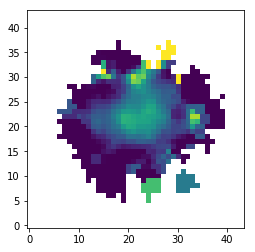

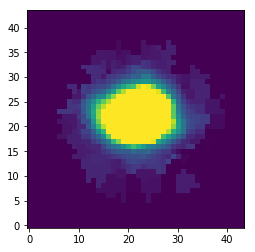

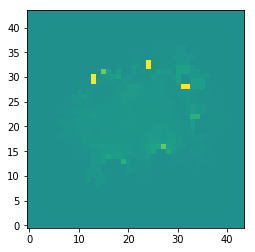

In [49]:
# 检查log计算是否出问题
# 已找到问题：获取的每个spaxel的flux数据可能为0，所以计算log(Oiii/Oii)会出现nan和inf
# 并且某些元素的flux未获取到，所以无效数据=-999

i = 4668
# 每个星系取值
plate = plate_np[i]    # 获取plate
ifu = ifu_np[i]    # 获取ifu
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系位置数组，使用plate&ifu进行定位，得到True False数组
bin_1d = bin1d[galid,:,0][0]    # 获取一维的bin数据
sur_density = sur_density_all[galid][0]

filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
new_maps = Maps(filename=filename)
ha = new_maps.emline_gflux_ha_6564    # 获取Hα
hb = new_maps.emline_gflux_hb_4862    # 获取Hβ
ha_over_hb = ha/hb
nii = new_maps.emline_gflux_nii_6585    # 获取Nii_6584
oii7 = new_maps.emline_gflux_oii_3727    # 获取Oii_3726
oii9 = new_maps.emline_gflux_oii_3729    # 获取Oii_3729
oiii = new_maps.emline_gflux_oiii_5008    # 获取Oiii_5007
    
lg_oiii_oii = np.log10(oiii/(oii7+oii9))
lg_nii_oii = np.log10(nii/(oii7+oii9))
# 简单画图测试
fig, ax = plt.subplots()
p = ax.imshow(lg_nii_oii.value , origin='lower',vmin=0,vmax=1)
print("数组最大值为",np.max(lg_nii_oii.value))


fig, ax = plt.subplots()
p = ax.imshow(nii.value , origin='lower',vmin=0,vmax=1)

lala = ha_over_hb.value
lala[np.where(np.isnan(lala))]=0
lala[np.where(np.isinf(lala))]=0

fig, ax = plt.subplots()
p = ax.imshow(lala , origin='lower',vmin=-100,vmax=100)

print("ha/hb 最大值为 ",np.max(lala))
print("ha/hb 最小值为 ",np.min(lala))

ha/hb 最大值为  0.0
ha/hb 最小值为  0.0


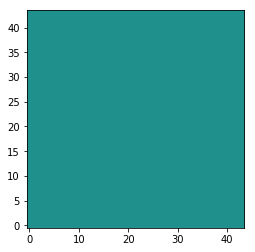

In [44]:
# tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]
lala = ha_over_hb.value
lala[np.argwhere(np.isinf(lala))]= 8


fig, ax = plt.subplots()
p = ax.imshow(lala , origin='lower',vmin=-100,vmax=100)

print("ha/hb 最大值为 ",np.max(lala))
print("ha/hb 最小值为 ",np.min(lala))
# plt.hist(ha_over_hb,bins=50)



### 从manga4675个星系中筛选出符合条件的1222个星系   
---
#### 最终结果数组
>`fra_b_over_a(4675,3)【已按照manga与nsa_v101匹配，结果为4000+星系，使用的是tmp_num_ij数组(nsa_vs_manga)】`   
>>0: 星系的fraDeV   
>>1: 星系的b/a椭圆度   
>>2: 星系筛选计数【=5即为挑选出的星系】  
    
>`num_sel_gal为最终筛选出的星系在原manga数组中的位置`

In [67]:
# 结合筛选出的星系，做出spaxel分布图

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy
from os.path import join
import math
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

new_ra_dec = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')

# 读取nsa与manga的匹配数组
nsa_vs_manga = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_manga.dat")

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic_manga = copy.copy(vac0[1].data)

# load the data of NASA-Sloan catalog v1 0 1
nsa101 = fits.open('/root/cosmos/data/nsa_v1_0_1.fits') 
basic_nsa = nsa101[1].data
nsa_ba = copy.copy(basic_nsa['PETRO_BA90'])
nsa_mass1 = copy.copy(basic_nsa['ELPETRO_MASS'])    #Stellar mass from K-correction fit (use with caution) for elliptical Petrosian fluxes
nsa_mass2 = copy.copy(basic_nsa['SERSIC_MASS'])    #Stellar mass from K-correction fit (use with caution) for Sersic fluxes

# http://skyserver.sdss.org/dr15/en/tools/search/IQS.aspx
# 衡量星系的年龄大小的量 fracDeV<0.7
fracDeV = np.loadtxt('lalala_manga_fradeV.txt')

# https://www.sdss.org/dr12/algorithms/classify/#photo_adaptive
# http://skyserver.sdss.org/dr15/en/help/docs/QS_UserGuide.aspx#SAS
# 筛选倾斜程度，椭圆的长轴短轴为a b
# 计算出每个星系的a b
# b/a>=0.3
#q_u = np.loadtxt('manga_Q_U_4675.txt')
#b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1


#########################################
# 去重
tmp_num_ij = nsa_vs_manga    # 临时存储一下，防止改动
#tmp_num_ij = tmp_num_ij[np.where((old_same_gal[:,0]==1) & (~np.isnan(nsa_ba)) & (tmp_num_ij[:,0]!=-999))]    # 筛选出未重复的星系编号 & 剔除无效数据nan
tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 剔除nsa_b/a无效数据nan
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 将匹配到的有效位置提出，-999为初始值
a,last_num = np.unique(tmp_num_ij[:,0],return_index=True)    # 第一列nsa数据去重
tmp_num_ij = tmp_num_ij[last_num]
#tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列manga数据去重
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)    #最后得到了最终版的nsa_vs_manga数组位置
######################################

b_over_a = nsa_ba[tmp_num_ij[:,0]]    # 根据数组位置提出nsa_b/a
#nsa_mass = nsa_mass1[tmp_num_ij[:,0]]

# 星系质量筛选
# stellar mass > 10^9 太阳质量
#glo_mass_id = basic_manga['PHOTOMETRIC_MASS'] > 10e8
manga_mass = basic_manga['PHOTOMETRIC_MASS']
manga_mass = manga_mass[tmp_num_ij[:,1]]    # 匹配数组维度
#glo_mass_id = glo_mass_id[tmp_num_ij[:,1]]    # 匹配数组维度
glo_mass_id = np.where(manga_mass>1e9)

# 星系star-forming区域筛选
# sfr spaxels >= 20
#plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/plfu_sfr_spaxel.dat")
plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel_v2.0.dat")
plfu_sfr = plfu_sfr[tmp_num_ij[:,1]]    # 匹配数组维度
sfr_id = np.where(plfu_sfr[:,2]>=20)

fra_b_over_a = np.zeros([4675,3])
fra_b_over_a[:,0] = fracDeV
fra_b_over_a = fra_b_over_a[tmp_num_ij[:,1]]
fra_b_over_a[:,1] = b_over_a
manga_id = tmp_num_ij[:,1]

# 开始筛选，在第三列进行判断计数
fra_b_over_a[np.where(fra_b_over_a[:,0]<0.7),2] += 1    # fracDeV筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==1)
print("筛选fracDeV，得到late-type星系个数： ",np.shape(sel_galaxy)[1])

fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # b/a筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==2)
print("筛选fracDeV+初步b/a，得到late-type+不是很倾斜的星系个数： ",np.shape(sel_galaxy)[1])

fra_b_over_a[np.where(glo_mass_id),2] += 1    # 星系总质量筛选
fra_b_over_a[sfr_id,2] += 1    # 星系形成区域筛选

sel_galaxy = np.where(fra_b_over_a[:,2]==4)    # 四次筛选结果

print("不考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")
print("\n替换nair_ba之前，b/a平均值 = ",np.mean(fra_b_over_a[:,1]))


#########################################################
# 第五次筛选：manga与nair匹配的星系中，nair_b/a < manga_b/a

# 读取manga vs nair 匹配数组
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 筛选出未重复的星系编号
#tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)

# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
manga_vs_nair_id = tmp_num_ij    # 最终版的manga_vs_nair
nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a




##################################################################################
# nair_b/a中较小的值
manga_vs_nair_id = manga_vs_nair_id[np.where(nair_ba<=0.71)]    # 数组位置进行同步筛选
nair_ba = nair_ba[np.where(nair_ba<=0.71)]

manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
#manga_id前面已赋值4561个星系，即所在的数组位置信息
k=0
# for 循环将manga_ba的值替换成nair中b/a较小的值
for i in range(0,manga_ba.size):    # 循环nsa
    for j in range(0,nair_ba.size):    # 循环nair
        if (manga_id[i]==manga_vs_nair_id[j,0])&(manga_ba[i] > nair_ba[j]):
        #if (manga_id[i]==manga_vs_nair_id[j,0]):
            #manga_ba[i] = nair_ba[j]
            k+=1
            fra_b_over_a[i,2]+=66
        #if manga_id[i]==manga_vs_nair_id[j,1]:
            #fra_b_over_a[i,2]+=1

fra_b_over_a[:,1] = manga_ba    # 替换完成
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==5)    # 五次筛选结果

# 筛选出的星系的manga数组位置
num_sel_gal = manga_id[sel_galaxy]    # 筛选出的星系的manga数组位置

print("替换nair_ba之后，b/a平均值 = ",np.mean(fra_b_over_a[:,1]))
print("\n考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")
print("\nnair与manga重叠匹配到 ",k," 个星系")

筛选fracDeV，得到late-type星系个数：  2238
筛选fracDeV+初步b/a，得到late-type+不是很倾斜的星系个数：  2103
不考虑nair catalog时： 
已从 manga 4675 个星系中找出  1400  个星系 
距论文中的 1222 个星系还差   178 个

替换nair_ba之前，b/a平均值 =  0.6989220308384543
替换nair_ba之后，b/a平均值 =  0.6989220308384543

考虑nair catalog时： 
已从 manga 4675 个星系中找出  1225  个星系 
距论文中的 1222 个星系还差   3 个

nair与manga重叠匹配到  562  个星系


In [ ]:
# num_sel_gal：筛选得到的接近1222个星系的数组位置
# galid_den_NO：获取的所有的spaxel的数据

# 分别得到 0:星系数组位置，1:质量密度，2:y，3:x
lalala = galid_den_NO[:,[0,3,8,9]]
lala = np.where(lalala[:,0]!=-9999)
lalala = lalala[lala]    # 剔除无效数据【spaxel数据为空】

sel_lalala = np.zeros([lalala[:,0].size,1])    # 计数筛选数组
for i in range(0,num_sel_gal.size):
    id_sel = (num_sel_gal[i]==lalala[:,0])
    #id_sel = (lalala[:,0]==num_sel_gal[i])
    sel_lalala[id_sel] = 1

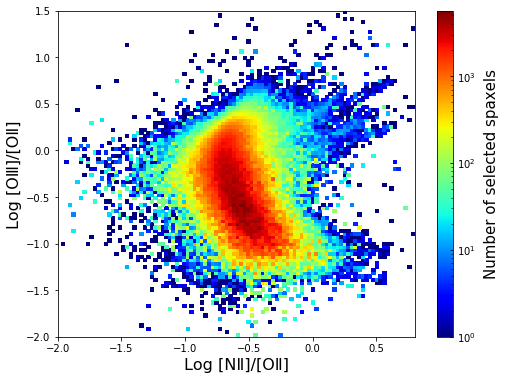

In [194]:
# 画图    
plt_log = lalala[np.where(sel_lalala==1)[0]]
# y
x = plt_log[:,2]
# x
y = plt_log[:,3]
fig = plt.figure(figsize=(8,6)) 
ax1 = fig.add_subplot(111) 
xbins,ybins,hist,cax = ax1.hist2d(x,y,bins=100,range=[[-2,0.8],[-2,1.5]],cmap='jet',norm=mpl.colors.LogNorm()) 
plt.xlabel('Log [NⅡ]/[OⅡ]',fontsize=16)
plt.ylabel('Log [OⅢ]/[OⅡ]',fontsize=16)
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of selected spaxels",fontsize=15,labelpad=8)
plt.show() 
# b = np.argwhere(np.isnan(a[:,8]))
# c = np.unique(a[b,0]).astype(int)
# print(lalala.shape)
# print("max = ",np.max(lalala[:,2]))
# print("min = ",np.min(lalala[:,2]))
# print(lalala[20:40,2])

In [1]:
# 通过BPT筛选，寻找出pure star forming spaxels
#######################################
#######################################
#######################################
import time
import copy
import warnings
from os.path import join

import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from astropy.io import fits
from marvin.tools import Maps

warnings.filterwarnings('ignore')    # 不显示warning信息
vac = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy.copy(vac[1].data)    # galaxy基本信息
# 下载的离线Marvin数据路径
path_marvin_data = '/root/bash_file/marvin_vor10_fits'
# 存储 数组位置, Nii6584,Oiii5007,Oii3729,Oii3726,Oiii/Oii,Nii/Oii 10个量
#galid_den_NO = np.zeros([basic['plate'].size*2800,10],dtype='float32')-9999
galid_den_NO = np.zeros([basic['plate'].size*2800,10])-9999
# surface mass density
sur_density_all = copy.copy(vac['SURFACE_MASS_DENSITY_VORONOI'].data[:,:,0])

bin1d = vac[4].data    # 获取bin_id数组，为了匹配xy坐标位置
bin_2d = vac[5].data    # 获取bin_id数组，为了匹配xy坐标位置

# 获取plate-ifu，为了配合Marvin的包
plate_np = basic['plate']
ifu_np = basic['ifudsgn']
plate_np = plate_np.astype(np.int64)    # 数据转化为整型
#ifu_np = ifu_np.astype(np.int64)    # 数据转化为整型

lalala_start = time.time()    # 开始计时
# for i in range(0,basic['plate'].size):
i = 0    # 星系的数组位置: i
j = 0    # 4675*2800的数组位置: j
#for j in range(0,1):    # 4675*2800的数组位置: j
#while j<4675*2800:
#while j<10:
#while j<basic['plate'].size*sur_density_all[0].size:
# lala=0
# 控制循环最大值
j_end = basic['plate'].size*sur_density_all[0].size
# j_end = 1*sur_density_all[0].size
while j<j_end:
    start_for = time.time()    #获取此次循环开始时间
    
    
    
    # 每个星系取值
    plate = plate_np[i]    # 获取plate
    ifu = ifu_np[i]    # 获取ifu
    galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系位置数组，使用plate&ifu进行定位，得到True False数组
    bin_1d = bin1d[galid,:,0][0]    # 获取一维的bin数据
    sur_density = sur_density_all[galid][0]
    
    filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
    new_maps = Maps(filename=filename)
    ha = new_maps.emline_gflux_ha_6564    # 获取Hα
    nii = new_maps.emline_gflux_nii_6585    # 获取Nii_6584
    oii7 = new_maps.emline_gflux_oii_3727    # 获取Oii_3726
    oii9 = new_maps.emline_gflux_oii_3729    # 获取Oii_3729
    oiii = new_maps.emline_gflux_oiii_5008    # 获取Oiii_5007
    
    lg_oiii_oii = np.log10(oiii/(oii7+oii9))
    lg_nii_oii = np.log10(nii/(oii7+oii9))
    
    
    
    # 计算金属丰度
    RR = (oii7+oii9) / nii    # Oii/Nii
    
    # 计算mask
    masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
    mask_non_sf = ~masks_bpt['sf']['global'] * RR.pixmask.labels_to_value('DONOTUSE')
    mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 10.    #信噪比设定为10
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_oii7_low_snr = (np.abs(oii7.value * np.sqrt(oii7.ivar)) < min_snr)
    mask_oii9_low_snr = (np.abs(oii9.value * np.sqrt(oii9.ivar)) < min_snr)
    mask_oiii_low_snr = (np.abs(oiii.value * np.sqrt(oiii.ivar)) < min_snr)

    new_mask = mask_non_sf | mask_bad_data | mask_ha_low_snr| mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr| mask_oiii_low_snr     # 得到最后的mask
    #print("BPT分类得到的mask矩阵大小为",new_mask.shape)
    # star forming spaxel 个数
    #num_sfr = np.argwhere(lala1_sfr==0).size/2
        
    # 每个spaxel取值
    image_sz = np.shape(nii)[0]    # 图像边长
    # 临时测试，画图数组
    #print("原图像大小为： ",image_sz,'*',image_sz)
    #maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
    for y in range(0,image_sz):
        for x in range(0,image_sz):
            id_bin = (bin_1d==bin_2d[galid,y,x])    # 搜索二维bin的值在一维bin数组中的位置
            
            if (len(bin_1d[id_bin])==1)&(new_mask[y,x]==0):    # 挑选出 一维2800的bin和二维76*76的bin相同的数值，以及sf的spaxel
            #if (len(bin_1d[id_bin])==1):
                # spaxel所在的星系的数组位置
                galid_den_NO[j,0] = i
                # spaxel在2800数组中的位置，即bin_1d
                #galid_den_NO[j,1] = id_bin
                # 星系中的y位置
                galid_den_NO[j,1] = y
                # 星系中的x位置
                galid_den_NO[j,2] = x
                # spaxel's surface mass density
                galid_den_NO[j,3] = sur_density[id_bin]
                # nii 6584
                galid_den_NO[j,4] = nii.value[y,x]
                # oiii 5007
                galid_den_NO[j,5] = oiii.value[y,x]
                # oii 3729
                galid_den_NO[j,6] = oii9.value[y,x]
                # oii 3726
                galid_den_NO[j,7] = oii7.value[y,x]
                # log(Oiii/Oii)
                galid_den_NO[j,8] = lg_oiii_oii.value[y,x]
                # log(nii/Oii)
                galid_den_NO[j,9] = lg_nii_oii.value[y,x]
               
                j+=1
                
                #maps[y,x] = oii7.value[y,x]    # 临时测试，画图数组
                

    
    
    end_for = time.time()    # 获取此次循环结束时间
    print('用时: ',end_for-start_for,"  已经计算到第 ",i+1," 个星系   ","剩余 ",4675-i-1,' 个星系')
    
    # 跳过无效数据，直接进入下一个星系
    i += 1
    j = i*2800-1
    
    # 临时测试
    #print("j = ",j)
    #print("j与上一次的差值 = ",j-lala)
    #lala =j
    
    # 限制循环次数，防止超过数组实际大小
    if j>=j_end-1:
        break
    
    
lalala_end = time.time()
print('\n\n\n总用时： ',str(lalala_end-lalala_start))

# 将得到的结果进行保存 (4675*2800,10)
# 无效数据为-9999
np.savetxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/galid_ij_den_NO_logOiiioii_logniioii_star_forming.dat", galid_den_NO)               

# # 简单画图测试
# fig, ax = plt.subplots()
# p = ax.imshow(maps , origin='lower',vmin=0,vmax=1)

                

INFO: No release version set. Setting default to DR15
用时:  2.590033769607544   已经计算到第  1  个星系    剩余  4674  个星系
用时:  2.022608757019043   已经计算到第  2  个星系    剩余  4673  个星系
用时:  1.9217097759246826   已经计算到第  3  个星系    剩余  4672  个星系
用时:  1.694995641708374   已经计算到第  4  个星系    剩余  4671  个星系
用时:  1.8703455924987793   已经计算到第  5  个星系    剩余  4670  个星系
用时:  1.9059333801269531   已经计算到第  6  个星系    剩余  4669  个星系
用时:  1.930084228515625   已经计算到第  7  个星系    剩余  4668  个星系
用时:  2.161736011505127   已经计算到第  8  个星系    剩余  4667  个星系
用时:  1.6883385181427002   已经计算到第  9  个星系    剩余  4666  个星系
用时:  2.025678873062134   已经计算到第  10  个星系    剩余  4665  个星系
用时:  1.9047815799713135   已经计算到第  11  个星系    剩余  4664  个星系
用时:  1.7408454418182373   已经计算到第  12  个星系    剩余  4663  个星系
用时:  1.927830696105957   已经计算到第  13  个星系    剩余  4662  个星系
用时:  2.217090129852295   已经计算到第  14  个星系    剩余  4661  个星系
用时:  2.0100293159484863   已经计算到第  15  个星系    剩余  4660  个星系
用时:  2.0606706142425537   已经计算到第  16  个星系    剩余  4659  个星系
用时:  2.207671165466

用时:  2.0536913871765137   已经计算到第  140  个星系    剩余  4535  个星系
用时:  1.7036421298980713   已经计算到第  141  个星系    剩余  4534  个星系
用时:  1.7434861660003662   已经计算到第  142  个星系    剩余  4533  个星系
用时:  2.061506748199463   已经计算到第  143  个星系    剩余  4532  个星系
用时:  1.6464331150054932   已经计算到第  144  个星系    剩余  4531  个星系
用时:  1.8969314098358154   已经计算到第  145  个星系    剩余  4530  个星系
用时:  2.0842111110687256   已经计算到第  146  个星系    剩余  4529  个星系
用时:  2.005905866622925   已经计算到第  147  个星系    剩余  4528  个星系
用时:  2.022278070449829   已经计算到第  148  个星系    剩余  4527  个星系
用时:  2.1833701133728027   已经计算到第  149  个星系    剩余  4526  个星系
用时:  1.8340647220611572   已经计算到第  150  个星系    剩余  4525  个星系
用时:  1.966972827911377   已经计算到第  151  个星系    剩余  4524  个星系
用时:  1.9024791717529297   已经计算到第  152  个星系    剩余  4523  个星系
用时:  2.1300129890441895   已经计算到第  153  个星系    剩余  4522  个星系
用时:  2.336305618286133   已经计算到第  154  个星系    剩余  4521  个星系
用时:  2.07788348197937   已经计算到第  155  个星系    剩余  4520  个星系
用时:  1.9446053504943848   已经计算到第  156  个星系    剩

用时:  2.2586097717285156   已经计算到第  278  个星系    剩余  4397  个星系
用时:  1.7695269584655762   已经计算到第  279  个星系    剩余  4396  个星系
用时:  2.065164566040039   已经计算到第  280  个星系    剩余  4395  个星系
用时:  1.9687387943267822   已经计算到第  281  个星系    剩余  4394  个星系
用时:  1.8336255550384521   已经计算到第  282  个星系    剩余  4393  个星系
用时:  2.1951489448547363   已经计算到第  283  个星系    剩余  4392  个星系
用时:  1.872572660446167   已经计算到第  284  个星系    剩余  4391  个星系
用时:  1.8922958374023438   已经计算到第  285  个星系    剩余  4390  个星系
用时:  2.423351764678955   已经计算到第  286  个星系    剩余  4389  个星系
用时:  1.8459548950195312   已经计算到第  287  个星系    剩余  4388  个星系
用时:  2.0297510623931885   已经计算到第  288  个星系    剩余  4387  个星系
用时:  1.9784939289093018   已经计算到第  289  个星系    剩余  4386  个星系
用时:  2.1069624423980713   已经计算到第  290  个星系    剩余  4385  个星系
用时:  1.730334758758545   已经计算到第  291  个星系    剩余  4384  个星系
用时:  2.0115108489990234   已经计算到第  292  个星系    剩余  4383  个星系
用时:  1.9988360404968262   已经计算到第  293  个星系    剩余  4382  个星系
用时:  1.9016170501708984   已经计算到第  294  个星系  

用时:  2.2296950817108154   已经计算到第  416  个星系    剩余  4259  个星系
用时:  2.0768673419952393   已经计算到第  417  个星系    剩余  4258  个星系
用时:  2.0987467765808105   已经计算到第  418  个星系    剩余  4257  个星系
用时:  1.7911179065704346   已经计算到第  419  个星系    剩余  4256  个星系
用时:  1.8996236324310303   已经计算到第  420  个星系    剩余  4255  个星系
用时:  2.04937744140625   已经计算到第  421  个星系    剩余  4254  个星系
用时:  1.8481173515319824   已经计算到第  422  个星系    剩余  4253  个星系
用时:  1.8880057334899902   已经计算到第  423  个星系    剩余  4252  个星系
用时:  2.2769556045532227   已经计算到第  424  个星系    剩余  4251  个星系
用时:  2.0614001750946045   已经计算到第  425  个星系    剩余  4250  个星系
用时:  2.1425869464874268   已经计算到第  426  个星系    剩余  4249  个星系
用时:  1.7117455005645752   已经计算到第  427  个星系    剩余  4248  个星系
用时:  1.7817745208740234   已经计算到第  428  个星系    剩余  4247  个星系
用时:  2.1114158630371094   已经计算到第  429  个星系    剩余  4246  个星系
用时:  1.9818952083587646   已经计算到第  430  个星系    剩余  4245  个星系
用时:  1.6651990413665771   已经计算到第  431  个星系    剩余  4244  个星系
用时:  2.1634016036987305   已经计算到第  432  个星系

用时:  1.8622972965240479   已经计算到第  554  个星系    剩余  4121  个星系
用时:  2.1964335441589355   已经计算到第  555  个星系    剩余  4120  个星系
用时:  2.000075340270996   已经计算到第  556  个星系    剩余  4119  个星系
用时:  1.7782490253448486   已经计算到第  557  个星系    剩余  4118  个星系
用时:  1.9568767547607422   已经计算到第  558  个星系    剩余  4117  个星系
用时:  2.018712043762207   已经计算到第  559  个星系    剩余  4116  个星系
用时:  1.8568005561828613   已经计算到第  560  个星系    剩余  4115  个星系
用时:  2.0413320064544678   已经计算到第  561  个星系    剩余  4114  个星系
用时:  1.9108505249023438   已经计算到第  562  个星系    剩余  4113  个星系
用时:  1.8375015258789062   已经计算到第  563  个星系    剩余  4112  个星系
用时:  2.4181904792785645   已经计算到第  564  个星系    剩余  4111  个星系
用时:  2.117067337036133   已经计算到第  565  个星系    剩余  4110  个星系
用时:  2.132249593734741   已经计算到第  566  个星系    剩余  4109  个星系
用时:  2.1163089275360107   已经计算到第  567  个星系    剩余  4108  个星系
用时:  1.6921377182006836   已经计算到第  568  个星系    剩余  4107  个星系
用时:  1.9185593128204346   已经计算到第  569  个星系    剩余  4106  个星系
用时:  2.1574387550354004   已经计算到第  570  个星系  

用时:  1.6776182651519775   已经计算到第  692  个星系    剩余  3983  个星系
用时:  1.9366748332977295   已经计算到第  693  个星系    剩余  3982  个星系
用时:  1.66310453414917   已经计算到第  694  个星系    剩余  3981  个星系
用时:  2.073500633239746   已经计算到第  695  个星系    剩余  3980  个星系
用时:  2.114288568496704   已经计算到第  696  个星系    剩余  3979  个星系
用时:  1.9935972690582275   已经计算到第  697  个星系    剩余  3978  个星系
用时:  1.7479605674743652   已经计算到第  698  个星系    剩余  3977  个星系
用时:  2.0050289630889893   已经计算到第  699  个星系    剩余  3976  个星系
用时:  2.051419258117676   已经计算到第  700  个星系    剩余  3975  个星系
用时:  2.1071200370788574   已经计算到第  701  个星系    剩余  3974  个星系
用时:  2.1696622371673584   已经计算到第  702  个星系    剩余  3973  个星系
用时:  1.9313383102416992   已经计算到第  703  个星系    剩余  3972  个星系
用时:  2.489835739135742   已经计算到第  704  个星系    剩余  3971  个星系
用时:  1.9141113758087158   已经计算到第  705  个星系    剩余  3970  个星系
用时:  1.9896645545959473   已经计算到第  706  个星系    剩余  3969  个星系
用时:  1.979257345199585   已经计算到第  707  个星系    剩余  3968  个星系
用时:  1.8856091499328613   已经计算到第  708  个星系    剩

用时:  2.1070568561553955   已经计算到第  830  个星系    剩余  3845  个星系
用时:  2.4425861835479736   已经计算到第  831  个星系    剩余  3844  个星系
用时:  1.9953997135162354   已经计算到第  832  个星系    剩余  3843  个星系
用时:  2.1940486431121826   已经计算到第  833  个星系    剩余  3842  个星系
用时:  1.6469264030456543   已经计算到第  834  个星系    剩余  3841  个星系
用时:  1.7528126239776611   已经计算到第  835  个星系    剩余  3840  个星系
用时:  2.0710701942443848   已经计算到第  836  个星系    剩余  3839  个星系
用时:  2.0419349670410156   已经计算到第  837  个星系    剩余  3838  个星系
用时:  1.7004129886627197   已经计算到第  838  个星系    剩余  3837  个星系
用时:  2.2949442863464355   已经计算到第  839  个星系    剩余  3836  个星系
用时:  1.9169118404388428   已经计算到第  840  个星系    剩余  3835  个星系
用时:  1.6681914329528809   已经计算到第  841  个星系    剩余  3834  个星系
用时:  2.2338221073150635   已经计算到第  842  个星系    剩余  3833  个星系
用时:  2.0440900325775146   已经计算到第  843  个星系    剩余  3832  个星系
用时:  2.072948694229126   已经计算到第  844  个星系    剩余  3831  个星系
用时:  1.9290552139282227   已经计算到第  845  个星系    剩余  3830  个星系
用时:  2.173665761947632   已经计算到第  846  个星系

用时:  1.8999063968658447   已经计算到第  968  个星系    剩余  3707  个星系
用时:  1.8160984516143799   已经计算到第  969  个星系    剩余  3706  个星系
用时:  2.144914388656616   已经计算到第  970  个星系    剩余  3705  个星系
用时:  1.9556198120117188   已经计算到第  971  个星系    剩余  3704  个星系
用时:  1.930556058883667   已经计算到第  972  个星系    剩余  3703  个星系
用时:  1.9042305946350098   已经计算到第  973  个星系    剩余  3702  个星系
用时:  1.8628261089324951   已经计算到第  974  个星系    剩余  3701  个星系
用时:  1.8509373664855957   已经计算到第  975  个星系    剩余  3700  个星系
用时:  1.9565374851226807   已经计算到第  976  个星系    剩余  3699  个星系
用时:  1.808978796005249   已经计算到第  977  个星系    剩余  3698  个星系
用时:  1.843385934829712   已经计算到第  978  个星系    剩余  3697  个星系
用时:  2.267014980316162   已经计算到第  979  个星系    剩余  3696  个星系
用时:  2.036299228668213   已经计算到第  980  个星系    剩余  3695  个星系
用时:  2.0885000228881836   已经计算到第  981  个星系    剩余  3694  个星系
用时:  2.124116897583008   已经计算到第  982  个星系    剩余  3693  个星系
用时:  1.746077537536621   已经计算到第  983  个星系    剩余  3692  个星系
用时:  1.798064947128296   已经计算到第  984  个星系    剩余 

用时:  1.7700397968292236   已经计算到第  1104  个星系    剩余  3571  个星系
用时:  2.099302053451538   已经计算到第  1105  个星系    剩余  3570  个星系
用时:  2.1143689155578613   已经计算到第  1106  个星系    剩余  3569  个星系
用时:  1.8013150691986084   已经计算到第  1107  个星系    剩余  3568  个星系
用时:  2.2195754051208496   已经计算到第  1108  个星系    剩余  3567  个星系
用时:  2.2035365104675293   已经计算到第  1109  个星系    剩余  3566  个星系
用时:  1.9914824962615967   已经计算到第  1110  个星系    剩余  3565  个星系
用时:  1.917241096496582   已经计算到第  1111  个星系    剩余  3564  个星系
用时:  1.7448029518127441   已经计算到第  1112  个星系    剩余  3563  个星系
用时:  1.7391624450683594   已经计算到第  1113  个星系    剩余  3562  个星系
用时:  2.344210386276245   已经计算到第  1114  个星系    剩余  3561  个星系
用时:  2.156811237335205   已经计算到第  1115  个星系    剩余  3560  个星系
用时:  1.9575636386871338   已经计算到第  1116  个星系    剩余  3559  个星系
用时:  2.1318325996398926   已经计算到第  1117  个星系    剩余  3558  个星系
用时:  1.7564117908477783   已经计算到第  1118  个星系    剩余  3557  个星系
用时:  2.102013111114502   已经计算到第  1119  个星系    剩余  3556  个星系
用时:  1.9651198387145996   已经计

用时:  2.0079996585845947   已经计算到第  1240  个星系    剩余  3435  个星系
用时:  1.7294371128082275   已经计算到第  1241  个星系    剩余  3434  个星系
用时:  1.765636682510376   已经计算到第  1242  个星系    剩余  3433  个星系
用时:  2.3409554958343506   已经计算到第  1243  个星系    剩余  3432  个星系
用时:  1.765634536743164   已经计算到第  1244  个星系    剩余  3431  个星系
用时:  1.8906962871551514   已经计算到第  1245  个星系    剩余  3430  个星系
用时:  2.272531747817993   已经计算到第  1246  个星系    剩余  3429  个星系
用时:  1.9410645961761475   已经计算到第  1247  个星系    剩余  3428  个星系
用时:  2.035912275314331   已经计算到第  1248  个星系    剩余  3427  个星系
用时:  2.0940277576446533   已经计算到第  1249  个星系    剩余  3426  个星系
用时:  2.254796266555786   已经计算到第  1250  个星系    剩余  3425  个星系
用时:  2.2882535457611084   已经计算到第  1251  个星系    剩余  3424  个星系
用时:  1.8022546768188477   已经计算到第  1252  个星系    剩余  3423  个星系
用时:  1.9479689598083496   已经计算到第  1253  个星系    剩余  3422  个星系
用时:  2.06667423248291   已经计算到第  1254  个星系    剩余  3421  个星系
用时:  2.3101136684417725   已经计算到第  1255  个星系    剩余  3420  个星系
用时:  1.9426043033599854   已经计算到

用时:  1.9295496940612793   已经计算到第  1376  个星系    剩余  3299  个星系
用时:  1.7531516551971436   已经计算到第  1377  个星系    剩余  3298  个星系
用时:  1.878176212310791   已经计算到第  1378  个星系    剩余  3297  个星系
用时:  2.1115870475769043   已经计算到第  1379  个星系    剩余  3296  个星系
用时:  2.1524736881256104   已经计算到第  1380  个星系    剩余  3295  个星系
用时:  2.0186545848846436   已经计算到第  1381  个星系    剩余  3294  个星系
用时:  1.962888479232788   已经计算到第  1382  个星系    剩余  3293  个星系
用时:  2.1893017292022705   已经计算到第  1383  个星系    剩余  3292  个星系
用时:  1.9410274028778076   已经计算到第  1384  个星系    剩余  3291  个星系
用时:  1.8222625255584717   已经计算到第  1385  个星系    剩余  3290  个星系
用时:  2.209413528442383   已经计算到第  1386  个星系    剩余  3289  个星系
用时:  1.7793049812316895   已经计算到第  1387  个星系    剩余  3288  个星系
用时:  2.1347718238830566   已经计算到第  1388  个星系    剩余  3287  个星系
用时:  1.9306912422180176   已经计算到第  1389  个星系    剩余  3286  个星系
用时:  2.028575897216797   已经计算到第  1390  个星系    剩余  3285  个星系
用时:  1.902275800704956   已经计算到第  1391  个星系    剩余  3284  个星系
用时:  2.3708202838897705   已经计

用时:  2.112382411956787   已经计算到第  1511  个星系    剩余  3164  个星系
用时:  1.8235247135162354   已经计算到第  1512  个星系    剩余  3163  个星系
用时:  2.062838315963745   已经计算到第  1513  个星系    剩余  3162  个星系
用时:  2.122602939605713   已经计算到第  1514  个星系    剩余  3161  个星系
用时:  2.2488770484924316   已经计算到第  1515  个星系    剩余  3160  个星系
用时:  2.0895636081695557   已经计算到第  1516  个星系    剩余  3159  个星系
用时:  1.8678195476531982   已经计算到第  1517  个星系    剩余  3158  个星系
用时:  2.2036843299865723   已经计算到第  1518  个星系    剩余  3157  个星系
用时:  2.348717451095581   已经计算到第  1519  个星系    剩余  3156  个星系
用时:  1.821728229522705   已经计算到第  1520  个星系    剩余  3155  个星系
用时:  1.966243028640747   已经计算到第  1521  个星系    剩余  3154  个星系
用时:  1.8244895935058594   已经计算到第  1522  个星系    剩余  3153  个星系
用时:  1.8158338069915771   已经计算到第  1523  个星系    剩余  3152  个星系
用时:  1.8929882049560547   已经计算到第  1524  个星系    剩余  3151  个星系
用时:  1.8488645553588867   已经计算到第  1525  个星系    剩余  3150  个星系
用时:  2.103858232498169   已经计算到第  1526  个星系    剩余  3149  个星系
用时:  1.9661414623260498   已经计算到

用时:  2.2309529781341553   已经计算到第  1646  个星系    剩余  3029  个星系
用时:  2.4966068267822266   已经计算到第  1647  个星系    剩余  3028  个星系
用时:  1.7556381225585938   已经计算到第  1648  个星系    剩余  3027  个星系
用时:  1.8213629722595215   已经计算到第  1649  个星系    剩余  3026  个星系
用时:  2.036952257156372   已经计算到第  1650  个星系    剩余  3025  个星系
用时:  1.9883439540863037   已经计算到第  1651  个星系    剩余  3024  个星系
用时:  1.9670593738555908   已经计算到第  1652  个星系    剩余  3023  个星系
用时:  1.9282355308532715   已经计算到第  1653  个星系    剩余  3022  个星系
用时:  1.720428705215454   已经计算到第  1654  个星系    剩余  3021  个星系
用时:  2.0237910747528076   已经计算到第  1655  个星系    剩余  3020  个星系
用时:  2.0246169567108154   已经计算到第  1656  个星系    剩余  3019  个星系
用时:  2.046299934387207   已经计算到第  1657  个星系    剩余  3018  个星系
用时:  2.170036792755127   已经计算到第  1658  个星系    剩余  3017  个星系
用时:  2.0591704845428467   已经计算到第  1659  个星系    剩余  3016  个星系
用时:  1.9408586025238037   已经计算到第  1660  个星系    剩余  3015  个星系
用时:  2.3904638290405273   已经计算到第  1661  个星系    剩余  3014  个星系
用时:  2.074399948120117   已经计

用时:  2.131526231765747   已经计算到第  1782  个星系    剩余  2893  个星系
用时:  1.7729816436767578   已经计算到第  1783  个星系    剩余  2892  个星系
用时:  2.226498603820801   已经计算到第  1784  个星系    剩余  2891  个星系
用时:  2.177929162979126   已经计算到第  1785  个星系    剩余  2890  个星系
用时:  1.7220954895019531   已经计算到第  1786  个星系    剩余  2889  个星系
用时:  1.7714531421661377   已经计算到第  1787  个星系    剩余  2888  个星系
用时:  2.1531975269317627   已经计算到第  1788  个星系    剩余  2887  个星系
用时:  1.8272411823272705   已经计算到第  1789  个星系    剩余  2886  个星系
用时:  1.9003665447235107   已经计算到第  1790  个星系    剩余  2885  个星系
用时:  1.980337381362915   已经计算到第  1791  个星系    剩余  2884  个星系
用时:  1.6694855690002441   已经计算到第  1792  个星系    剩余  2883  个星系
用时:  2.0860588550567627   已经计算到第  1793  个星系    剩余  2882  个星系
用时:  2.0449256896972656   已经计算到第  1794  个星系    剩余  2881  个星系
用时:  2.132280111312866   已经计算到第  1795  个星系    剩余  2880  个星系
用时:  2.5702807903289795   已经计算到第  1796  个星系    剩余  2879  个星系
用时:  2.097210645675659   已经计算到第  1797  个星系    剩余  2878  个星系
用时:  1.7185449600219727   已经计算

用时:  2.130427122116089   已经计算到第  1918  个星系    剩余  2757  个星系
用时:  1.8536806106567383   已经计算到第  1919  个星系    剩余  2756  个星系
用时:  2.0274240970611572   已经计算到第  1920  个星系    剩余  2755  个星系
用时:  1.9383666515350342   已经计算到第  1921  个星系    剩余  2754  个星系
用时:  1.8786225318908691   已经计算到第  1922  个星系    剩余  2753  个星系
用时:  1.8624086380004883   已经计算到第  1923  个星系    剩余  2752  个星系
用时:  1.8685240745544434   已经计算到第  1924  个星系    剩余  2751  个星系
用时:  2.0372843742370605   已经计算到第  1925  个星系    剩余  2750  个星系
用时:  2.2508106231689453   已经计算到第  1926  个星系    剩余  2749  个星系
用时:  2.087839126586914   已经计算到第  1927  个星系    剩余  2748  个星系
用时:  1.872180700302124   已经计算到第  1928  个星系    剩余  2747  个星系
用时:  2.0631237030029297   已经计算到第  1929  个星系    剩余  2746  个星系
用时:  1.8334195613861084   已经计算到第  1930  个星系    剩余  2745  个星系
用时:  1.9732141494750977   已经计算到第  1931  个星系    剩余  2744  个星系
用时:  2.019458770751953   已经计算到第  1932  个星系    剩余  2743  个星系
用时:  2.2612287998199463   已经计算到第  1933  个星系    剩余  2742  个星系
用时:  2.0145857334136963   已经

用时:  2.210899591445923   已经计算到第  2054  个星系    剩余  2621  个星系
用时:  1.6528213024139404   已经计算到第  2055  个星系    剩余  2620  个星系
用时:  2.126680374145508   已经计算到第  2056  个星系    剩余  2619  个星系
用时:  2.0078210830688477   已经计算到第  2057  个星系    剩余  2618  个星系
用时:  1.8010096549987793   已经计算到第  2058  个星系    剩余  2617  个星系
用时:  1.782637119293213   已经计算到第  2059  个星系    剩余  2616  个星系
用时:  2.4043197631835938   已经计算到第  2060  个星系    剩余  2615  个星系
用时:  1.7661762237548828   已经计算到第  2061  个星系    剩余  2614  个星系
用时:  1.8095922470092773   已经计算到第  2062  个星系    剩余  2613  个星系
用时:  2.0209298133850098   已经计算到第  2063  个星系    剩余  2612  个星系
用时:  1.964834213256836   已经计算到第  2064  个星系    剩余  2611  个星系
用时:  2.2362704277038574   已经计算到第  2065  个星系    剩余  2610  个星系
用时:  1.982466459274292   已经计算到第  2066  个星系    剩余  2609  个星系
用时:  1.8737072944641113   已经计算到第  2067  个星系    剩余  2608  个星系
用时:  1.841320276260376   已经计算到第  2068  个星系    剩余  2607  个星系
用时:  1.8406963348388672   已经计算到第  2069  个星系    剩余  2606  个星系
用时:  1.9405734539031982   已经计算

用时:  1.7424328327178955   已经计算到第  2190  个星系    剩余  2485  个星系
用时:  1.7081902027130127   已经计算到第  2191  个星系    剩余  2484  个星系
用时:  1.8656268119812012   已经计算到第  2192  个星系    剩余  2483  个星系
用时:  2.1387150287628174   已经计算到第  2193  个星系    剩余  2482  个星系
用时:  1.8222999572753906   已经计算到第  2194  个星系    剩余  2481  个星系
用时:  2.0347535610198975   已经计算到第  2195  个星系    剩余  2480  个星系
用时:  1.8688123226165771   已经计算到第  2196  个星系    剩余  2479  个星系
用时:  2.2218735218048096   已经计算到第  2197  个星系    剩余  2478  个星系
用时:  2.1065785884857178   已经计算到第  2198  个星系    剩余  2477  个星系
用时:  1.942033052444458   已经计算到第  2199  个星系    剩余  2476  个星系
用时:  2.33773136138916   已经计算到第  2200  个星系    剩余  2475  个星系
用时:  1.7511603832244873   已经计算到第  2201  个星系    剩余  2474  个星系
用时:  1.7001874446868896   已经计算到第  2202  个星系    剩余  2473  个星系
用时:  2.0308728218078613   已经计算到第  2203  个星系    剩余  2472  个星系
用时:  1.814138650894165   已经计算到第  2204  个星系    剩余  2471  个星系
用时:  1.8886117935180664   已经计算到第  2205  个星系    剩余  2470  个星系
用时:  2.5099070072174072   已经

用时:  1.9970991611480713   已经计算到第  2326  个星系    剩余  2349  个星系
用时:  2.044055461883545   已经计算到第  2327  个星系    剩余  2348  个星系
用时:  1.872837781906128   已经计算到第  2328  个星系    剩余  2347  个星系
用时:  2.1598222255706787   已经计算到第  2329  个星系    剩余  2346  个星系
用时:  2.1075291633605957   已经计算到第  2330  个星系    剩余  2345  个星系
用时:  1.71995210647583   已经计算到第  2331  个星系    剩余  2344  个星系
用时:  1.926816463470459   已经计算到第  2332  个星系    剩余  2343  个星系
用时:  2.139612913131714   已经计算到第  2333  个星系    剩余  2342  个星系
用时:  2.052164077758789   已经计算到第  2334  个星系    剩余  2341  个星系
用时:  2.1950063705444336   已经计算到第  2335  个星系    剩余  2340  个星系
用时:  2.253796339035034   已经计算到第  2336  个星系    剩余  2339  个星系
用时:  1.809241771697998   已经计算到第  2337  个星系    剩余  2338  个星系
用时:  1.8935835361480713   已经计算到第  2338  个星系    剩余  2337  个星系
用时:  1.899811029434204   已经计算到第  2339  个星系    剩余  2336  个星系
用时:  1.9744651317596436   已经计算到第  2340  个星系    剩余  2335  个星系
用时:  1.7262284755706787   已经计算到第  2341  个星系    剩余  2334  个星系
用时:  1.8328514099121094   已经计算到第  

用时:  1.9570138454437256   已经计算到第  2462  个星系    剩余  2213  个星系
用时:  1.869250774383545   已经计算到第  2463  个星系    剩余  2212  个星系
用时:  2.2344915866851807   已经计算到第  2464  个星系    剩余  2211  个星系
用时:  1.6660242080688477   已经计算到第  2465  个星系    剩余  2210  个星系
用时:  1.9067590236663818   已经计算到第  2466  个星系    剩余  2209  个星系
用时:  2.0547068119049072   已经计算到第  2467  个星系    剩余  2208  个星系
用时:  2.2266836166381836   已经计算到第  2468  个星系    剩余  2207  个星系
用时:  1.8179738521575928   已经计算到第  2469  个星系    剩余  2206  个星系
用时:  1.8599848747253418   已经计算到第  2470  个星系    剩余  2205  个星系
用时:  1.6868202686309814   已经计算到第  2471  个星系    剩余  2204  个星系
用时:  2.2559778690338135   已经计算到第  2472  个星系    剩余  2203  个星系
用时:  1.828977108001709   已经计算到第  2473  个星系    剩余  2202  个星系
用时:  1.8258380889892578   已经计算到第  2474  个星系    剩余  2201  个星系
用时:  1.8305575847625732   已经计算到第  2475  个星系    剩余  2200  个星系
用时:  1.6929266452789307   已经计算到第  2476  个星系    剩余  2199  个星系
用时:  2.100374460220337   已经计算到第  2477  个星系    剩余  2198  个星系
用时:  1.923433542251587   已经

用时:  1.7964496612548828   已经计算到第  2598  个星系    剩余  2077  个星系
用时:  2.0052168369293213   已经计算到第  2599  个星系    剩余  2076  个星系
用时:  2.063826084136963   已经计算到第  2600  个星系    剩余  2075  个星系
用时:  1.913388729095459   已经计算到第  2601  个星系    剩余  2074  个星系
用时:  2.0037758350372314   已经计算到第  2602  个星系    剩余  2073  个星系
用时:  1.6839065551757812   已经计算到第  2603  个星系    剩余  2072  个星系
用时:  2.054701566696167   已经计算到第  2604  个星系    剩余  2071  个星系
用时:  1.8341467380523682   已经计算到第  2605  个星系    剩余  2070  个星系
用时:  2.0242910385131836   已经计算到第  2606  个星系    剩余  2069  个星系
用时:  2.1017091274261475   已经计算到第  2607  个星系    剩余  2068  个星系
用时:  2.044053554534912   已经计算到第  2608  个星系    剩余  2067  个星系
用时:  2.001927137374878   已经计算到第  2609  个星系    剩余  2066  个星系
用时:  2.1405253410339355   已经计算到第  2610  个星系    剩余  2065  个星系
用时:  1.7240829467773438   已经计算到第  2611  个星系    剩余  2064  个星系
用时:  1.9028475284576416   已经计算到第  2612  个星系    剩余  2063  个星系
用时:  2.221318483352661   已经计算到第  2613  个星系    剩余  2062  个星系
用时:  1.733637809753418   已经计算到

用时:  1.7333178520202637   已经计算到第  2733  个星系    剩余  1942  个星系
用时:  2.105898380279541   已经计算到第  2734  个星系    剩余  1941  个星系
用时:  1.718395709991455   已经计算到第  2735  个星系    剩余  1940  个星系
用时:  2.1912765502929688   已经计算到第  2736  个星系    剩余  1939  个星系
用时:  2.1473090648651123   已经计算到第  2737  个星系    剩余  1938  个星系
用时:  2.258882522583008   已经计算到第  2738  个星系    剩余  1937  个星系
用时:  1.8497827053070068   已经计算到第  2739  个星系    剩余  1936  个星系
用时:  1.8679499626159668   已经计算到第  2740  个星系    剩余  1935  个星系
用时:  1.975881814956665   已经计算到第  2741  个星系    剩余  1934  个星系
用时:  1.8785347938537598   已经计算到第  2742  个星系    剩余  1933  个星系
用时:  2.1171762943267822   已经计算到第  2743  个星系    剩余  1932  个星系
用时:  2.0768589973449707   已经计算到第  2744  个星系    剩余  1931  个星系
用时:  2.059823989868164   已经计算到第  2745  个星系    剩余  1930  个星系
用时:  1.7298870086669922   已经计算到第  2746  个星系    剩余  1929  个星系
用时:  2.051668643951416   已经计算到第  2747  个星系    剩余  1928  个星系
用时:  1.8948051929473877   已经计算到第  2748  个星系    剩余  1927  个星系
用时:  1.7989373207092285   已经计算

用时:  2.0257625579833984   已经计算到第  2869  个星系    剩余  1806  个星系
用时:  1.9033942222595215   已经计算到第  2870  个星系    剩余  1805  个星系
用时:  2.38213849067688   已经计算到第  2871  个星系    剩余  1804  个星系
用时:  2.118298053741455   已经计算到第  2872  个星系    剩余  1803  个星系
用时:  2.0515780448913574   已经计算到第  2873  个星系    剩余  1802  个星系
用时:  2.1866142749786377   已经计算到第  2874  个星系    剩余  1801  个星系
用时:  1.8227193355560303   已经计算到第  2875  个星系    剩余  1800  个星系
用时:  1.708583116531372   已经计算到第  2876  个星系    剩余  1799  个星系
用时:  2.3352444171905518   已经计算到第  2877  个星系    剩余  1798  个星系
用时:  1.8784513473510742   已经计算到第  2878  个星系    剩余  1797  个星系
用时:  2.075247287750244   已经计算到第  2879  个星系    剩余  1796  个星系
用时:  1.9289207458496094   已经计算到第  2880  个星系    剩余  1795  个星系
用时:  1.7552146911621094   已经计算到第  2881  个星系    剩余  1794  个星系
用时:  2.0647120475769043   已经计算到第  2882  个星系    剩余  1793  个星系
用时:  2.0447118282318115   已经计算到第  2883  个星系    剩余  1792  个星系
用时:  1.672546148300171   已经计算到第  2884  个星系    剩余  1791  个星系
用时:  2.0057907104492188   已经计算

用时:  1.7891921997070312   已经计算到第  3005  个星系    剩余  1670  个星系
用时:  2.1293301582336426   已经计算到第  3006  个星系    剩余  1669  个星系
用时:  1.7975854873657227   已经计算到第  3007  个星系    剩余  1668  个星系
用时:  1.9245951175689697   已经计算到第  3008  个星系    剩余  1667  个星系
用时:  2.1361758708953857   已经计算到第  3009  个星系    剩余  1666  个星系
用时:  1.97969388961792   已经计算到第  3010  个星系    剩余  1665  个星系
用时:  1.8696398735046387   已经计算到第  3011  个星系    剩余  1664  个星系
用时:  1.6968543529510498   已经计算到第  3012  个星系    剩余  1663  个星系
用时:  1.8370726108551025   已经计算到第  3013  个星系    剩余  1662  个星系
用时:  2.0222585201263428   已经计算到第  3014  个星系    剩余  1661  个星系
用时:  2.0367138385772705   已经计算到第  3015  个星系    剩余  1660  个星系
用时:  1.7641584873199463   已经计算到第  3016  个星系    剩余  1659  个星系
用时:  2.126483917236328   已经计算到第  3017  个星系    剩余  1658  个星系
用时:  1.7921042442321777   已经计算到第  3018  个星系    剩余  1657  个星系
用时:  1.8901684284210205   已经计算到第  3019  个星系    剩余  1656  个星系
用时:  2.1944808959960938   已经计算到第  3020  个星系    剩余  1655  个星系
用时:  2.0780858993530273   已

用时:  2.168741464614868   已经计算到第  3141  个星系    剩余  1534  个星系
用时:  2.0896904468536377   已经计算到第  3142  个星系    剩余  1533  个星系
用时:  2.3970746994018555   已经计算到第  3143  个星系    剩余  1532  个星系
用时:  1.9451982975006104   已经计算到第  3144  个星系    剩余  1531  个星系
用时:  1.8231866359710693   已经计算到第  3145  个星系    剩余  1530  个星系
用时:  2.3018012046813965   已经计算到第  3146  个星系    剩余  1529  个星系
用时:  1.8499150276184082   已经计算到第  3147  个星系    剩余  1528  个星系
用时:  2.3465394973754883   已经计算到第  3148  个星系    剩余  1527  个星系
用时:  1.9147908687591553   已经计算到第  3149  个星系    剩余  1526  个星系
用时:  2.0026702880859375   已经计算到第  3150  个星系    剩余  1525  个星系
用时:  1.8659429550170898   已经计算到第  3151  个星系    剩余  1524  个星系
用时:  2.1939499378204346   已经计算到第  3152  个星系    剩余  1523  个星系
用时:  1.7305610179901123   已经计算到第  3153  个星系    剩余  1522  个星系
用时:  1.9128940105438232   已经计算到第  3154  个星系    剩余  1521  个星系
用时:  1.8142361640930176   已经计算到第  3155  个星系    剩余  1520  个星系
用时:  1.779047966003418   已经计算到第  3156  个星系    剩余  1519  个星系
用时:  2.0130982398986816   

用时:  1.638683557510376   已经计算到第  3277  个星系    剩余  1398  个星系
用时:  1.740734577178955   已经计算到第  3278  个星系    剩余  1397  个星系
用时:  1.7683143615722656   已经计算到第  3279  个星系    剩余  1396  个星系
用时:  1.9185750484466553   已经计算到第  3280  个星系    剩余  1395  个星系
用时:  2.0938141345977783   已经计算到第  3281  个星系    剩余  1394  个星系
用时:  1.786863088607788   已经计算到第  3282  个星系    剩余  1393  个星系
用时:  1.8089406490325928   已经计算到第  3283  个星系    剩余  1392  个星系
用时:  1.9664289951324463   已经计算到第  3284  个星系    剩余  1391  个星系
用时:  1.9336721897125244   已经计算到第  3285  个星系    剩余  1390  个星系
用时:  2.2523226737976074   已经计算到第  3286  个星系    剩余  1389  个星系
用时:  1.9706430435180664   已经计算到第  3287  个星系    剩余  1388  个星系
用时:  1.7096304893493652   已经计算到第  3288  个星系    剩余  1387  个星系
用时:  1.9452300071716309   已经计算到第  3289  个星系    剩余  1386  个星系
用时:  1.6297590732574463   已经计算到第  3290  个星系    剩余  1385  个星系
用时:  1.9108424186706543   已经计算到第  3291  个星系    剩余  1384  个星系
用时:  1.9347412586212158   已经计算到第  3292  个星系    剩余  1383  个星系
用时:  1.7435510158538818   已

用时:  1.9261112213134766   已经计算到第  3412  个星系    剩余  1263  个星系
用时:  2.0448689460754395   已经计算到第  3413  个星系    剩余  1262  个星系
用时:  1.871851921081543   已经计算到第  3414  个星系    剩余  1261  个星系
用时:  1.7960312366485596   已经计算到第  3415  个星系    剩余  1260  个星系
用时:  1.9191012382507324   已经计算到第  3416  个星系    剩余  1259  个星系
用时:  2.013803720474243   已经计算到第  3417  个星系    剩余  1258  个星系
用时:  1.9697232246398926   已经计算到第  3418  个星系    剩余  1257  个星系
用时:  1.8711633682250977   已经计算到第  3419  个星系    剩余  1256  个星系
用时:  1.8181030750274658   已经计算到第  3420  个星系    剩余  1255  个星系
用时:  1.832963228225708   已经计算到第  3421  个星系    剩余  1254  个星系
用时:  1.8303382396697998   已经计算到第  3422  个星系    剩余  1253  个星系
用时:  2.120976686477661   已经计算到第  3423  个星系    剩余  1252  个星系
用时:  1.990968942642212   已经计算到第  3424  个星系    剩余  1251  个星系
用时:  1.8254516124725342   已经计算到第  3425  个星系    剩余  1250  个星系
用时:  1.8839476108551025   已经计算到第  3426  个星系    剩余  1249  个星系
用时:  2.040858507156372   已经计算到第  3427  个星系    剩余  1248  个星系
用时:  1.6302883625030518   已经计算

用时:  2.1026811599731445   已经计算到第  3548  个星系    剩余  1127  个星系
用时:  1.920785665512085   已经计算到第  3549  个星系    剩余  1126  个星系
用时:  2.0632972717285156   已经计算到第  3550  个星系    剩余  1125  个星系
用时:  1.8639585971832275   已经计算到第  3551  个星系    剩余  1124  个星系
用时:  1.8258628845214844   已经计算到第  3552  个星系    剩余  1123  个星系
用时:  2.1157896518707275   已经计算到第  3553  个星系    剩余  1122  个星系
用时:  1.9014668464660645   已经计算到第  3554  个星系    剩余  1121  个星系
用时:  1.7272214889526367   已经计算到第  3555  个星系    剩余  1120  个星系
用时:  2.1283419132232666   已经计算到第  3556  个星系    剩余  1119  个星系
用时:  1.9607877731323242   已经计算到第  3557  个星系    剩余  1118  个星系
用时:  1.956129789352417   已经计算到第  3558  个星系    剩余  1117  个星系
用时:  2.2751870155334473   已经计算到第  3559  个星系    剩余  1116  个星系
用时:  2.063681125640869   已经计算到第  3560  个星系    剩余  1115  个星系
用时:  2.0995333194732666   已经计算到第  3561  个星系    剩余  1114  个星系
用时:  1.9248814582824707   已经计算到第  3562  个星系    剩余  1113  个星系
用时:  2.0197062492370605   已经计算到第  3563  个星系    剩余  1112  个星系
用时:  2.2469797134399414   已

用时:  1.831291913986206   已经计算到第  3684  个星系    剩余  991  个星系
用时:  2.129210948944092   已经计算到第  3685  个星系    剩余  990  个星系
用时:  1.8078091144561768   已经计算到第  3686  个星系    剩余  989  个星系
用时:  1.7840182781219482   已经计算到第  3687  个星系    剩余  988  个星系
用时:  2.048768997192383   已经计算到第  3688  个星系    剩余  987  个星系
用时:  1.9924352169036865   已经计算到第  3689  个星系    剩余  986  个星系
用时:  1.7567055225372314   已经计算到第  3690  个星系    剩余  985  个星系
用时:  2.1217663288116455   已经计算到第  3691  个星系    剩余  984  个星系
用时:  1.9181606769561768   已经计算到第  3692  个星系    剩余  983  个星系
用时:  1.8617897033691406   已经计算到第  3693  个星系    剩余  982  个星系
用时:  1.7153801918029785   已经计算到第  3694  个星系    剩余  981  个星系
用时:  2.2196123600006104   已经计算到第  3695  个星系    剩余  980  个星系
用时:  1.9811856746673584   已经计算到第  3696  个星系    剩余  979  个星系
用时:  1.876394271850586   已经计算到第  3697  个星系    剩余  978  个星系
用时:  1.919478416442871   已经计算到第  3698  个星系    剩余  977  个星系
用时:  2.2186999320983887   已经计算到第  3699  个星系    剩余  976  个星系
用时:  1.8492000102996826   已经计算到第  3700  个星系  

用时:  1.894103765487671   已经计算到第  3822  个星系    剩余  853  个星系
用时:  1.9856436252593994   已经计算到第  3823  个星系    剩余  852  个星系
用时:  1.6369359493255615   已经计算到第  3824  个星系    剩余  851  个星系
用时:  1.7817342281341553   已经计算到第  3825  个星系    剩余  850  个星系
用时:  1.615530014038086   已经计算到第  3826  个星系    剩余  849  个星系
用时:  1.9427170753479004   已经计算到第  3827  个星系    剩余  848  个星系
用时:  2.0225234031677246   已经计算到第  3828  个星系    剩余  847  个星系
用时:  2.265197992324829   已经计算到第  3829  个星系    剩余  846  个星系
用时:  2.137068510055542   已经计算到第  3830  个星系    剩余  845  个星系
用时:  2.2022852897644043   已经计算到第  3831  个星系    剩余  844  个星系
用时:  2.176457405090332   已经计算到第  3832  个星系    剩余  843  个星系
用时:  2.11272931098938   已经计算到第  3833  个星系    剩余  842  个星系
用时:  2.111100196838379   已经计算到第  3834  个星系    剩余  841  个星系
用时:  1.8844819068908691   已经计算到第  3835  个星系    剩余  840  个星系
用时:  1.7689497470855713   已经计算到第  3836  个星系    剩余  839  个星系
用时:  1.6798853874206543   已经计算到第  3837  个星系    剩余  838  个星系
用时:  2.1904990673065186   已经计算到第  3838  个星系    剩

用时:  2.0612165927886963   已经计算到第  3960  个星系    剩余  715  个星系
用时:  1.8846356868743896   已经计算到第  3961  个星系    剩余  714  个星系
用时:  1.9405035972595215   已经计算到第  3962  个星系    剩余  713  个星系
用时:  2.153468608856201   已经计算到第  3963  个星系    剩余  712  个星系
用时:  1.7852840423583984   已经计算到第  3964  个星系    剩余  711  个星系
用时:  1.8664710521697998   已经计算到第  3965  个星系    剩余  710  个星系
用时:  2.2869558334350586   已经计算到第  3966  个星系    剩余  709  个星系
用时:  1.7981033325195312   已经计算到第  3967  个星系    剩余  708  个星系
用时:  2.1633758544921875   已经计算到第  3968  个星系    剩余  707  个星系
用时:  1.8541359901428223   已经计算到第  3969  个星系    剩余  706  个星系
用时:  1.8417975902557373   已经计算到第  3970  个星系    剩余  705  个星系
用时:  2.171532154083252   已经计算到第  3971  个星系    剩余  704  个星系
用时:  1.8100333213806152   已经计算到第  3972  个星系    剩余  703  个星系
用时:  1.8451364040374756   已经计算到第  3973  个星系    剩余  702  个星系
用时:  1.8784542083740234   已经计算到第  3974  个星系    剩余  701  个星系
用时:  1.8030455112457275   已经计算到第  3975  个星系    剩余  700  个星系
用时:  1.851719856262207   已经计算到第  3976  个星系

用时:  2.3678829669952393   已经计算到第  4098  个星系    剩余  577  个星系
用时:  1.8758888244628906   已经计算到第  4099  个星系    剩余  576  个星系
用时:  2.2891550064086914   已经计算到第  4100  个星系    剩余  575  个星系
用时:  1.9318084716796875   已经计算到第  4101  个星系    剩余  574  个星系
用时:  1.77809739112854   已经计算到第  4102  个星系    剩余  573  个星系
用时:  1.875992774963379   已经计算到第  4103  个星系    剩余  572  个星系
用时:  2.113351821899414   已经计算到第  4104  个星系    剩余  571  个星系
用时:  1.8126800060272217   已经计算到第  4105  个星系    剩余  570  个星系
用时:  1.967930793762207   已经计算到第  4106  个星系    剩余  569  个星系
用时:  1.94398832321167   已经计算到第  4107  个星系    剩余  568  个星系
用时:  2.0148582458496094   已经计算到第  4108  个星系    剩余  567  个星系
用时:  2.367637872695923   已经计算到第  4109  个星系    剩余  566  个星系
用时:  1.9440717697143555   已经计算到第  4110  个星系    剩余  565  个星系
用时:  1.7929751873016357   已经计算到第  4111  个星系    剩余  564  个星系
用时:  1.8866875171661377   已经计算到第  4112  个星系    剩余  563  个星系
用时:  2.0454306602478027   已经计算到第  4113  个星系    剩余  562  个星系
用时:  1.9870660305023193   已经计算到第  4114  个星系    剩

用时:  1.8927679061889648   已经计算到第  4236  个星系    剩余  439  个星系
用时:  1.9735784530639648   已经计算到第  4237  个星系    剩余  438  个星系
用时:  1.8907394409179688   已经计算到第  4238  个星系    剩余  437  个星系
用时:  1.990105390548706   已经计算到第  4239  个星系    剩余  436  个星系
用时:  1.9995918273925781   已经计算到第  4240  个星系    剩余  435  个星系
用时:  2.1428463459014893   已经计算到第  4241  个星系    剩余  434  个星系
用时:  1.6805648803710938   已经计算到第  4242  个星系    剩余  433  个星系
用时:  2.210827112197876   已经计算到第  4243  个星系    剩余  432  个星系
用时:  1.9879608154296875   已经计算到第  4244  个星系    剩余  431  个星系
用时:  1.947585105895996   已经计算到第  4245  个星系    剩余  430  个星系
用时:  1.9165737628936768   已经计算到第  4246  个星系    剩余  429  个星系
用时:  2.216968059539795   已经计算到第  4247  个星系    剩余  428  个星系
用时:  1.9469563961029053   已经计算到第  4248  个星系    剩余  427  个星系
用时:  2.2739696502685547   已经计算到第  4249  个星系    剩余  426  个星系
用时:  1.7728123664855957   已经计算到第  4250  个星系    剩余  425  个星系
用时:  2.052643299102783   已经计算到第  4251  个星系    剩余  424  个星系
用时:  2.18420672416687   已经计算到第  4252  个星系    

用时:  1.9596822261810303   已经计算到第  4374  个星系    剩余  301  个星系
用时:  2.091052293777466   已经计算到第  4375  个星系    剩余  300  个星系
用时:  1.9161403179168701   已经计算到第  4376  个星系    剩余  299  个星系
用时:  1.846877098083496   已经计算到第  4377  个星系    剩余  298  个星系
用时:  1.868880271911621   已经计算到第  4378  个星系    剩余  297  个星系
用时:  2.0515525341033936   已经计算到第  4379  个星系    剩余  296  个星系
用时:  1.977203130722046   已经计算到第  4380  个星系    剩余  295  个星系
用时:  2.2486801147460938   已经计算到第  4381  个星系    剩余  294  个星系
用时:  2.0284128189086914   已经计算到第  4382  个星系    剩余  293  个星系
用时:  1.8993427753448486   已经计算到第  4383  个星系    剩余  292  个星系
用时:  1.8767142295837402   已经计算到第  4384  个星系    剩余  291  个星系
用时:  1.7177634239196777   已经计算到第  4385  个星系    剩余  290  个星系
用时:  2.109431505203247   已经计算到第  4386  个星系    剩余  289  个星系
用时:  1.8344464302062988   已经计算到第  4387  个星系    剩余  288  个星系
用时:  1.6838657855987549   已经计算到第  4388  个星系    剩余  287  个星系
用时:  1.9958622455596924   已经计算到第  4389  个星系    剩余  286  个星系
用时:  2.0042808055877686   已经计算到第  4390  个星系  

用时:  1.9629416465759277   已经计算到第  4512  个星系    剩余  163  个星系
用时:  2.116156816482544   已经计算到第  4513  个星系    剩余  162  个星系
用时:  1.836658239364624   已经计算到第  4514  个星系    剩余  161  个星系
用时:  2.087247610092163   已经计算到第  4515  个星系    剩余  160  个星系
用时:  2.0508711338043213   已经计算到第  4516  个星系    剩余  159  个星系
用时:  1.8447701930999756   已经计算到第  4517  个星系    剩余  158  个星系
用时:  2.2785024642944336   已经计算到第  4518  个星系    剩余  157  个星系
用时:  1.7935779094696045   已经计算到第  4519  个星系    剩余  156  个星系
用时:  2.0209357738494873   已经计算到第  4520  个星系    剩余  155  个星系
用时:  2.134803056716919   已经计算到第  4521  个星系    剩余  154  个星系
用时:  1.722917079925537   已经计算到第  4522  个星系    剩余  153  个星系
用时:  1.7811853885650635   已经计算到第  4523  个星系    剩余  152  个星系
用时:  2.112417697906494   已经计算到第  4524  个星系    剩余  151  个星系
用时:  2.0729806423187256   已经计算到第  4525  个星系    剩余  150  个星系
用时:  1.9555628299713135   已经计算到第  4526  个星系    剩余  149  个星系
用时:  2.1592679023742676   已经计算到第  4527  个星系    剩余  148  个星系
用时:  1.9429173469543457   已经计算到第  4528  个星系   

用时:  1.7417035102844238   已经计算到第  4651  个星系    剩余  24  个星系
用时:  1.965817928314209   已经计算到第  4652  个星系    剩余  23  个星系
用时:  1.8503692150115967   已经计算到第  4653  个星系    剩余  22  个星系
用时:  1.87021803855896   已经计算到第  4654  个星系    剩余  21  个星系
用时:  1.9033851623535156   已经计算到第  4655  个星系    剩余  20  个星系
用时:  2.154099464416504   已经计算到第  4656  个星系    剩余  19  个星系
用时:  1.7226324081420898   已经计算到第  4657  个星系    剩余  18  个星系
用时:  1.8053019046783447   已经计算到第  4658  个星系    剩余  17  个星系
用时:  1.8377079963684082   已经计算到第  4659  个星系    剩余  16  个星系
用时:  1.8221032619476318   已经计算到第  4660  个星系    剩余  15  个星系
用时:  1.8703806400299072   已经计算到第  4661  个星系    剩余  14  个星系
用时:  1.6612517833709717   已经计算到第  4662  个星系    剩余  13  个星系
用时:  1.8768744468688965   已经计算到第  4663  个星系    剩余  12  个星系
用时:  1.9861533641815186   已经计算到第  4664  个星系    剩余  11  个星系
用时:  2.071237564086914   已经计算到第  4665  个星系    剩余  10  个星系
用时:  1.7338006496429443   已经计算到第  4666  个星系    剩余  9  个星系
用时:  2.1508421897888184   已经计算到第  4667  个星系    剩余  8  个星系
用时: 

In [2]:
# 结合筛选出的星系，做出spaxel分布图

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy
from os.path import join
import math
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

new_ra_dec = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')

# 读取nsa与manga的匹配数组
nsa_vs_manga = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_manga.dat")

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic_manga = copy.copy(vac0[1].data)

# load the data of NASA-Sloan catalog v1 0 1
nsa101 = fits.open('/root/cosmos/data/nsa_v1_0_1.fits') 
basic_nsa = nsa101[1].data
nsa_ba = copy.copy(basic_nsa['PETRO_BA90'])
nsa_mass1 = copy.copy(basic_nsa['ELPETRO_MASS'])    #Stellar mass from K-correction fit (use with caution) for elliptical Petrosian fluxes
nsa_mass2 = copy.copy(basic_nsa['SERSIC_MASS'])    #Stellar mass from K-correction fit (use with caution) for Sersic fluxes

# http://skyserver.sdss.org/dr15/en/tools/search/IQS.aspx
# 衡量星系的年龄大小的量 fracDeV<0.7
fracDeV = np.loadtxt('lalala_manga_fradeV.txt')

# https://www.sdss.org/dr12/algorithms/classify/#photo_adaptive
# http://skyserver.sdss.org/dr15/en/help/docs/QS_UserGuide.aspx#SAS
# 筛选倾斜程度，椭圆的长轴短轴为a b
# 计算出每个星系的a b
# b/a>=0.3
#q_u = np.loadtxt('manga_Q_U_4675.txt')
#b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1


#########################################
# 去重
tmp_num_ij = nsa_vs_manga    # 临时存储一下，防止改动
#tmp_num_ij = tmp_num_ij[np.where((old_same_gal[:,0]==1) & (~np.isnan(nsa_ba)) & (tmp_num_ij[:,0]!=-999))]    # 筛选出未重复的星系编号 & 剔除无效数据nan
tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 剔除nsa_b/a无效数据nan
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 将匹配到的有效位置提出，-999为初始值
a,last_num = np.unique(tmp_num_ij[:,0],return_index=True)    # 第一列nsa数据去重
tmp_num_ij = tmp_num_ij[last_num]
#tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列manga数据去重
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)    #最后得到了最终版的nsa_vs_manga数组位置
######################################

b_over_a = nsa_ba[tmp_num_ij[:,0]]    # 根据数组位置提出nsa_b/a
#nsa_mass = nsa_mass1[tmp_num_ij[:,0]]

# 星系质量筛选
# stellar mass > 10^9 太阳质量
#glo_mass_id = basic_manga['PHOTOMETRIC_MASS'] > 10e8
manga_mass = basic_manga['PHOTOMETRIC_MASS']
manga_mass = manga_mass[tmp_num_ij[:,1]]    # 匹配数组维度
#glo_mass_id = glo_mass_id[tmp_num_ij[:,1]]    # 匹配数组维度
glo_mass_id = np.where(manga_mass>1e9)

# 星系star-forming区域筛选
# sfr spaxels >= 20
#plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/plfu_sfr_spaxel.dat")
plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel_v2.0.dat")
plfu_sfr = plfu_sfr[tmp_num_ij[:,1]]    # 匹配数组维度
sfr_id = np.where(plfu_sfr[:,2]>=20)

fra_b_over_a = np.zeros([4675,3])
fra_b_over_a[:,0] = fracDeV
fra_b_over_a = fra_b_over_a[tmp_num_ij[:,1]]
fra_b_over_a[:,1] = b_over_a
manga_id = tmp_num_ij[:,1]

# 开始筛选，在第三列进行判断计数
fra_b_over_a[np.where(fra_b_over_a[:,0]<0.7),2] += 1    # fracDeV筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==1)
print("筛选fracDeV，得到late-type星系个数： ",np.shape(sel_galaxy)[1])

fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # b/a筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==2)
print("筛选fracDeV+初步b/a，得到late-type+不是很倾斜的星系个数： ",np.shape(sel_galaxy)[1])

fra_b_over_a[np.where(glo_mass_id),2] += 1    # 星系总质量筛选
fra_b_over_a[sfr_id,2] += 1    # 星系形成区域筛选

sel_galaxy = np.where(fra_b_over_a[:,2]==4)    # 四次筛选结果

print("不考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")
print("\n替换nair_ba之前，b/a平均值 = ",np.mean(fra_b_over_a[:,1]))


#########################################################
# 第五次筛选：manga与nair匹配的星系中，nair_b/a < manga_b/a

# 读取manga vs nair 匹配数组
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 筛选出未重复的星系编号
#tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)

# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
manga_vs_nair_id = tmp_num_ij    # 最终版的manga_vs_nair
nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a




##################################################################################
# nair_b/a中较小的值
manga_vs_nair_id = manga_vs_nair_id[np.where(nair_ba<=0.71)]    # 数组位置进行同步筛选
nair_ba = nair_ba[np.where(nair_ba<=0.71)]

manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
#manga_id前面已赋值4561个星系，即所在的数组位置信息
k=0
# for 循环将manga_ba的值替换成nair中b/a较小的值
for i in range(0,manga_ba.size):    # 循环nsa
    for j in range(0,nair_ba.size):    # 循环nair
        if (manga_id[i]==manga_vs_nair_id[j,0])&(manga_ba[i] > nair_ba[j]):
        #if (manga_id[i]==manga_vs_nair_id[j,0]):
            #manga_ba[i] = nair_ba[j]
            k+=1
            fra_b_over_a[i,2]+=66
        #if manga_id[i]==manga_vs_nair_id[j,1]:
            #fra_b_over_a[i,2]+=1

fra_b_over_a[:,1] = manga_ba    # 替换完成
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==5)    # 五次筛选结果

# 筛选出的星系的manga数组位置
num_sel_gal = manga_id[sel_galaxy]    # 筛选出的星系的manga数组位置

print("替换nair_ba之后，b/a平均值 = ",np.mean(fra_b_over_a[:,1]))
print("\n考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")
print("\nnair与manga重叠匹配到 ",k," 个星系")

筛选fracDeV，得到late-type星系个数：  2238
筛选fracDeV+初步b/a，得到late-type+不是很倾斜的星系个数：  2103
不考虑nair catalog时： 
已从 manga 4675 个星系中找出  1400  个星系 
距论文中的 1222 个星系还差   178 个

替换nair_ba之前，b/a平均值 =  0.6989220308384543
替换nair_ba之后，b/a平均值 =  0.6989220308384543

考虑nair catalog时： 
已从 manga 4675 个星系中找出  1225  个星系 
距论文中的 1222 个星系还差   3 个

nair与manga重叠匹配到  562  个星系


In [15]:
# num_sel_gal：筛选得到的接近1222个星系的数组位置
# galid_den_NO：获取的所有的spaxel的数据
galid_den_NO = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/galid_ij_den_NO_logOiiioii_logniioii.dat")
# 分别得到 0:星系数组位置，1:质量密度，2:y，3:x
lalala = galid_den_NO[:,[0,3,8,9]]
lala = np.where(lalala[:,0]!=-9999)
lalala = lalala[lala]    # 剔除无效数据【spaxel数据为空】

sel_lalala = np.zeros([lalala[:,0].size,1])    # 计数筛选数组
for i in range(0,num_sel_gal.size):
    id_sel = (num_sel_gal[i]==lalala[:,0])
    #id_sel = (lalala[:,0]==num_sel_gal[i])
    sel_lalala[id_sel] = 1

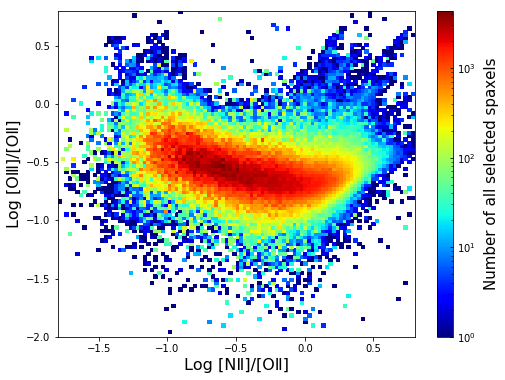

In [17]:
# 画图    
plt_log = lalala[np.where(sel_lalala==1)[0]]
# y
y = plt_log[:,2]
# x
x = plt_log[:,3]
fig = plt.figure(figsize=(8,6)) 
ax1 = fig.add_subplot(111) 
xbins,ybins,hist,cax = ax1.hist2d(x,y,bins=100,range=[[-1.8,0.8],[-2,0.8]],cmap='jet',norm=mpl.colors.LogNorm()) 
plt.xlabel('Log [NⅡ]/[OⅡ]',fontsize=16)
plt.ylabel('Log [OⅢ]/[OⅡ]',fontsize=16)
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of all selected spaxels",fontsize=15,labelpad=8)
plt.show() 
# b = np.argwhere(np.isnan(a[:,8]))
# c = np.unique(a[b,0]).astype(int)
# print(lalala.shape)
# print("max = ",np.max(lalala[:,2]))
# print("min = ",np.min(lalala[:,2]))
# print(lalala[20:40,2])

In [20]:
import k3match as km
km.celestial?


In [3]:
import time
import copy
import warnings
from os.path import join

import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from astropy.io import fits
from marvin.tools import Maps

warnings.filterwarnings('ignore')    # 不显示warning信息
vac = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy.copy(vac[1].data)    # galaxy基本信息
# 下载的离线Marvin数据路径
path_marvin_data = '/root/bash_file/marvin_vor10_fits'
# 存储 数组位置, Nii6584,Oiii5007,Oii3729,Oii3726,Oiii/Oii,Nii/Oii 10个量
galid_den_NO = np.zeros([basic['plate'].size*2800,10])-9999

INFO: No release version set. Setting default to DR15


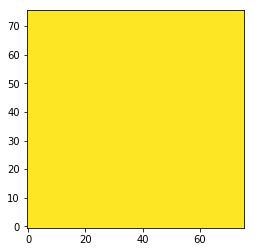

In [27]:
fig, ax = plt.subplots()
p = ax.imshow(maps, origin='lower',vmin=-10000,vmax=-9999)


In [115]:
lalala = galid_den_NO

lala = np.where(lalala[:,0]!=-9999)
lalala = lalala[lala]    # 剔除无效数据

lala = np.where(lalala[:,4]!=-999)
lalala = lalala[lala]    # 剔除无效数据

print(np.min(lalala[:,4]))
print(np.min(lalala[:,5]))

0.0
-999.0


In [107]:
a = galid_den_NO


b = np.argwhere(np.isnan(a[:,8]))
c = np.unique(a[b,0]).astype(int)
print(c)
print("形状为",c.shape)
print(a[4660,:])

[   2    3    8 ... 4660 4667 4668]
形状为 (1755,)
[ 1.         50.         33.          7.53505     0.39998493  0.27429777
  0.37887138  0.30069673 -0.39401072 -0.2301894 ]


In [79]:
# 初始化筛选计数数组
np.zeros([lalala[:,0].size,1])
# 从大数组galid_den_NO中找出筛选过的星系num_sel_gal


print(lala)
# print(np.shape(galid_den_NO[:,0]))
# print(np.shape(num_sel_gal))
# print(np.shape(galid_den_NO[:,0]))
# print(np.shape(num_sel_gal))

5791964
(5791964, 10)


In [76]:
np.min(galid_den_NO[:,0])

-9999.0

In [64]:
print(galid_den_NO.size)
print(galid_den_NO.shape)
print(galid_den_NO[3000:3030,0])

130900000
(13090000, 10)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [46]:
lalala_start = time.time()    # 开始计时
# for i in range(0,basic['plate'].size):
i = 0    # 星系的数组位置: i
j = 0    # 4675*2800的数组位置: j
#for j in range(0,1):    # 4675*2800的数组位置: j
#while j<4675*2800:
#while j<10:
#while j<basic['plate'].size*sur_density_all[0].size:
while j<2*sur_density_all[0].size:
    start_for = time.time()    # 获取初始时间
    
    
    
    # 每个星系取值
    plate = plate_np[i]    # 获取plate
    ifu = ifu_np[i]    # 获取ifu
    galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系位置数组，使用plate&ifu进行定位，得到True False数组
    bin_1d = bin1d[galid,:,0][0]    # 获取一维的bin数据
    sur_density = sur_density_all[galid][0]
    
    filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
    new_maps = Maps(filename=filename)
    nii = new_maps.emline_gflux_nii_6585    # 获取Nii_6584
    oii7 = new_maps.emline_gflux_oii_3727    # 获取Oii_3726
    oii9 = new_maps.emline_gflux_oii_3729    # 获取Oii_3729
    oiii = new_maps.emline_gflux_oiii_5008    # 获取Oiii_5007
    
    lg_oiii_oii = np.log10(oiii/(oii7+oii9))
    lg_nii_oii = np.log10(nii/(oii7+oii9))
    
    
        
    # 每个spaxel取值
    image_sz = np.shape(nii)[0]    # 图像边长
    # 临时测试，画图数组
    maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
    for y in range(0,image_sz):
        for x in range(0,image_sz):
            id_bin = (bin_1d==bin_2d[galid,y,x])    # 搜索二维bin的值在一维bin数组中的 位置
            
            if len(bin_1d[id_bin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                # spaxel所在的星系的数组位置
                galid_den_NO[j,0] = i
                # 星系中的y位置
                galid_den_NO[j,1] = y
                # 星系中的x位置
                galid_den_NO[j,2] = x
                # spaxel's surface mass density
                galid_den_NO[j,3] = sur_density[id_bin]
                # nii 6584
                galid_den_NO[j,4] = nii.value[y,x]
                # oiii 5007
                galid_den_NO[j,5] = oiii.value[y,x]
                # oii 3729
                galid_den_NO[j,6] = oii9.value[y,x]
                # oii 3726
                galid_den_NO[j,7] = oii7.value[y,x]
                # log(Oiii/Oii)
                galid_den_NO[j,8] = lg_oiii_oii.value[y,x]
                # log(nii/Oii)
                galid_den_NO[j,9] = lg_nii_oii.value[y,x]
                lala = x
                lala2 = y
                j+=1
                #print("数组位置j已到：",j)
                maps[y,x] = oii7.value[y,x]    # 临时测试，画图数组
    print("j = ",j)

j =  807
j =  1614
j =  2421
j =  3228
j =  4035
j =  4842
j =  5649


In [42]:
j = 2499
lala = 49
(j+1+2800-(lala+1)*(lala+1))%2800==0

True

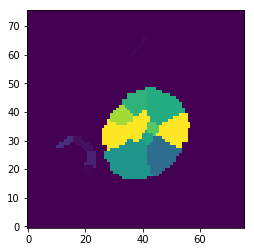

In [6]:
fig, ax = plt.subplots()
p = ax.imshow(maps , origin='lower',vmin=0,vmax=1)


In [37]:
xx=np.zeros([4000*2800,10],dtype='float32')

In [72]:
lala = np.arange(1,10) 
print(lala[-1:0])
lala = galid_den_NO[0:1]
lala.shape

[]


(1, 10)

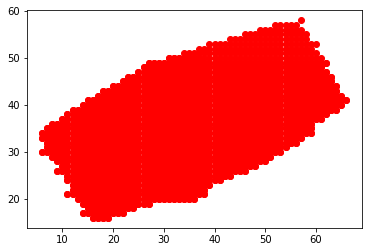

In [29]:
j = (3856-1)*2800
lala = galid_den_NO[j:j+2800]
lala = lala[np.where(lala[:,0]!=-9999)]
# y
y = lala[:,1]
# x
x = lala[:,2]
# z
z = lala[:,3]

fig = plt.figure() 
ax1 = fig.add_subplot(111) 
ax1.scatter(x,y,c = 'r',marker = 'o') 
plt.show() 

In [81]:
lala[100:120,0]

array([36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
       36., 36., 36., 36., 36., 36., 36.], dtype=float32)

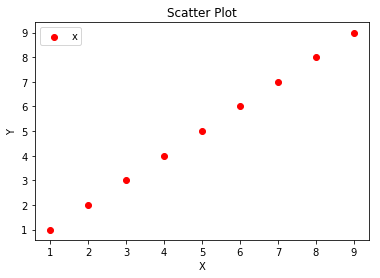

In [62]:
#导入必要的模块 
import numpy as np 
import matplotlib.pyplot as plt 
#产生测试数据 
x = np.arange(1,10) 
y = x 
fig = plt.figure() 
ax1 = fig.add_subplot(111) 
#设置标题 
ax1.set_title('Scatter Plot') 
#设置X轴标签 
plt.xlabel('X') 
#设置Y轴标签 
plt.ylabel('Y') 
#画散点图 
ax1.scatter(x,y,c = 'r',marker = 'o') 
#设置图标 
plt.legend('x1') 
#显示所画的图 
plt.show() 

Filename: /root/bash_file/marvin_vor10_fits/manga-7990-12703-MAPS-VOR10-GAU-MILESHC.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     146   ()      
  1  SPX_SKYCOO    1 ImageHDU        43   (74, 74, 2)   float32   
  2  SPX_ELLCOO    1 ImageHDU        46   (74, 74, 3)   float32   
  3  SPX_MFLUX     1 ImageHDU        36   (74, 74)   float32   
  4  SPX_MFLUX_IVAR    1 ImageHDU        37   (74, 74)   float32   
  5  SPX_SNR       1 ImageHDU        34   (74, 74)   float32   
  6  BINID         1 ImageHDU        45   (74, 74, 5)   int32   
  7  BIN_LWSKYCOO    1 ImageHDU        43   (74, 74, 2)   float32   
  8  BIN_LWELLCOO    1 ImageHDU        46   (74, 74, 3)   float32   
  9  BIN_AREA      1 ImageHDU        35   (74, 74)   float32   
 10  BIN_FAREA     1 ImageHDU        34   (74, 74)   float32   
 11  BIN_MFLUX     1 ImageHDU        37   (74, 74)   float32   
 12  BIN_MFLUX_IVAR    1 ImageHDU        38   (74, 74)   float32   
 1

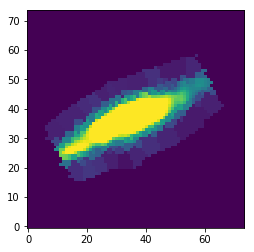

In [23]:
i=3856
plate = plate_np[i]    # 获取plate
ifu = ifu_np[i]    # 获取ifu
filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
new_maps = Maps(filename=filename)
nii = new_maps.emline_gflux_nii_6585    # 获取Nii_6584

fig, ax = plt.subplots()
p = ax.imshow(nii.value, origin='lower',vmin=0,vmax=1)

lala = fits.open(filename)
print(lala.info())
print(bin_2d[i].shape)


In [26]:
np.shape(np.where(nii.value!=0))

(2, 1470)

In [47]:
lala.info()

Filename: /root/bash_file/marvin_vor10_fits/manga-8439-3703-MAPS-VOR10-GAU-MILESHC.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     146   ()      
  1  SPX_SKYCOO    1 ImageHDU        43   (44, 44, 2)   float32   
  2  SPX_ELLCOO    1 ImageHDU        46   (44, 44, 3)   float32   
  3  SPX_MFLUX     1 ImageHDU        36   (44, 44)   float32   
  4  SPX_MFLUX_IVAR    1 ImageHDU        37   (44, 44)   float32   
  5  SPX_SNR       1 ImageHDU        34   (44, 44)   float32   
  6  BINID         1 ImageHDU        45   (44, 44, 5)   int32   
  7  BIN_LWSKYCOO    1 ImageHDU        43   (44, 44, 2)   float32   
  8  BIN_LWELLCOO    1 ImageHDU        46   (44, 44, 3)   float32   
  9  BIN_AREA      1 ImageHDU        35   (44, 44)   float32   
 10  BIN_FAREA     1 ImageHDU        34   (44, 44)   float32   
 11  BIN_MFLUX     1 ImageHDU        37   (44, 44)   float32   
 12  BIN_MFLUX_IVAR    1 ImageHDU        38   (44, 44)   float32   
 13

In [49]:
vac.info()

Filename: /root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GALAXY_INFO    1 BinTableHDU     31   4675R x 11C   ['20A', '20A', 'I', '20A', 'E', 'E', 'E', 'E', '20A', '20A', '20A']   
  2  GLOBAL_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  3  GRADIENT_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  SPATIAL_INFO    1 ImageHDU         9   (4, 2800, 4675)   float32   
  5  SPATIAL_BINID    1 ImageHDU         9   (76, 76, 4675)   int16   
  6  LW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  7  MW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  8  LW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  9  MW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
 10  E(B_

In [40]:
sur_density = copy.copy(vac['SURFACE_MASS_DENSITY_VORONOI'].data)
type(sur_density)

numpy.ndarray

In [68]:
np.shape(vac['SURFACE_MASS_DENSITY_VORONOI'].data[:,:,0])

(4675, 2800)

In [79]:
sur_density = copy.copy(vac['SURFACE_MASS_DENSITY_VORONOI'].data[:,:,0])    # surface mass density
sur_density_all[galid][0][111]

-9999.0

In [85]:
path_marvin_data = '/root/bash_file/marvin_vor10_fits'
galid_den_NO = np.zeros([basic['plate'].size*2800,10])-9999    # 存储 数组位置, Nii6584,Oiii5007,Oii3729,Oii3726,Oiii/Oii,Nii/Oii 7个量

sur_density_all = copy.copy(vac['SURFACE_MASS_DENSITY_VORONOI'].data[:,:,0])    # surface mass density

bin1d = vac[4].data    # 获取bin_id数组，为了匹配xy坐标位置
bin2d = vac[5].data    # 获取bin_id数组，为了匹配xy坐标位置

plate_np = basic['plate']
ifu_np = basic['ifudsgn']
plate_np = plate_np.astype(np.int64)    # 数据转化为整型
#ifu_np = ifu_np.astype(np.int64)    # 数据转化为整型

lalala_start = time.time()    # 开始计时
# for i in range(0,basic['plate'].size):
i = 0    # 星系的数组位置: i
j = 0    # 4675*2800的数组位置: j
#for j in range(0,1):    # 4675*2800的数组位置: j
#while j<4675*2800:
while j<10:
    start_for = time.time()    # 获取初始时间
    
    # 每个星系取值
    plate = plate_np[i]    # 获取plate
    ifu = ifu_np[i]    # 获取ifu
    galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系位置数组，使用plate&ifu进行定位，得到True False数组
    bin_1d = bin1d[galid,:,0][0]    # 获取一维的bin数据
    sur_density = sur_density_all[galid][0]
    
    filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
    new_maps = Maps(filename=filename)
    nii = new_maps.emline_gflux_nii_6585    # 获取Nii_6584
    oii7 = new_maps.emline_gflux_oii_3727    # 获取Oii_3726
    oii9 = new_maps.emline_gflux_oii_3729    # 获取Oii_3729
    oiii = new_maps.emline_gflux_oiii_5008    # 获取Oiii_5007
    
    lg_oiii_oii = np.log10(oiii/(oii7+oii9))
    lg_nii_oii = np.log10(nii/(oii7+oii9))
        
    # 每个spaxel取值
    image_sz = np.shape(nii)[0]    # 图像边长
    maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
    for y in range(0,image_sz):
        for x in range(0,image_sz):
            id_bin = (bin_1d==bin_2d[galid,y,x])    # 搜索二维bin的值在一维bin数组中的 位置
            
            if len(bin_1d[id_bin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                # spaxel所在的星系的数组位置
                galid_den_NO[j,0] = i
                # 星系中的y位置
                galid_den_NO[j,1] = y
                # 星系中的x位置
                galid_den_NO[j,2] = x
                # spaxel's surface mass density
                galid_den_NO[j,3] = sur_density[id_bin]
                # nii 6584
                galid_den_NO[j,4] = nii.value[y,x]
                # oiii 5007
                galid_den_NO[j,5] = oiii.value[y,x]
                # oii 3729
                galid_den_NO[j,6] = oii9.value[y,x]
                # oii 3726
                galid_den_NO[j,7] = oii7.value[y,x]
                # log(Oiii/Oii)
                galid_den_NO[j,8] = lg_oiii_oii.value[y,x]
                # log(nii/Oii)
                galid_den_NO[j,9] = lg_nii_oii.value[y,x]
                
                maps[y,x] = oii7.value[y,x]
    # 计算完上一个星系的有效spaxel
    # 继续下一个星系，并且跳过无效数据范围
    if (j+1+2800-x*x)%2800 == 0:
        i += 1
        j = j+2800-x*x
        continue    # 跳过无效数据的匹配
        
    j += 1    # 继续

    end_for = time.time()
    print('用时: ',end_for-start_for,"  已经计算到第 ",i+1," 个星系   ","剩余 ",4675-i-1,' 个星系')
    
    
lalala_end = time.time()
print('\n\n\n总用时： ',str(lalala_end-lalala_start))

# 将得到的结果进行保存 (4675*2800,10)
# 无效数据为-9999
np.savetxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/galid_ij_den_NO_logOiiioii_logniioii.dat", galid_den_NO)               

# 简单画图测试
# fig, ax = plt.subplots()
# p = ax.imshow(maps , origin='lower',vmin=0,vmax=1)

                

用时:  0.9593112468719482   已经计算到第  1  个星系    剩余  4674  个星系
用时:  0.9883279800415039   已经计算到第  1  个星系    剩余  4674  个星系
用时:  0.8979442119598389   已经计算到第  1  个星系    剩余  4674  个星系
用时:  0.950430154800415   已经计算到第  1  个星系    剩余  4674  个星系
用时:  0.8593490123748779   已经计算到第  1  个星系    剩余  4674  个星系
用时:  0.8881747722625732   已经计算到第  1  个星系    剩余  4674  个星系
用时:  0.929023265838623   已经计算到第  1  个星系    剩余  4674  个星系
用时:  1.1342930793762207   已经计算到第  1  个星系    剩余  4674  个星系
用时:  0.9285380840301514   已经计算到第  1  个星系    剩余  4674  个星系
用时:  0.9060094356536865   已经计算到第  1  个星系    剩余  4674  个星系



总用时：  9.459567070007324


In [86]:
galid_den_NO[0:15,4]

array([ 3.92387807e-02,  3.92387807e-02,  3.92387807e-02,  3.92387807e-02,
        3.92387807e-02,  3.92387807e-02,  3.92387807e-02,  3.92387807e-02,
        3.92387807e-02,  3.92387807e-02, -9.99900000e+03, -9.99900000e+03,
       -9.99900000e+03, -9.99900000e+03, -9.99900000e+03])

In [41]:
a = vac[4].data[galid,:,0][0]
print(np.where(a!=-9999))
print(vac[4].data[galid,:,1][0])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),)
[ 1.0131296e-02  5.1013303e-01 -9.8986948e-01 ... -9.9990000e+03
 -9.9990000e+03 -9.9990000e+03]


In [66]:
oii7.value

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [61]:
np.array(x)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [62]:
x

<Marvin Map (property='emline_gflux_oii_3727')>
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] 1e-17 erg / (cm2 s spaxel)

In [18]:
np.min(bin1d)
print(np.shape(np.where(bin1d!=-9999)))

(1, 27)


In [25]:
print(plate)
print(ifu)
print(np.where(galid==0))

8252
12701
(array([   1,    2,    3, ..., 4672, 4673, 4674]),)


(1, 27)


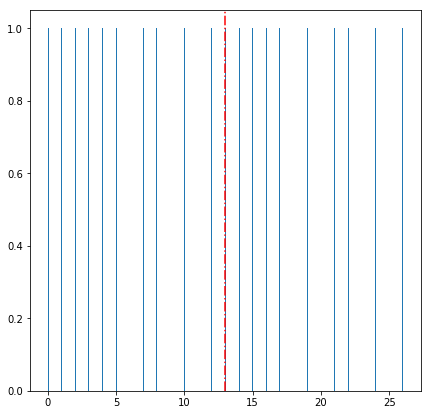

In [19]:
sfr_num0 = bin1d[np.where(bin1d!=-9999)]
plt.figure(figsize=(7,7))
plt.hist(sfr_num0,bins=500);
plt.axvline(np.mean(sfr_num0),color='r',linestyle='-.');
#sfr_id = np.where(plfu_sfr[:,2]>=20)
print(np.shape(np.where(sfr_num0!=-9999)))

In [8]:
    
    # 每个spaxel取值
    image_sz = np.shape(nii)[0]    # 图像边长
    #maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
    for y in range(0,image_sz):
        for x in range(0,image_sz):
            
            id_bin = (bin_1d==bin_2d[galid,y,x])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin_1d[id_bin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                # spaxel所在的星系的数组位置
                #galid_den_NO[i,0] = 0
                # 星系中的y位置
                #galid_den_NO[i,1] = y
                # 星系中的x位置
                #galid_den_NO[i,2] = x
                # spaxel's surface mass density
                #galid_den_NO[i,3] = sur_density

                print(id_bin)
    
                
                
            #maps[i,j] = mass[id_bin]
            
            
            
        

KeyboardInterrupt: 

In [56]:
    
a = oii9
print(a)
print(type(a))
print(np.shape(a))
print(np.max(a))
print(np.min(a))
np.shape(a)[0]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 1e-17 erg / (cm2 s spaxel)
<class 'marvin.tools.quantities.map.Map'>
(44, 44)
1.9216845035552979 1e-17 erg / (cm2 s spaxel)
0.0 1e-17 erg / (cm2 s spaxel)


44

In [1]:
   
    logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
    
    # 画图
    image_sz = np.shape(new_mask)[0]    # 图像边长
    maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            maps[i,j] = mass[idbin]

    
    
    
    
    
    
    galid_den_NO[i,0] = i    # 数组位置存储
    galid_den_NO[i,1] = 
    end_for = time.time()
    print('用时: ',end_for-start_for,"  已经计算到第 ",i+1," 个星系   ","剩余 ",basic['plate'].size-i-1,' 个星系')
    
    
lalala_end = time.time()
print('\n\n\n总用时： ',str(lalala_end-lalala_start))

SyntaxError: invalid syntax (pyqz.py, line 439)